# EHR Prediction & XAI Benchmark — Multi-Scenario Pipeline

Runs the full pipeline (data loading → classic models → DL training → IG → EG → counterfactuals) **once per simulation scenario** defined in **Cell 1**.

All results land in `<OUT_DIR>/<scenario_tag>/` so every scenario stays isolated.

**Sections**
1. Configuration
2. Scenario loop — everything below runs automatically for each scenario
   - 2.1 Data loading & splitting
   - 2.2 Classic models (LR, RF)
   - 2.3 Deep learning models (GRU, LSTM)
   - 2.4 Benchmark table
   - 2.5 Case-study selection
   - 2.6 XAI — Integrated Gradients (IG)
   - 2.7 XAI — Expected Gradients (EG)
   - 2.8 Counterfactual explanations
3. Cross-scenario comparison

---
## 1. Configuration

> **This is the only cell you need to edit.**

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import utils

utils.set_seed(42)

# ── Paths ──────────────────────────────────────────────────────────────────────
SIM_DIR = "/mnt/c/Users/hoepler/Documents/LifeSpanAI_OMEN/simulation_study_life_span_ai_omen/sim_outputs"   # folder where R saved the CSVs
OUT_DIR = "/home/hoepler/longitudinal_prediction_modeling/pipeline_out"  # one sub-folder per scenario is created here
os.makedirs(OUT_DIR, exist_ok=True)

# ── Scenario registry ──────────────────────────────────────────────────────────
# Each entry maps a human-readable name to the scenario_tag produced by R
# (the tag is printed by R as "Files saved with tag: <tag>") and the
# N_patients / N_visits that were used so load_data knows the tensor dimensions.
#
# Format:
#   "display_name": {
#       "tag"       : "<exact tag string from R>",
#       "n_patients": <int>,
#       "n_visits"  : <int>,
#   }

SCENARIOS = {
    "Baseline": {
        "tag": "N3000_V20_trig0.15_esc0.10_bg0.010",
        "n_patients": 3000,
        "n_visits": 20,
    },
    "Small N": {
        "tag": "N500_V20_trig0.15_esc0.10_bg0.010",
        "n_patients": 500,
        "n_visits": 20,
    },
    "Large N": {
        "tag": "N10000_V20_trig0.15_esc0.10_bg0.010",
        "n_patients": 10000,
        "n_visits": 20,
    },
    "Rare Trigger": {
        "tag": "N3000_V20_trig0.05_esc0.10_bg0.010",
        "n_patients": 3000,
        "n_visits": 20,
    },
    "Very Rare Trigger": {
        "tag": "N3000_V20_trig0.02_esc0.10_bg0.010",
        "n_patients": 3000,
        "n_visits": 20,
    },
    "Short History": {
        "tag": "N3000_V10_trig0.15_esc0.10_bg0.010",
        "n_patients": 3000,
        "n_visits": 10,
    },
    "Long History": {
        "tag": "N3000_V50_trig0.15_esc0.10_bg0.010",
        "n_patients": 3000,
        "n_visits": 50,
    },
    "High Noise": {
        "tag": "N3000_V20_trig0.15_esc0.10_bg0.050",
        "n_patients": 3000,
        "n_visits": 20,
    },
    "Very High Noise": {
        "tag": "N3000_V20_trig0.15_esc0.10_bg0.100",
        "n_patients": 3000,
        "n_visits": 20,
    },
    "Stress Test": {
        "tag": "N5000_V30_trig0.05_esc0.10_bg0.050",
        "n_patients": 5000,
        "n_visits": 30,
    },
}

# ── Model registry (shared across all scenarios) ───────────────────────────────
MODEL_REGISTRY = {
    "GRU" : lambda n: utils.GRUModel( input_size=n, hidden_size=32, output_size=1, dropout_rate=0.5),
    "LSTM": lambda n: utils.LSTMModel(input_size=n, hidden_size=32, output_size=1, dropout_rate=0.5),
}

# ── Hyper-parameters (shared across all scenarios) ─────────────────────────────
TRAIN_CONFIG = dict(epochs=40, batch_size=32, lr=0.001)
EG_CONFIG    = dict(background_size=128, nsamples=200, seed=42)
IG_N_STEPS   = 64
CF_CONFIG    = dict(threshold=0.5, max_edits=8, mode="token", time_weight=0.0)

PHENOTYPE_GROUPS = [
    ("trigger_only",       "Pure Trigger"),
    ("chronic_only",       "Pure Chronic"),
    ("escalation_only",    "Pure Late Escalation"),
    ("trigger+chronic",    "Mixed: Trigger + Chronic"),
    ("trigger+escalation", "Mixed: Trigger + Escalation"),
    ("escalation+chronic", "Mixed: Chronic + Escalation"),
    ("all_three",          "Mixed: All Three"),
]

# Collector for cross-scenario comparison (populated in the loop)
all_benchmarks    = {}
all_faithfulness  = {}

print(f"Scenarios registered: {list(SCENARIOS.keys())}")

Random seed set to: 42
Scenarios registered: ['Baseline', 'Small N', 'Large N', 'Rare Trigger', 'Very Rare Trigger', 'Short History', 'Long History', 'High Noise', 'Very High Noise', 'Stress Test']


---
## 2. Scenario Loop

The cell below runs the **entire pipeline** for every scenario in `SCENARIOS`.
Each scenario writes its outputs to `OUT_DIR/<scenario_name>/`.

To run a **single scenario** during development, pass a name to the filter:
```python
run_scenarios = ["Baseline"]   # ← uncomment and set
```


  SCENARIO: Baseline  |  tag: N3000_V20_trig0.15_esc0.10_bg0.010
Loaded: X=(3000, 20, 142)  |  prevalence=0.303
Train: 2400  |  Test: 600

Training: GRU
  Epoch 05 | Loss 0.5832 | Val AUC 0.6311
  Epoch 10 | Loss 0.4244 | Val AUC 0.8078
  Epoch 15 | Loss 0.3434 | Val AUC 0.8224
  Epoch 20 | Loss 0.2994 | Val AUC 0.8107
  Epoch 25 | Loss 0.2556 | Val AUC 0.7944
  Epoch 30 | Loss 0.2076 | Val AUC 0.7839
  Epoch 35 | Loss 0.1539 | Val AUC 0.7826
  Epoch 40 | Loss 0.1027 | Val AUC 0.7709


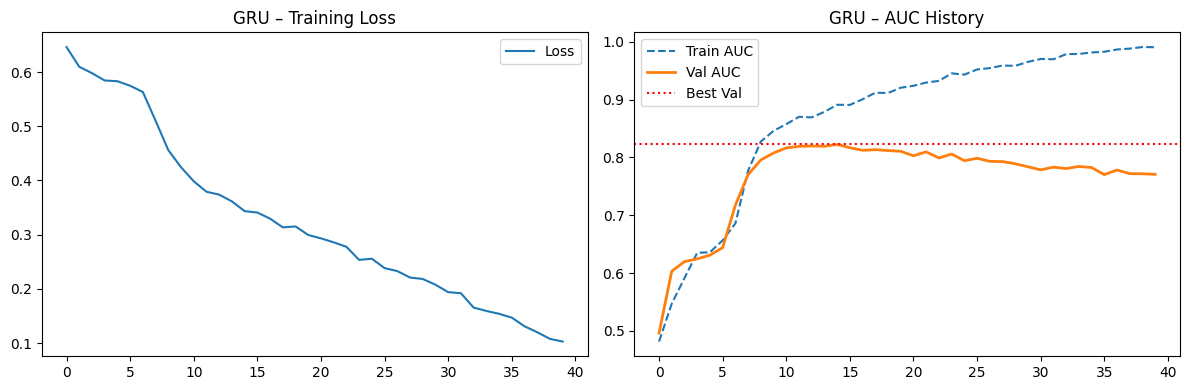


Training: LSTM
  Epoch 05 | Loss 0.4981 | Val AUC 0.7922
  Epoch 10 | Loss 0.3962 | Val AUC 0.8075
  Epoch 15 | Loss 0.3681 | Val AUC 0.8042
  Epoch 20 | Loss 0.3400 | Val AUC 0.8096
  Epoch 25 | Loss 0.3137 | Val AUC 0.8026
  Epoch 30 | Loss 0.2653 | Val AUC 0.7868
  Epoch 35 | Loss 0.2582 | Val AUC 0.7841
  Epoch 40 | Loss 0.1674 | Val AUC 0.7745


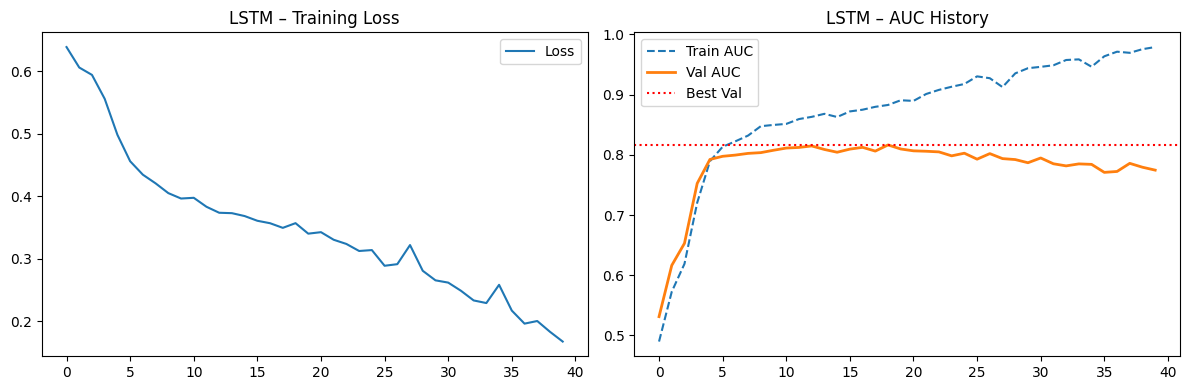


Benchmark:


Model  Train AUC  Test AUC     Gap
0                  GRU     0.9091    0.8224  0.0866
1                 LSTM     0.9002    0.8163  0.0839
2        Random Forest     0.9564    0.8152  0.1412
3  Logistic Regression     1.0000    0.7137  0.2863


--- IG global ---
IG global – GRU  (108 true-positive patients)…
IG global – LSTM  (108 true-positive patients)…


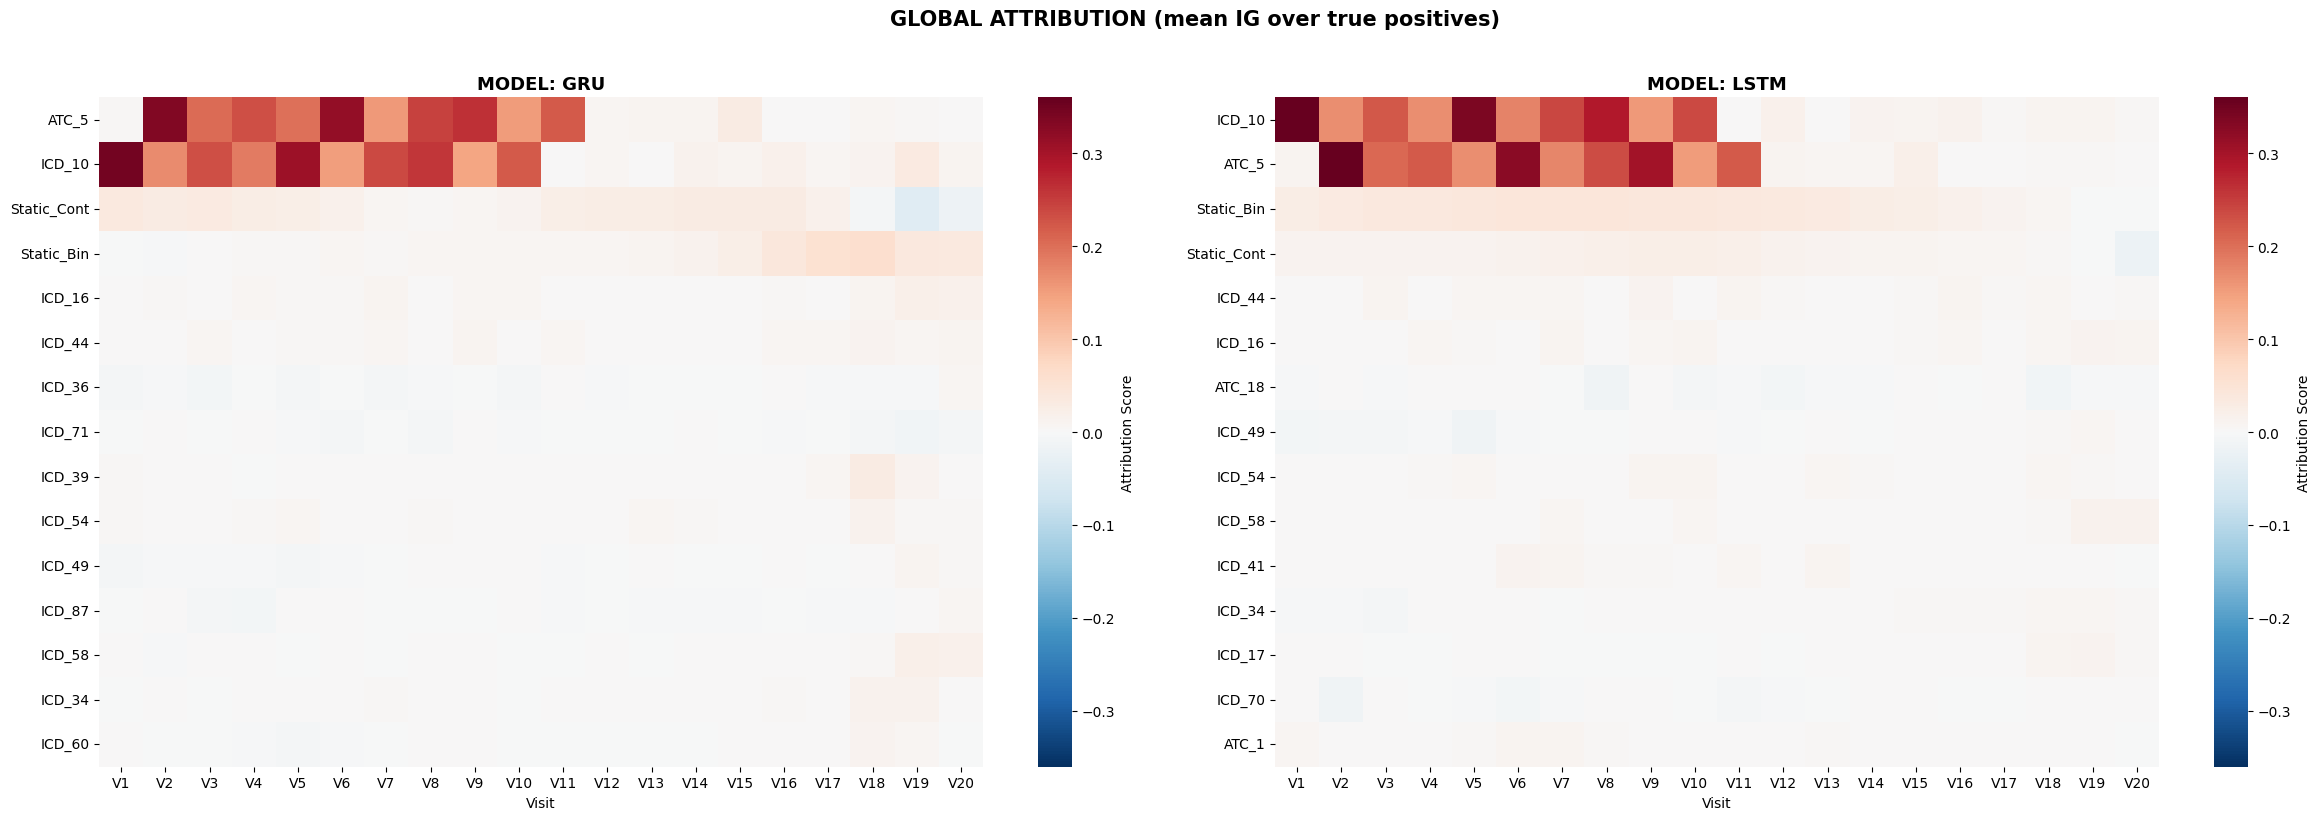


--- IG case studies ---


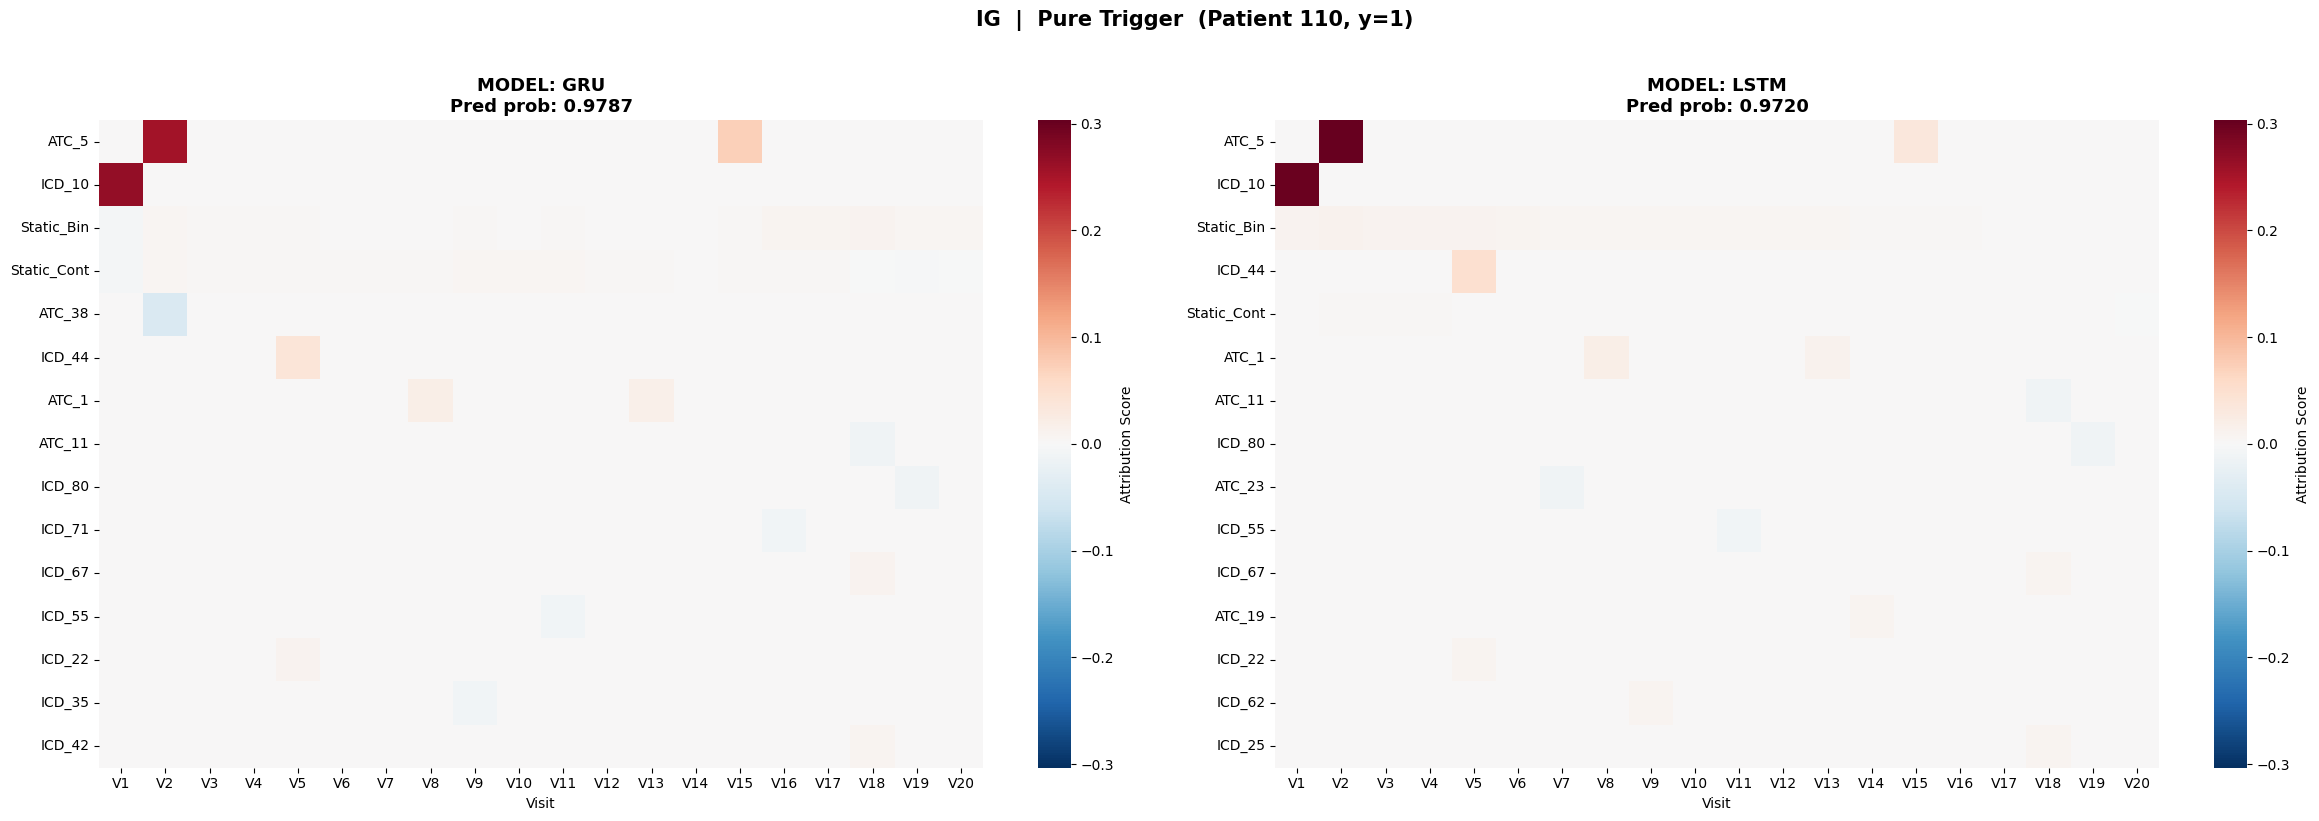

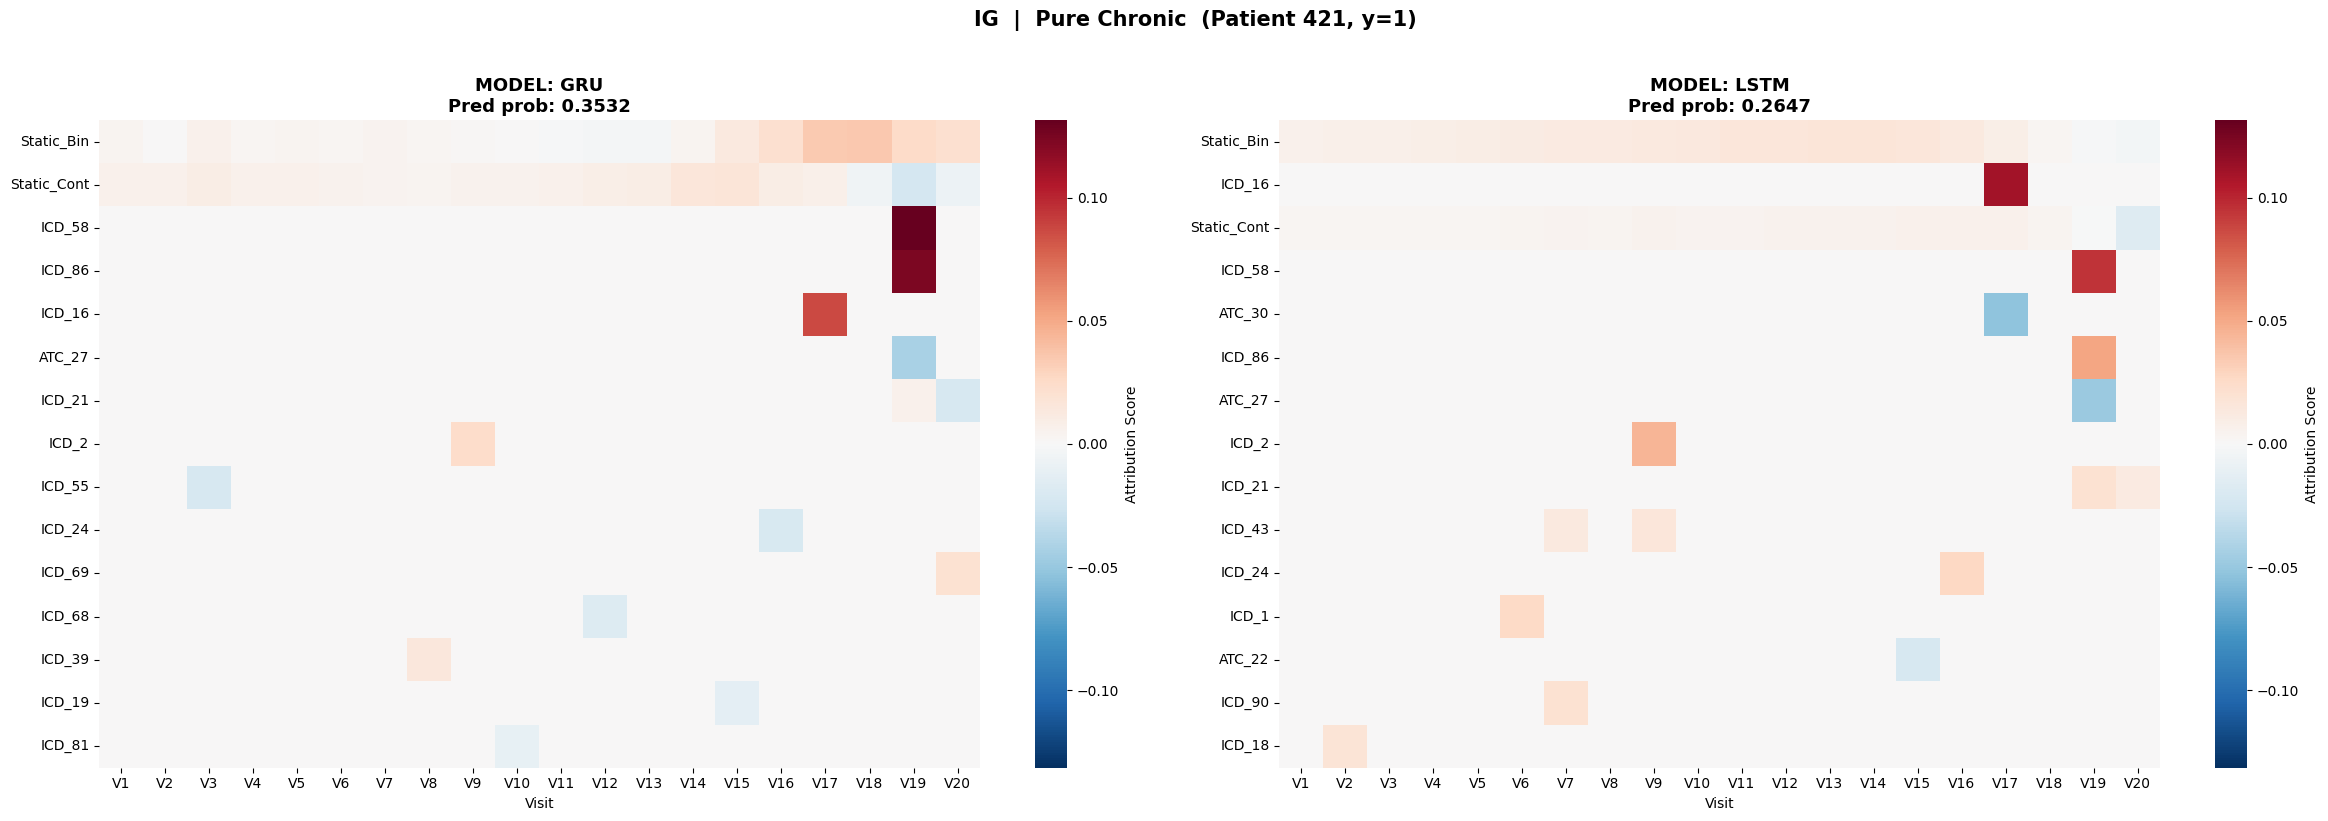

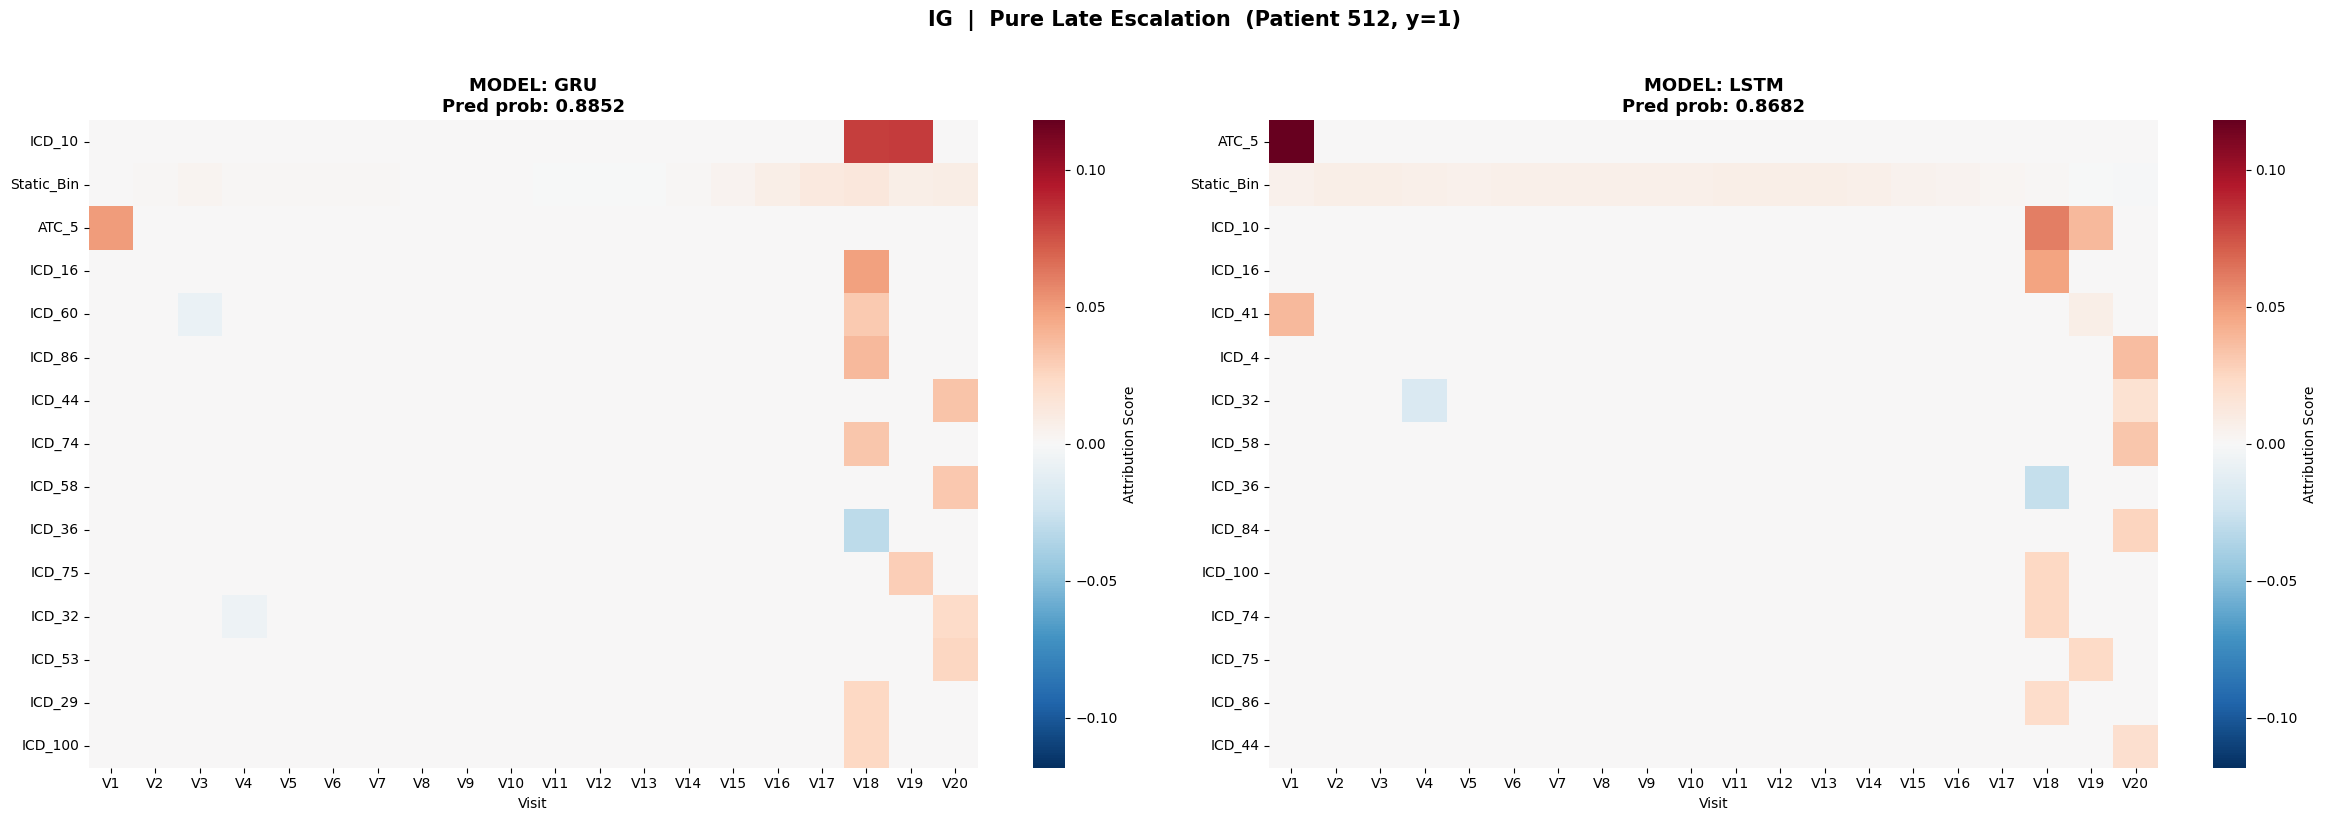

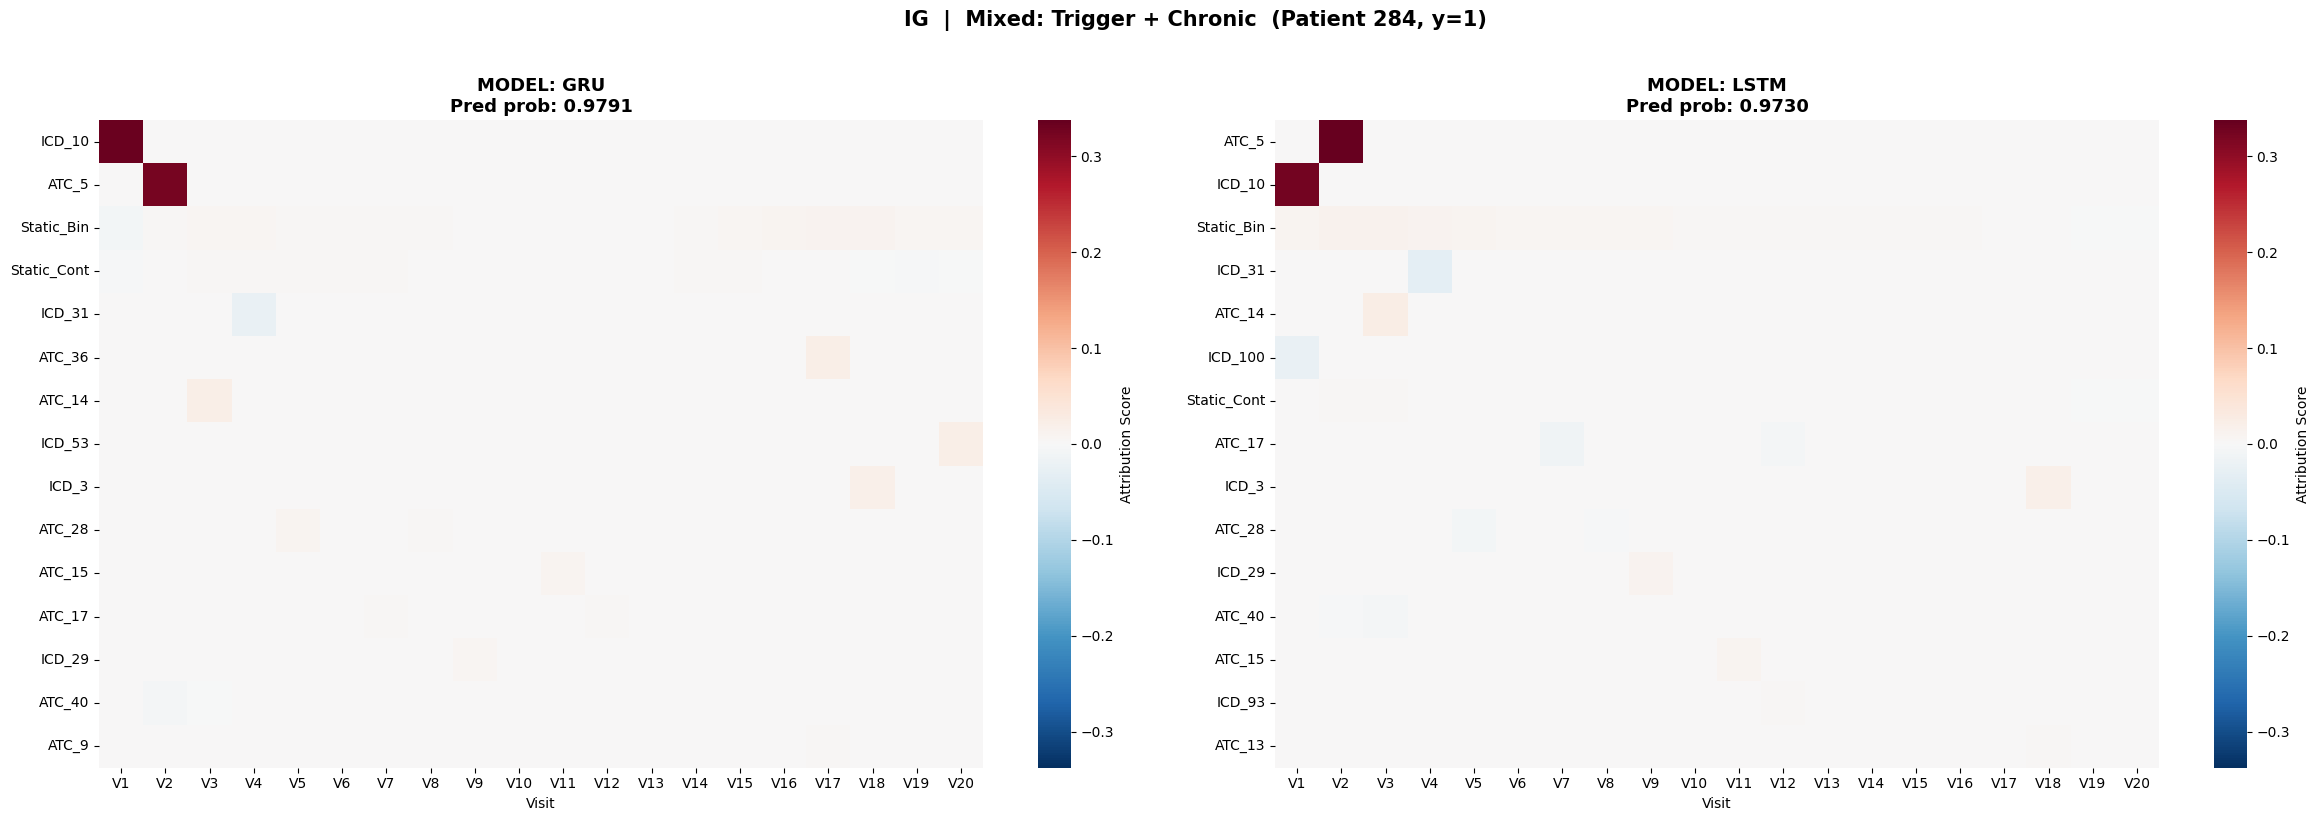

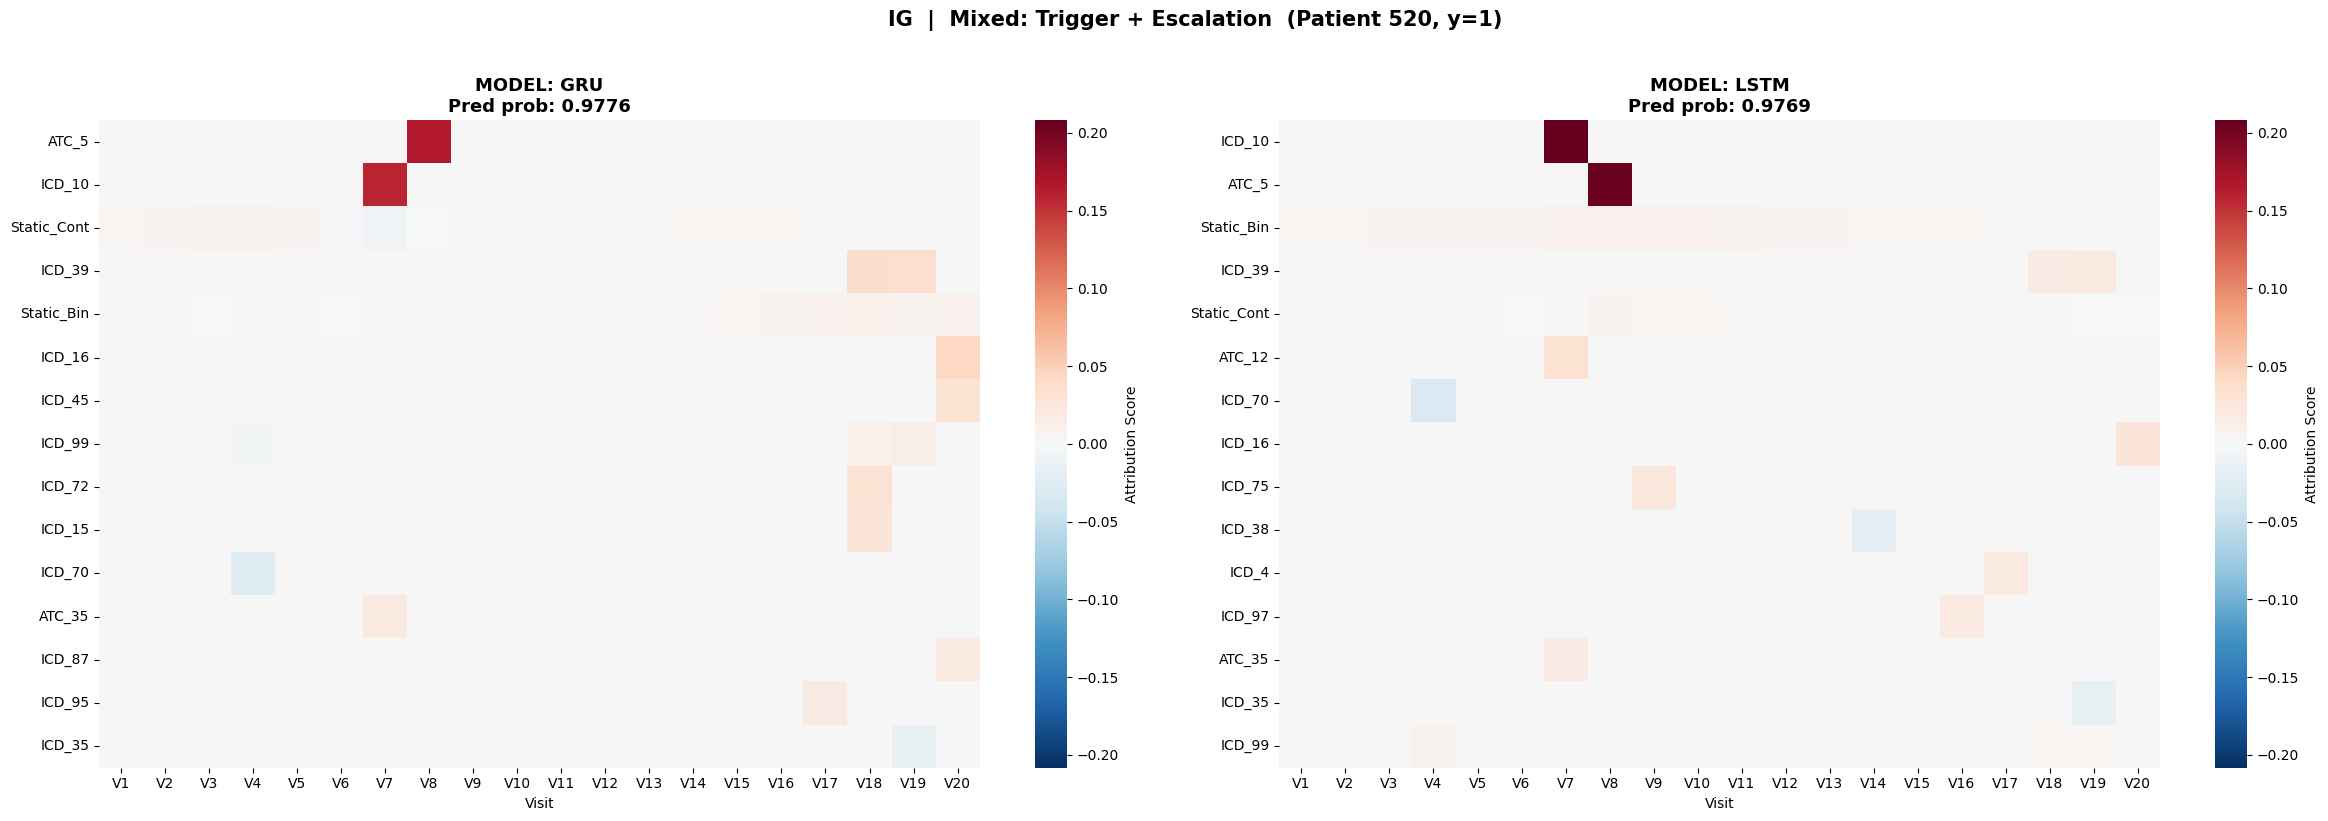

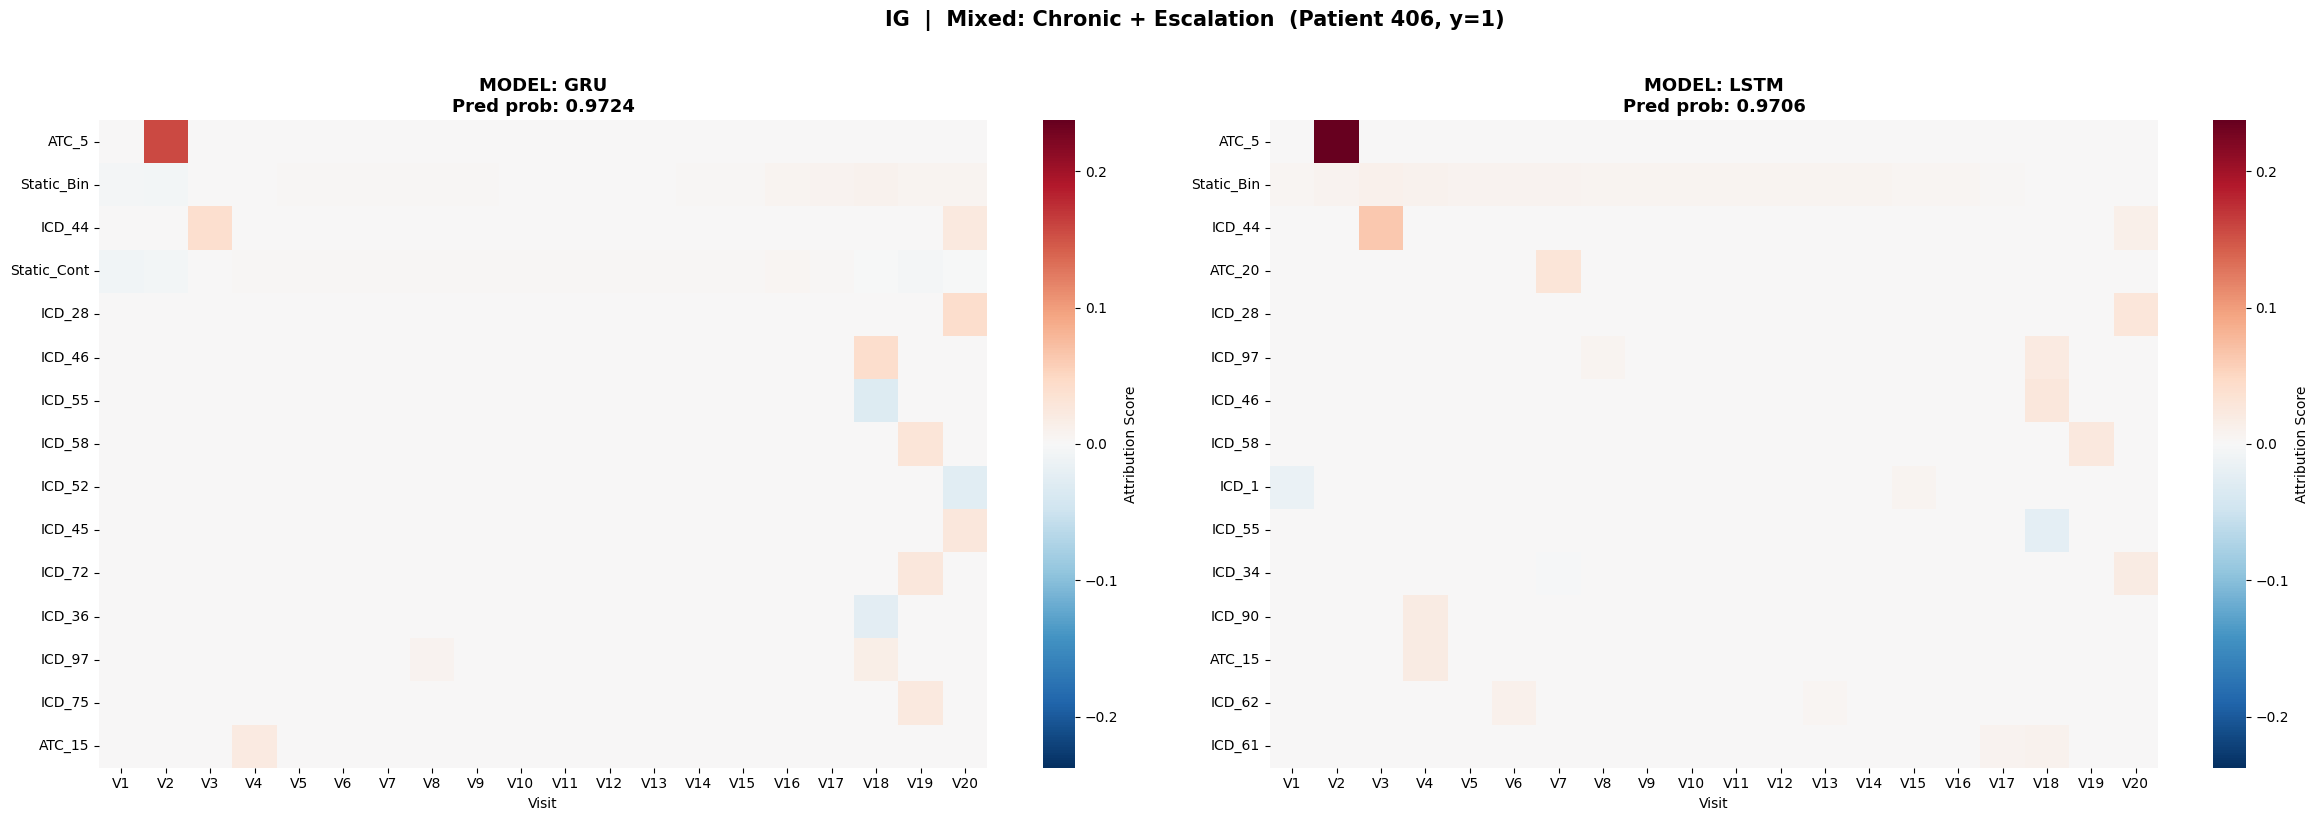

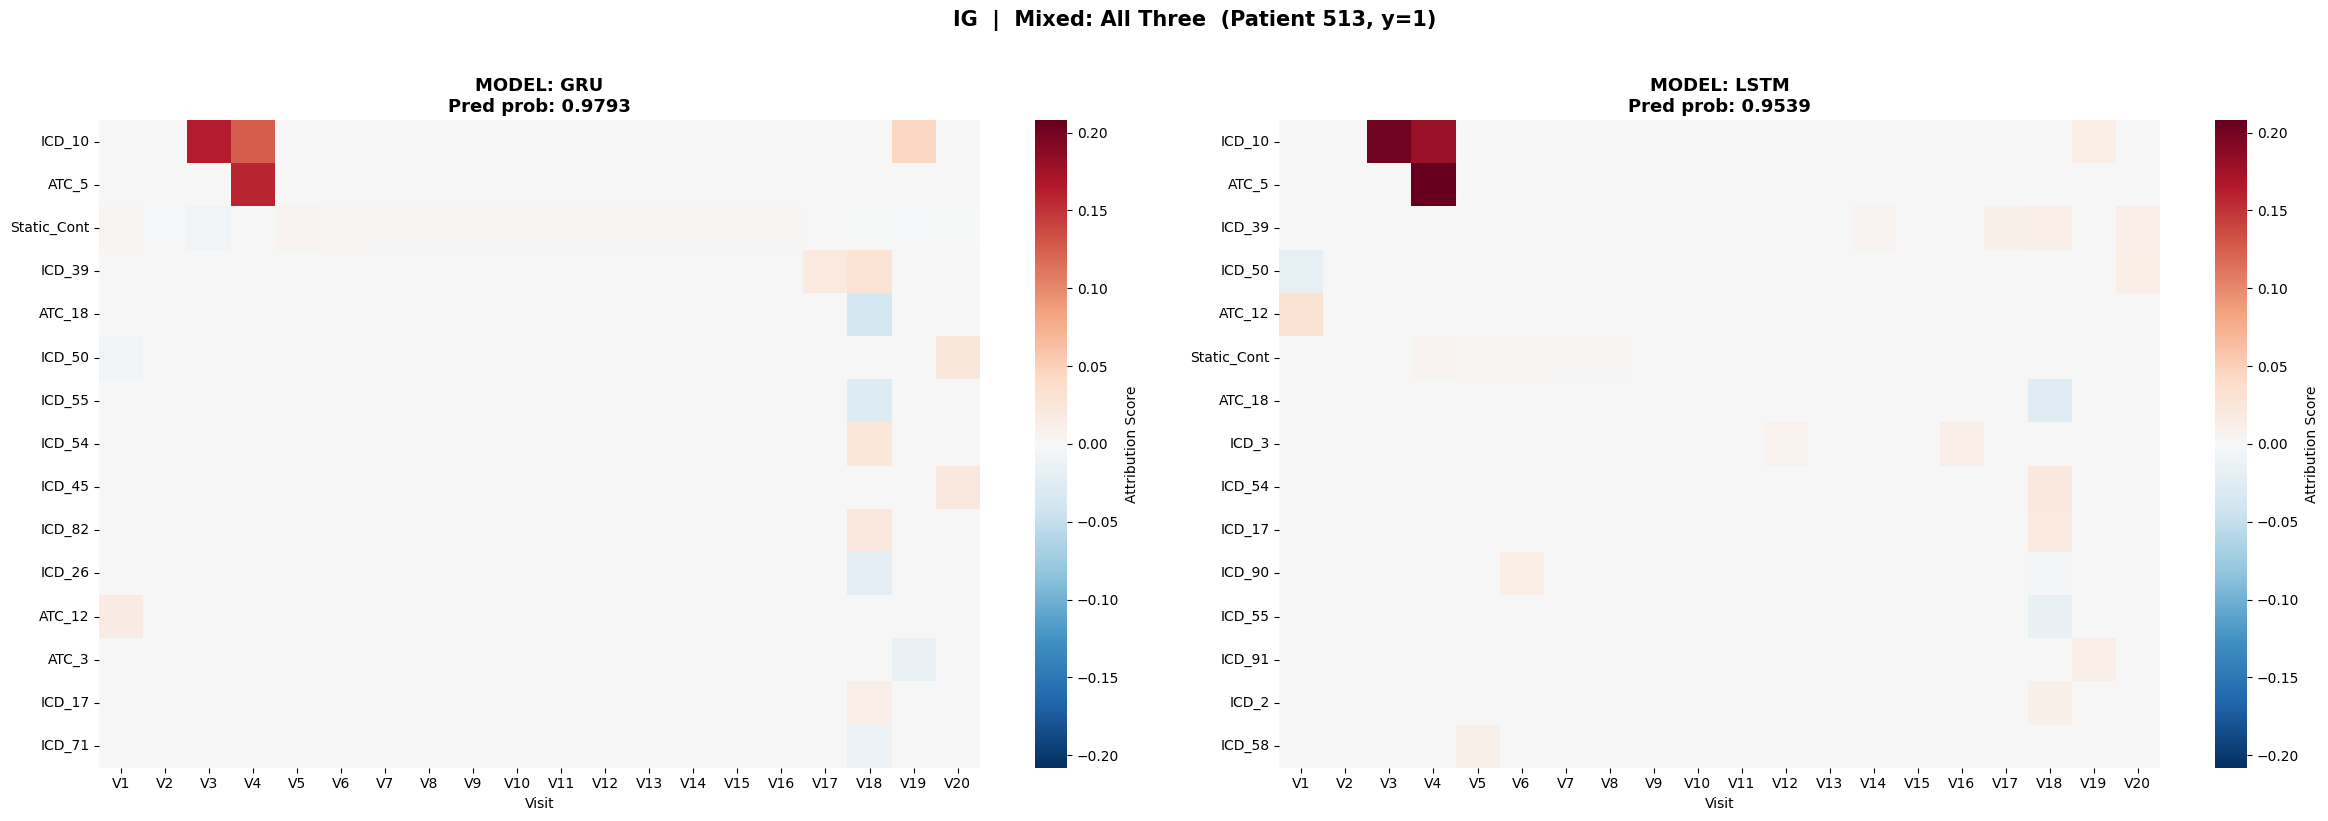

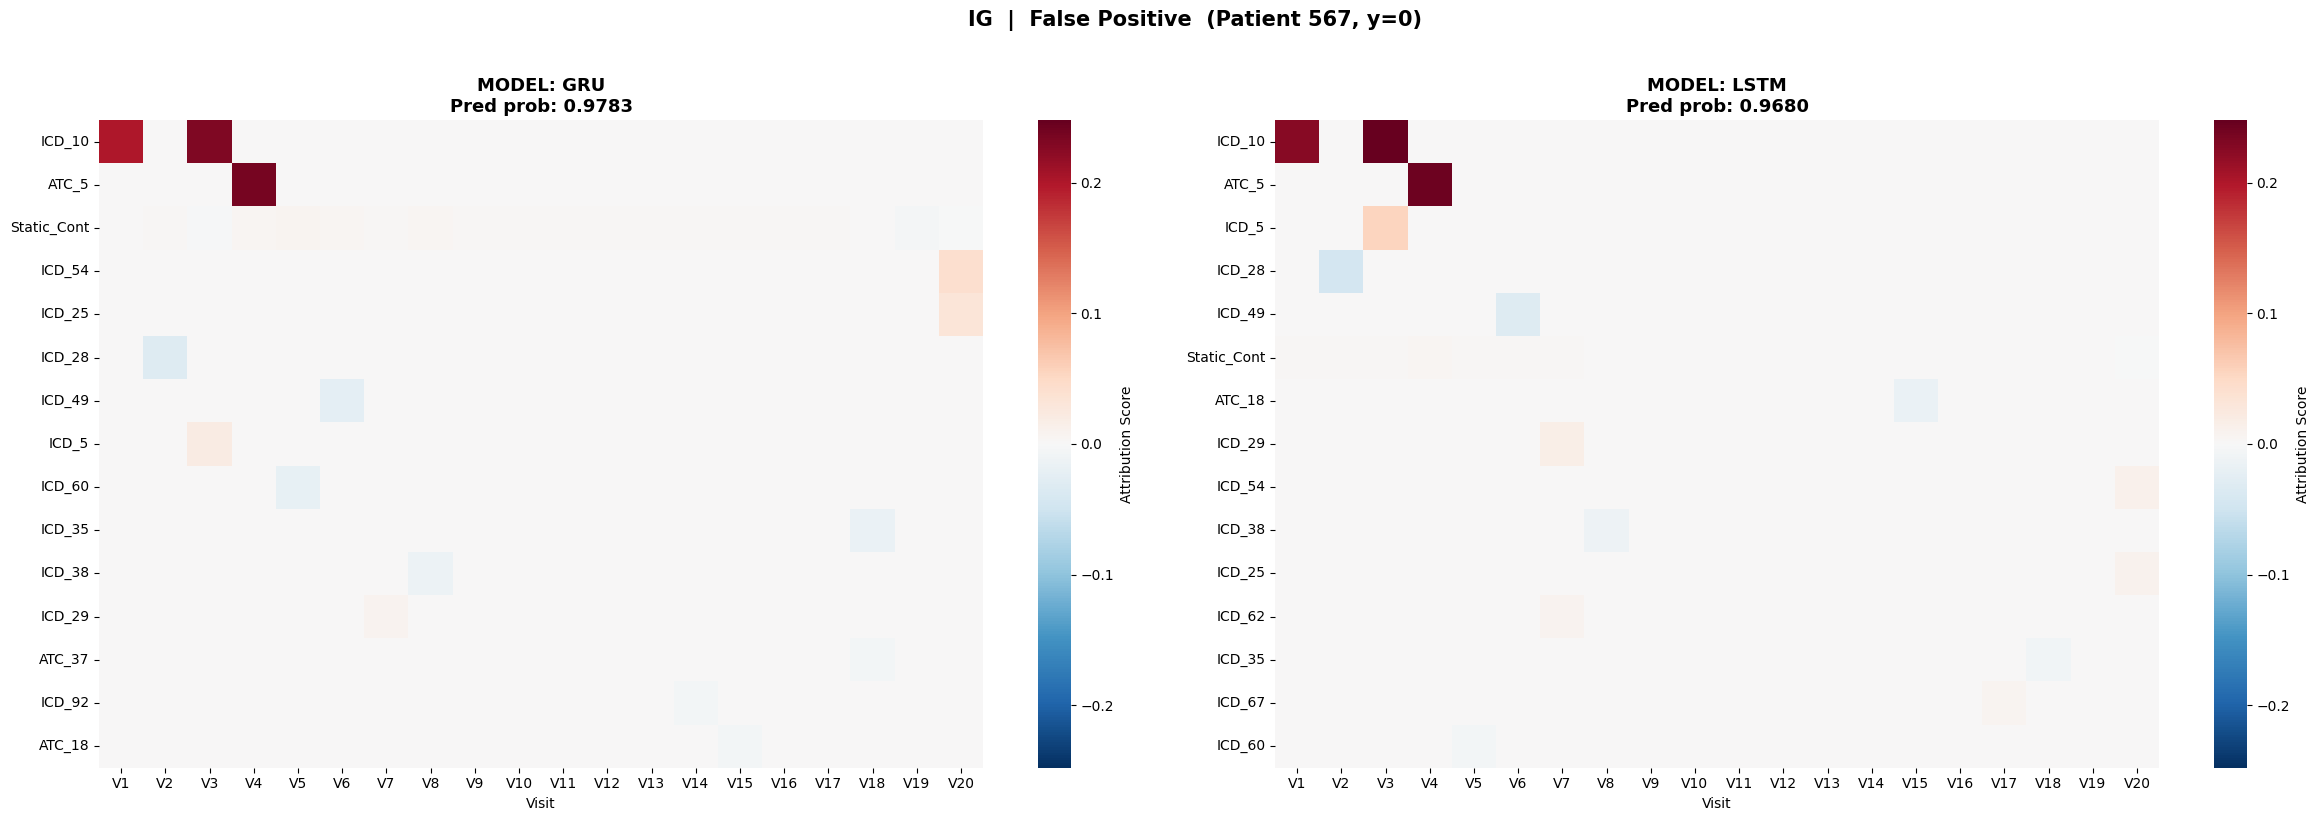


--- EG (all models) ---
EG – GRU…
  shape=(600, 20, 142)  base_value=0.0000
EG – LSTM…
  shape=(600, 20, 142)  base_value=0.0000


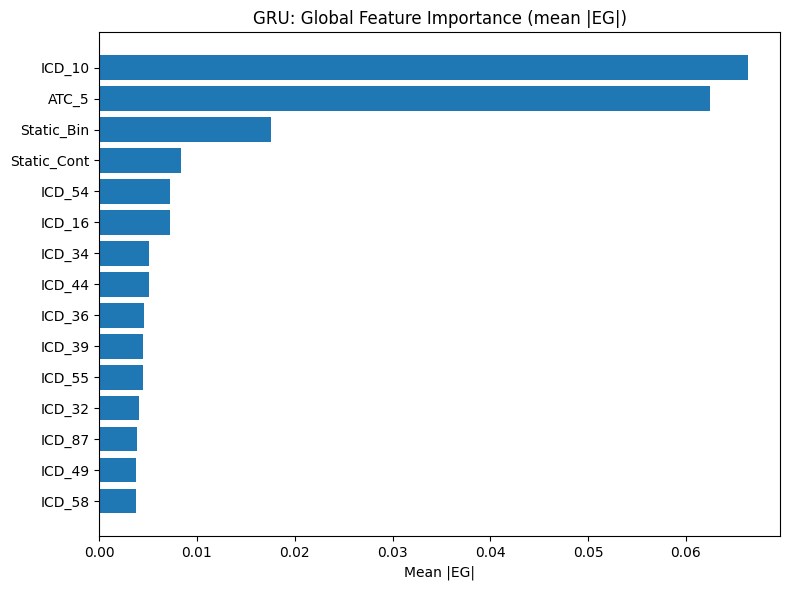

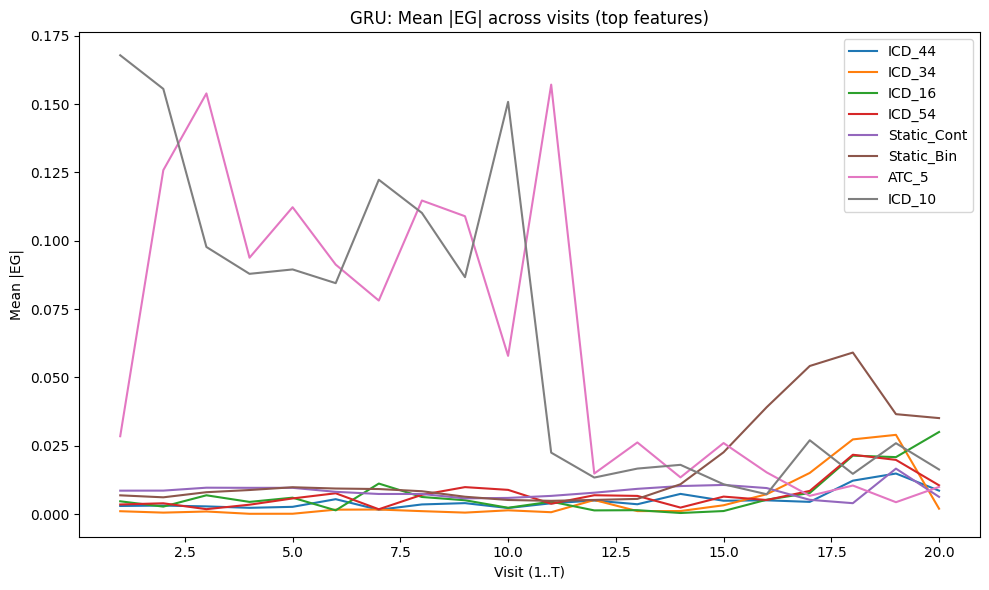

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


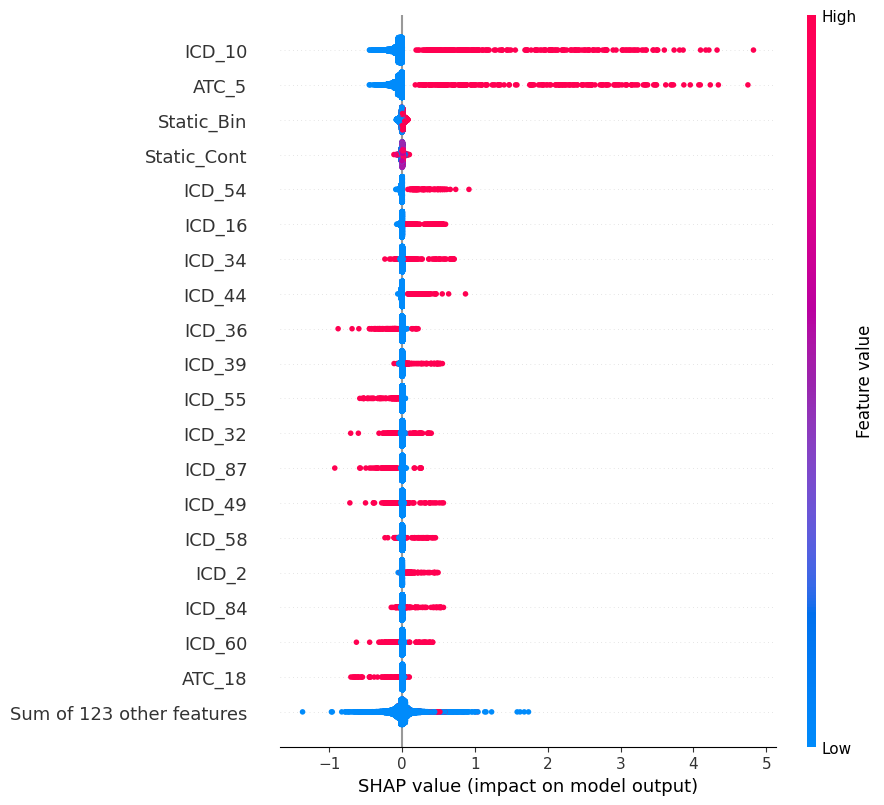

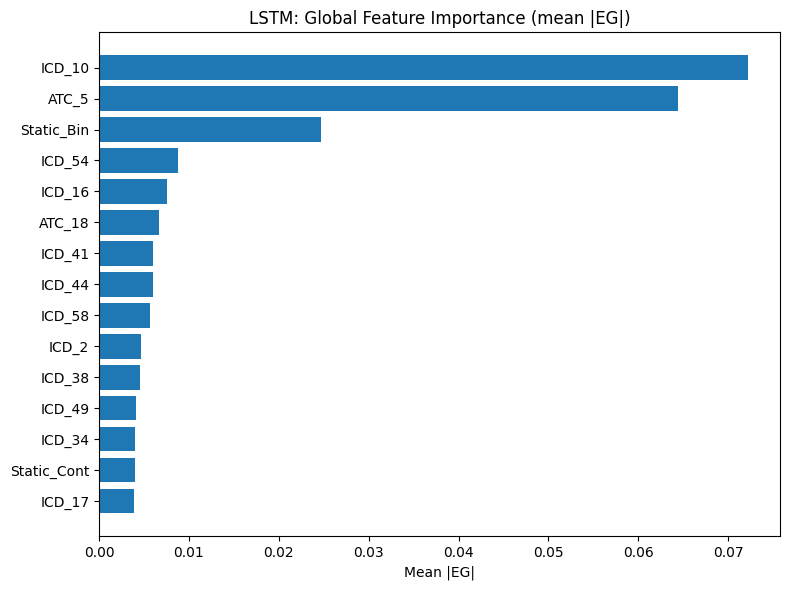

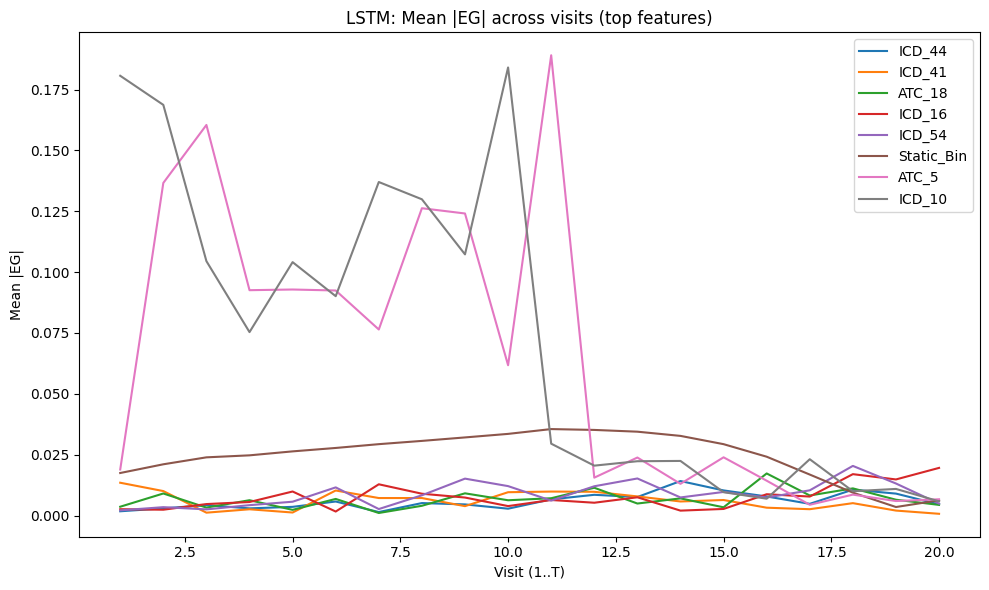

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


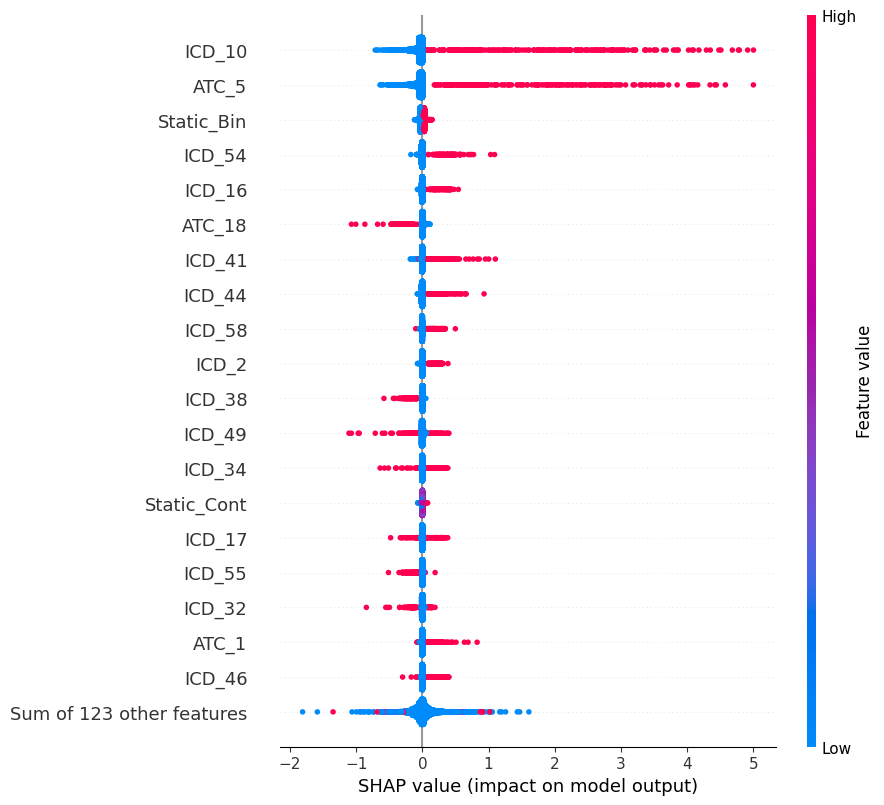


--- EG local plots | GRU | patient 2 ---


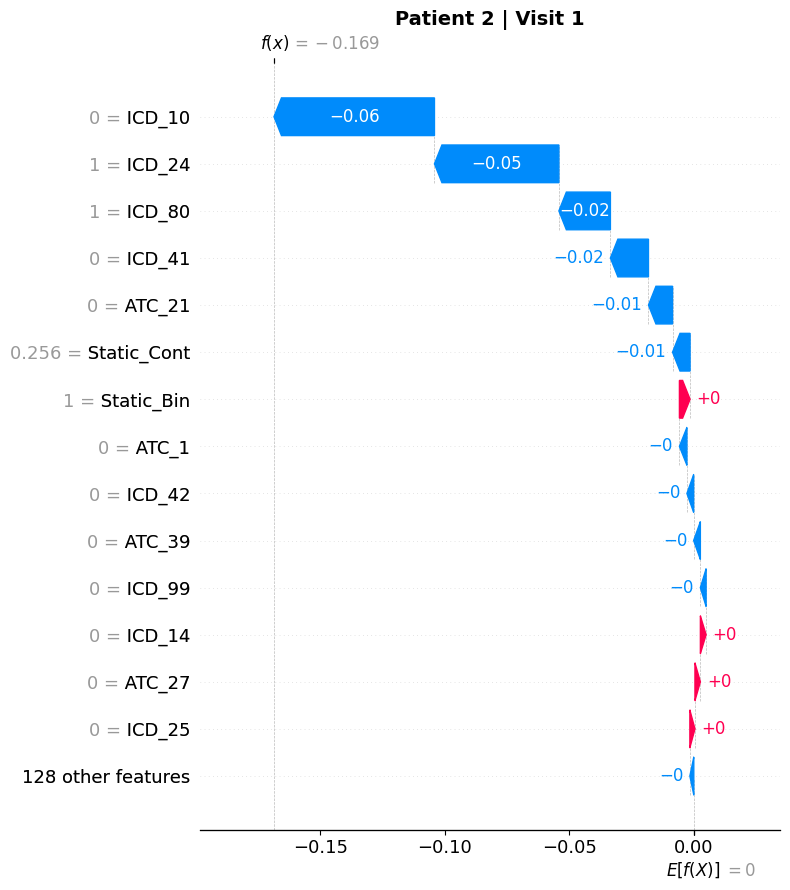

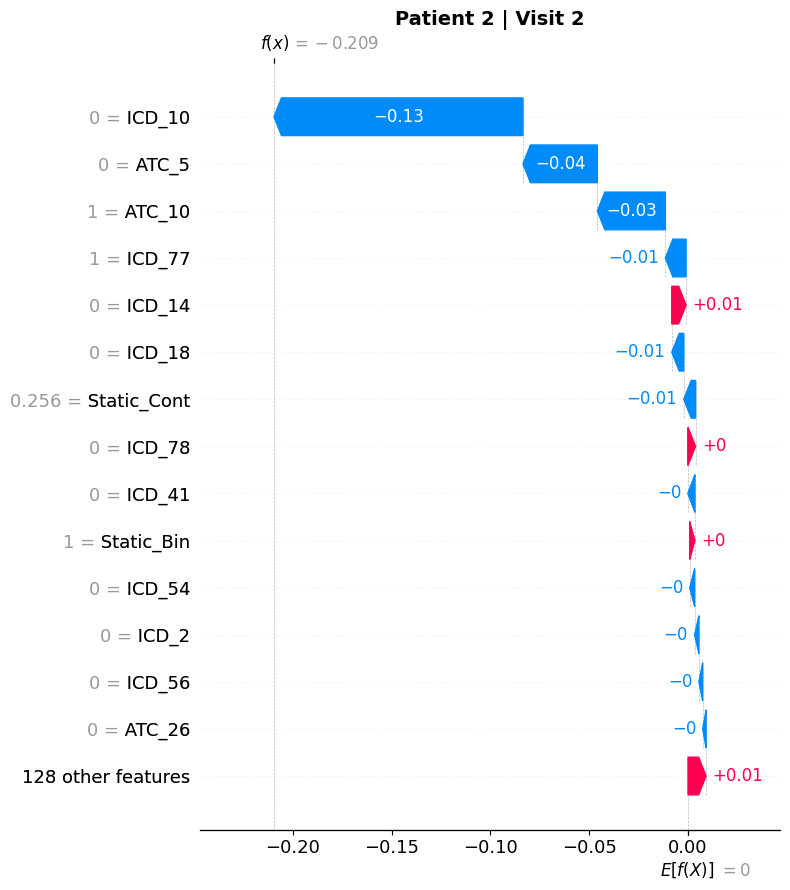

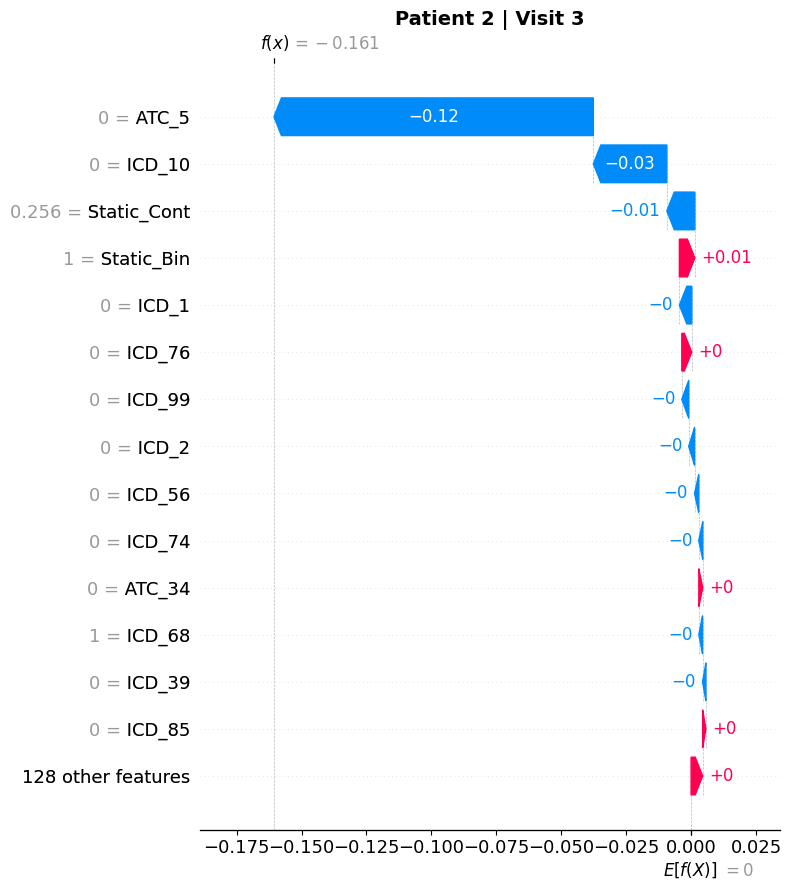

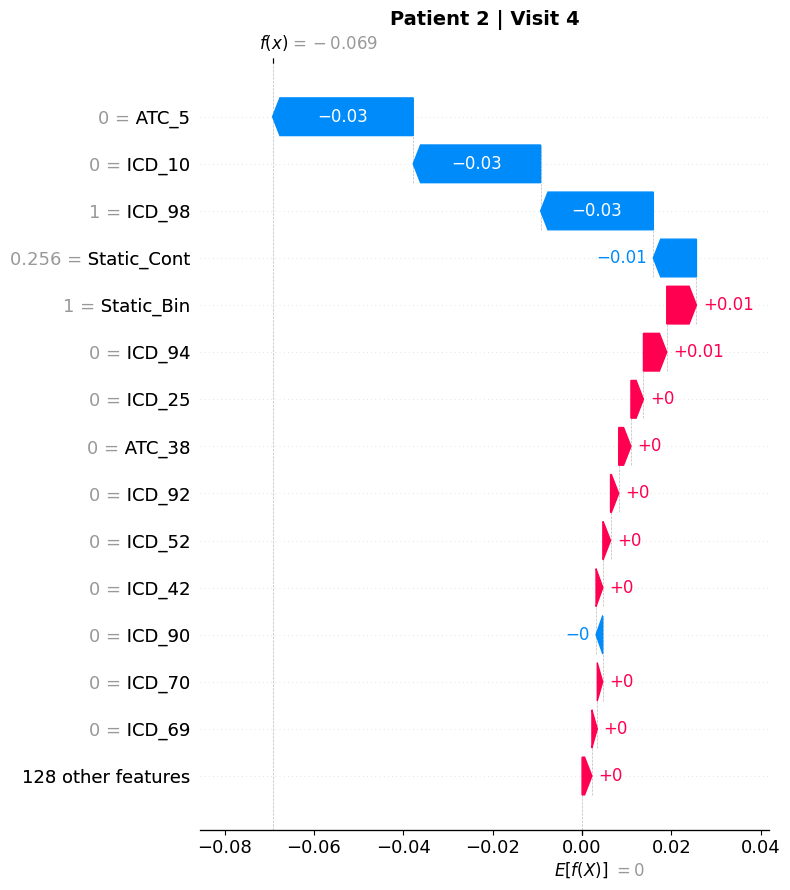

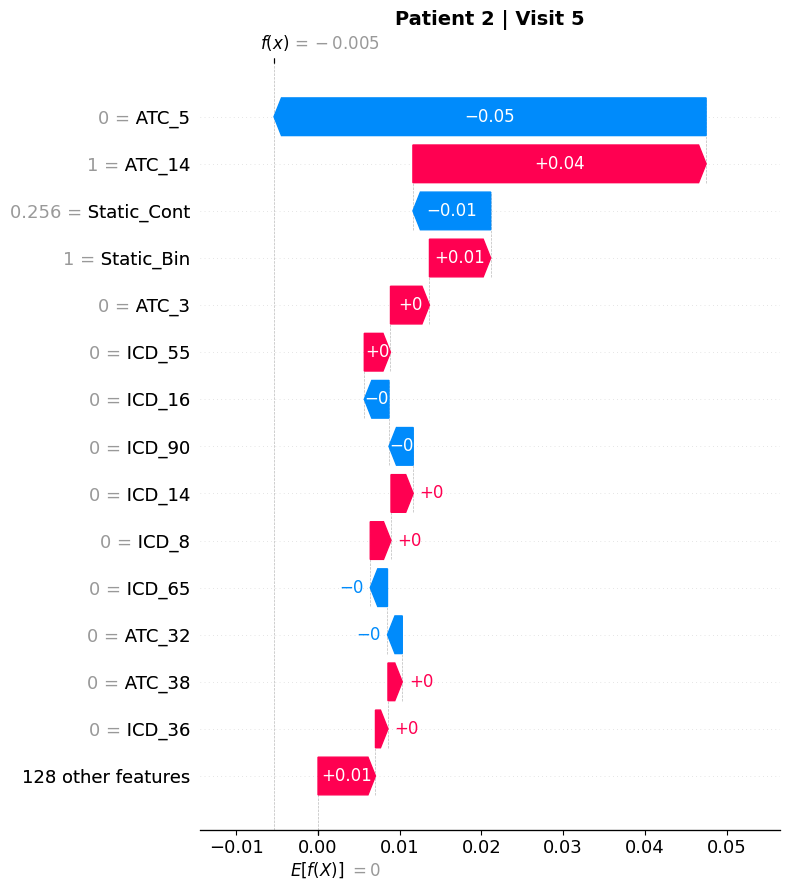

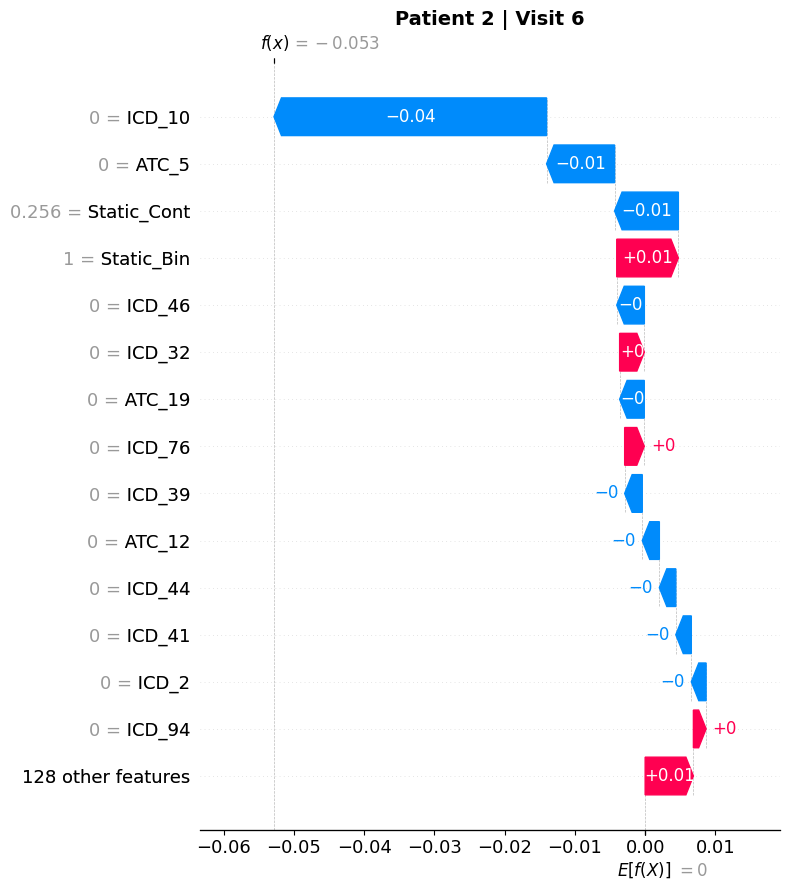

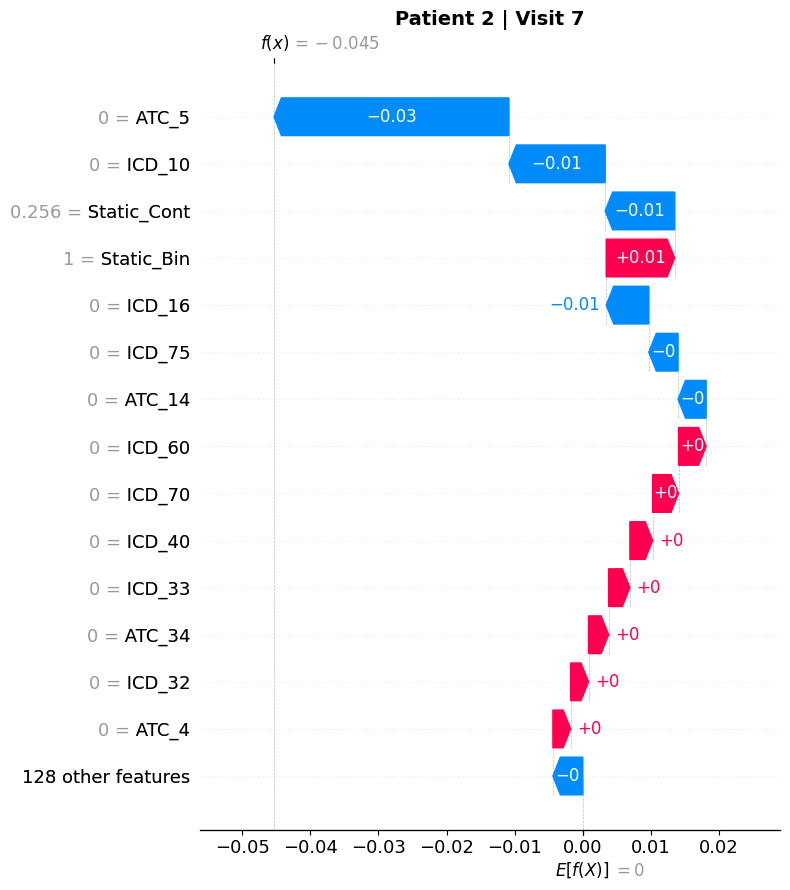

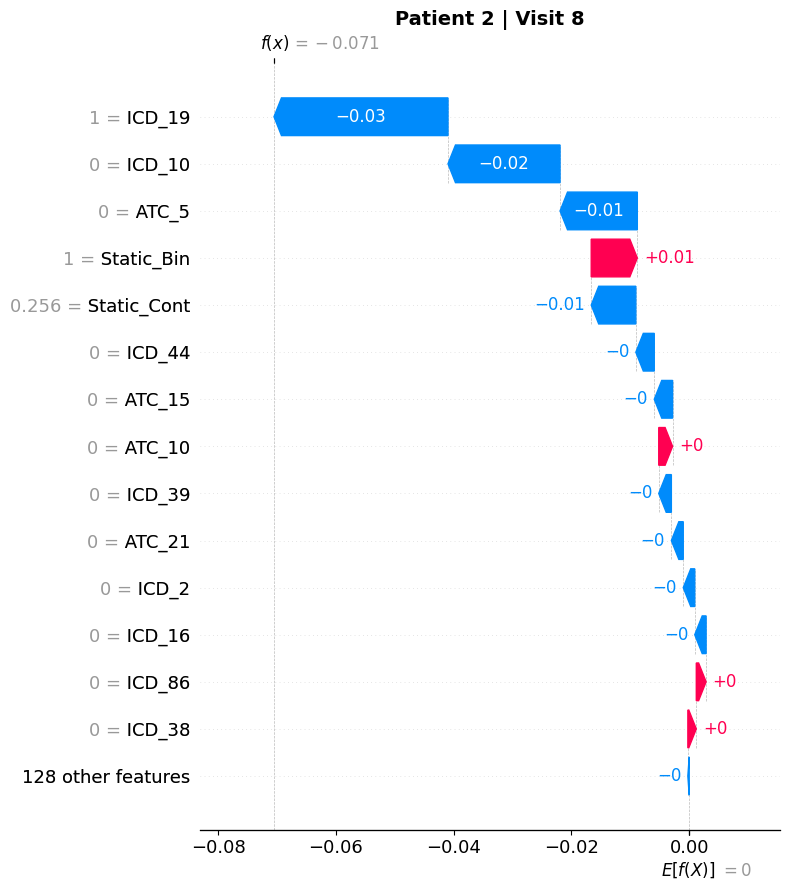

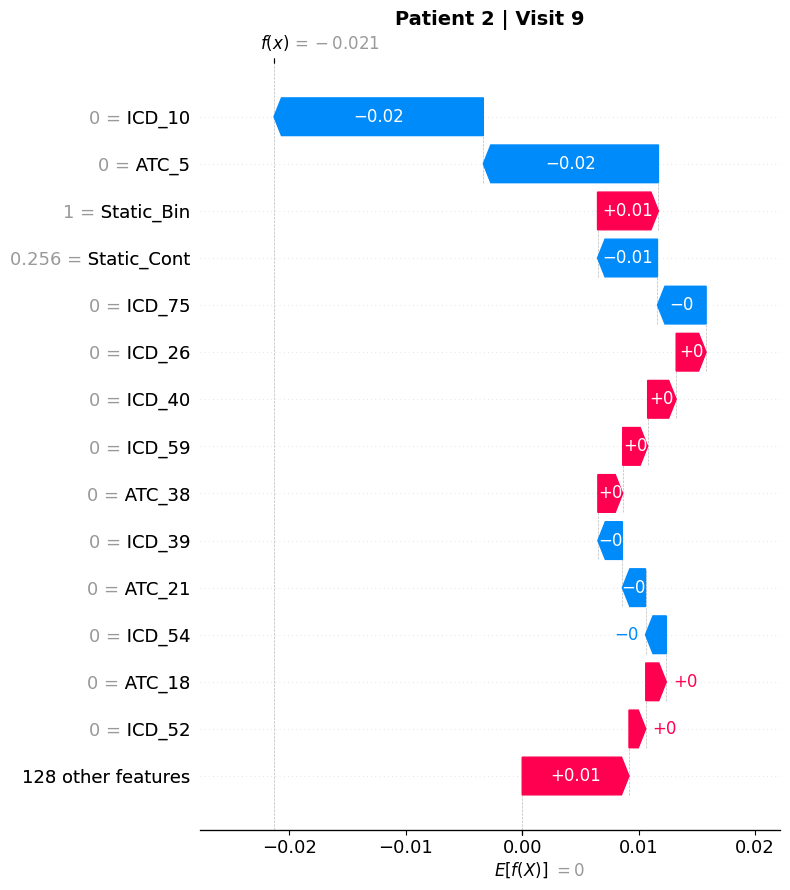

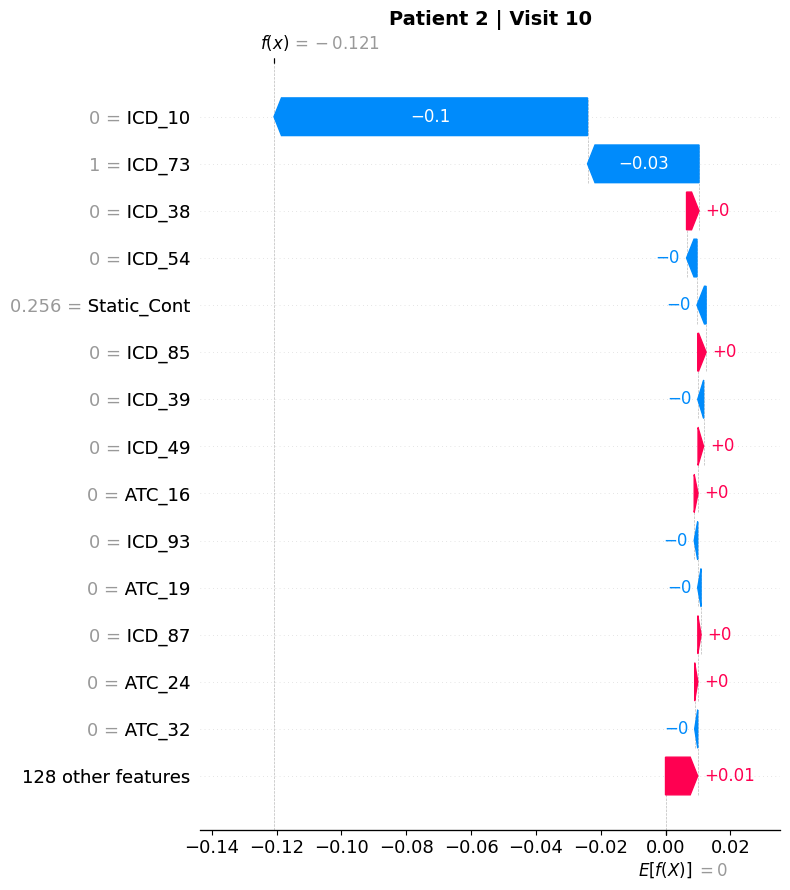

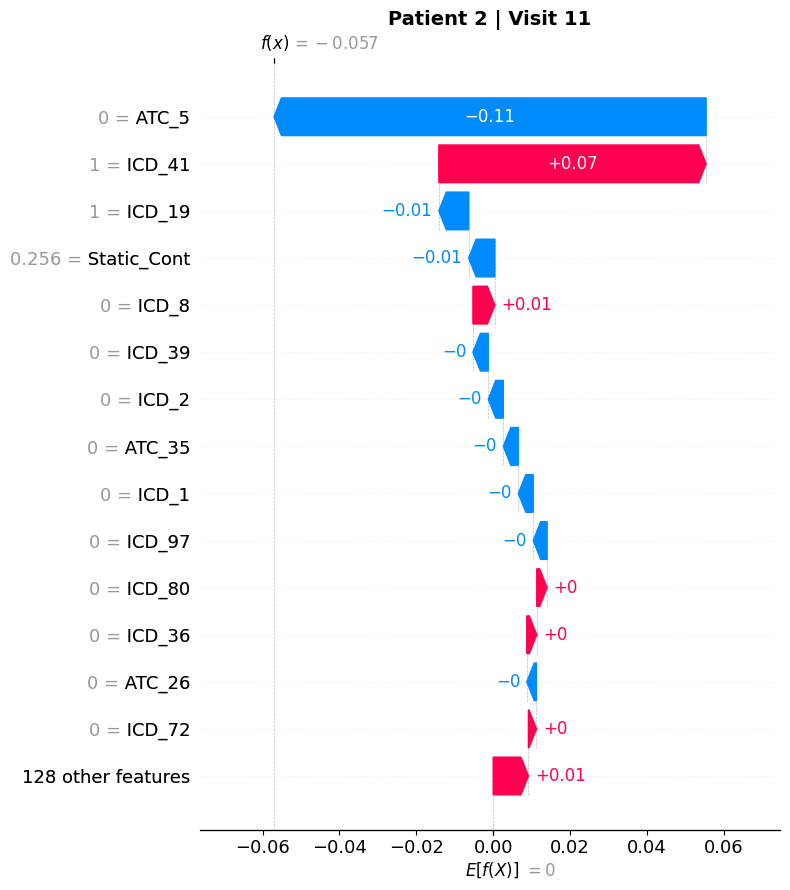

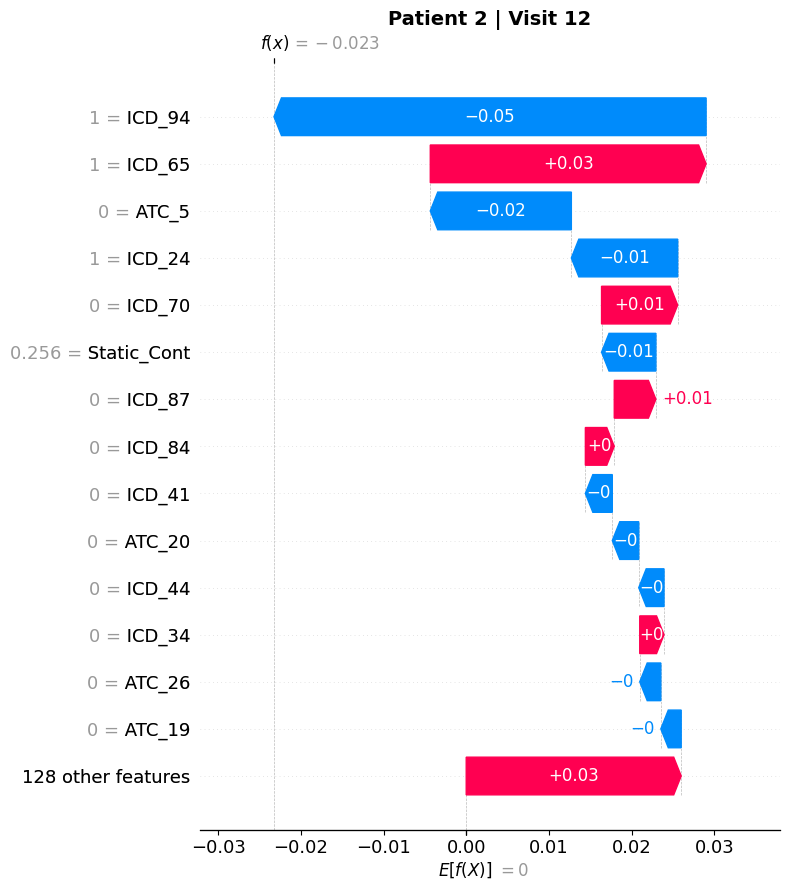

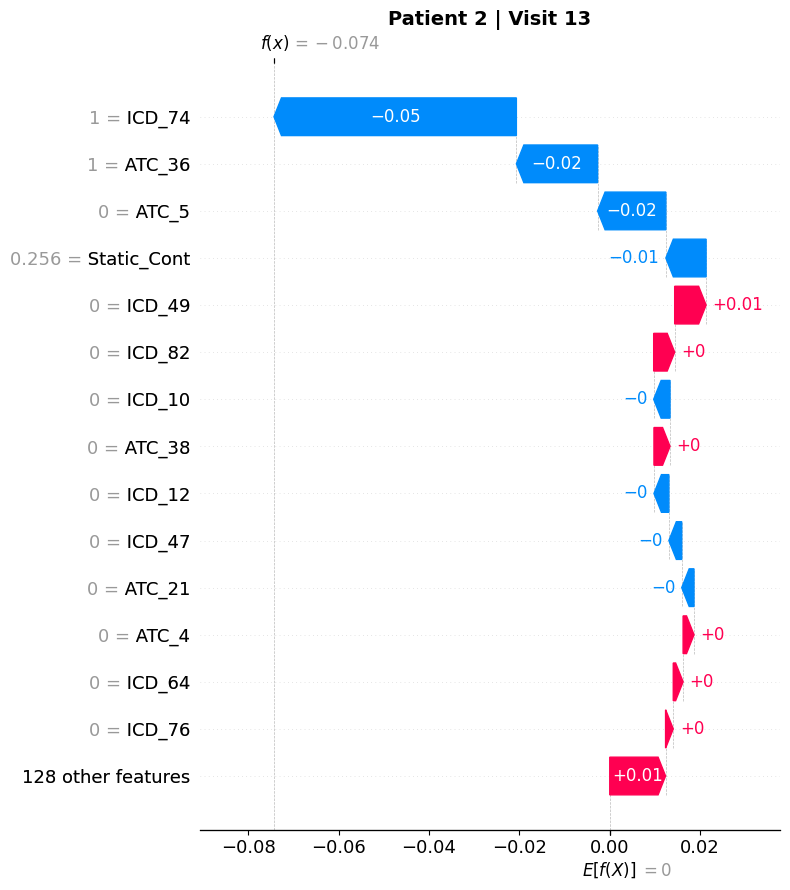

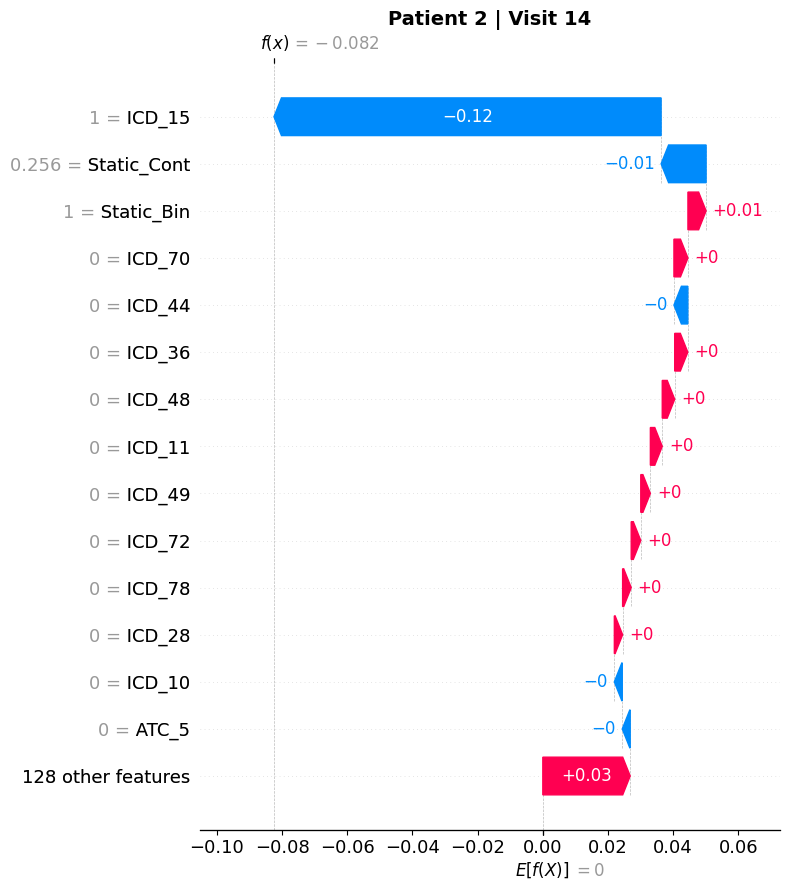

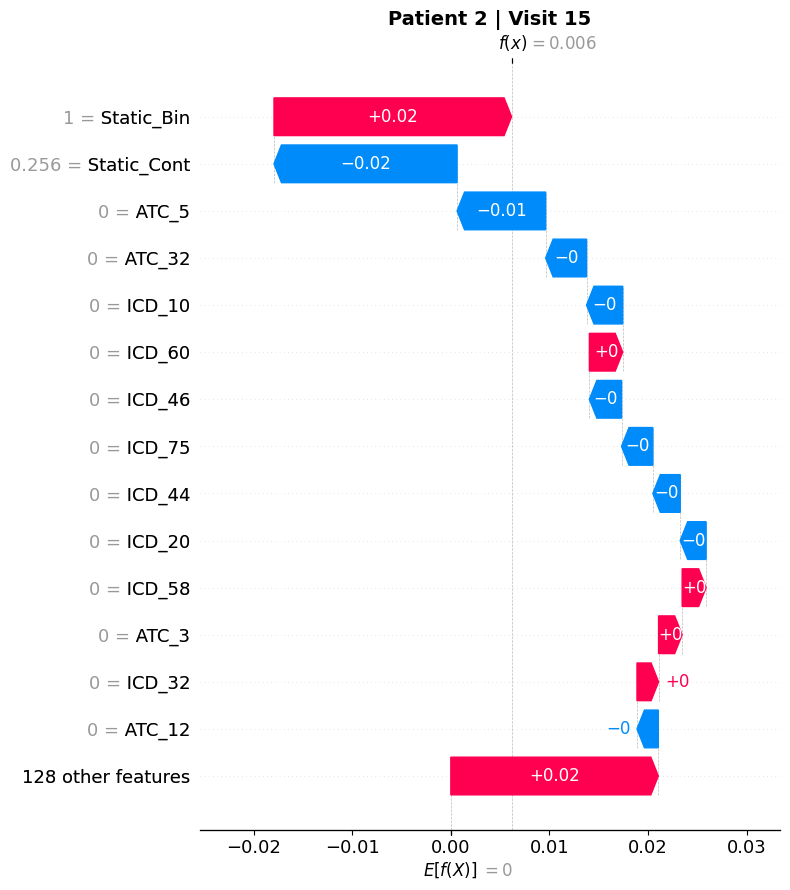

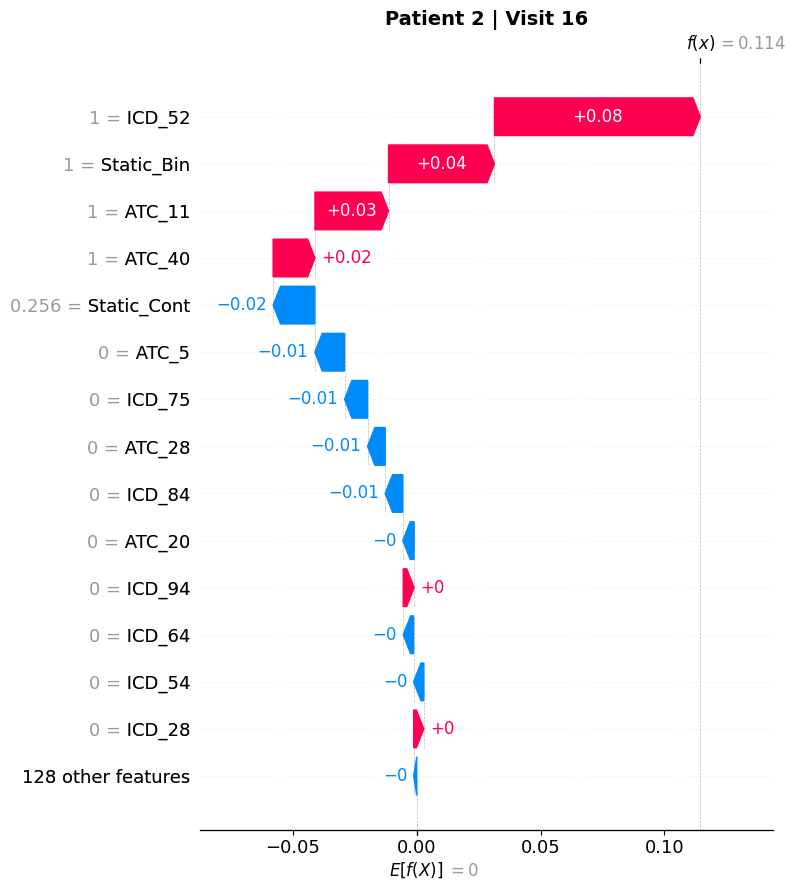

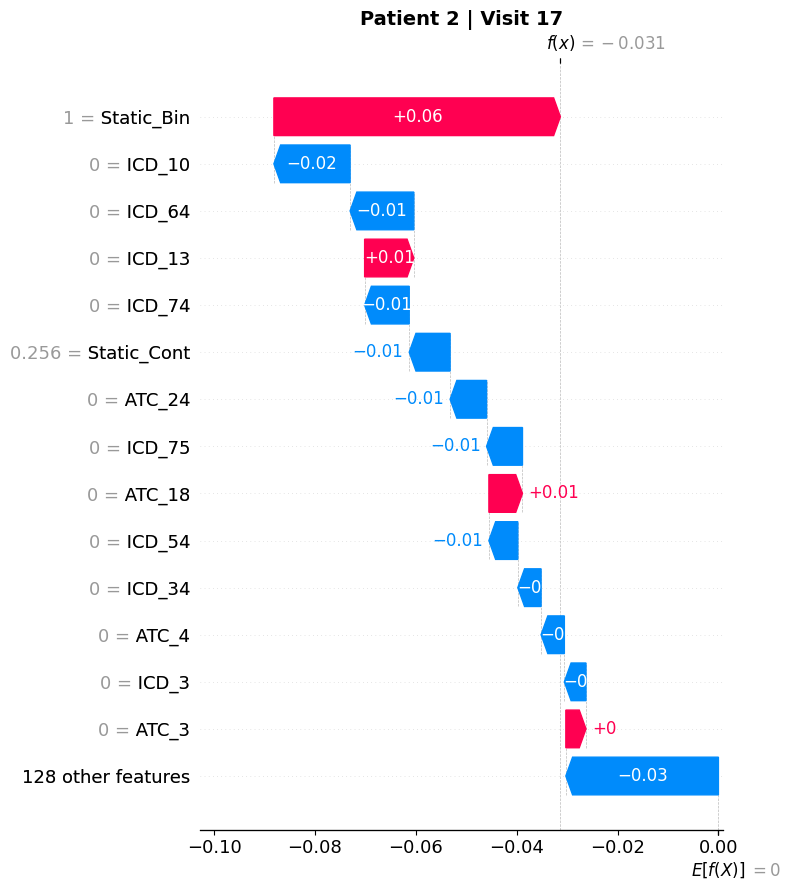

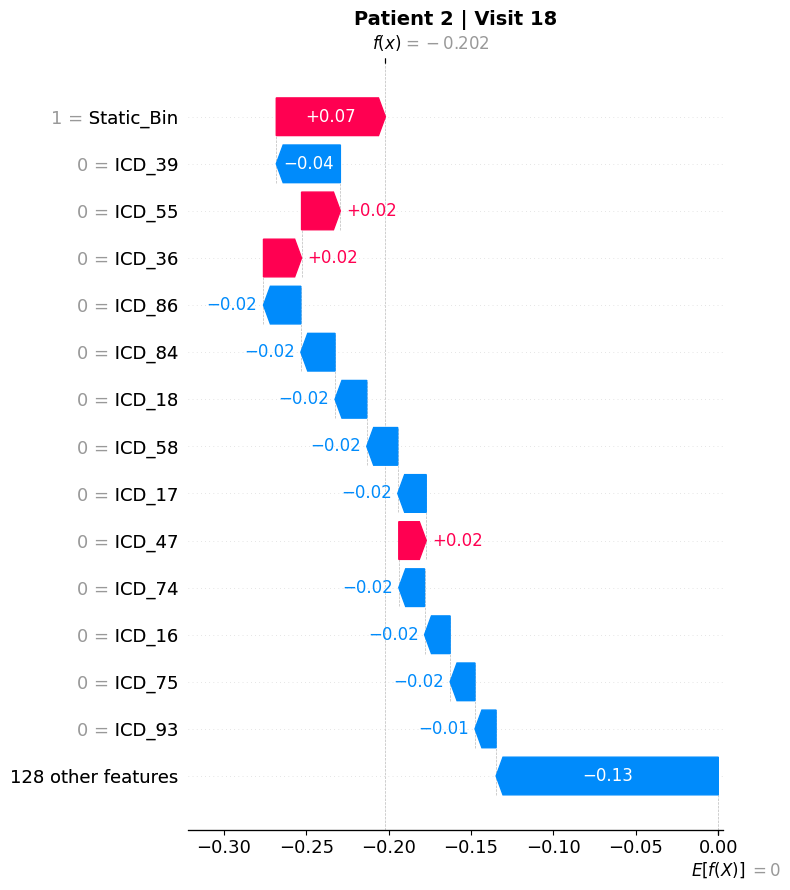

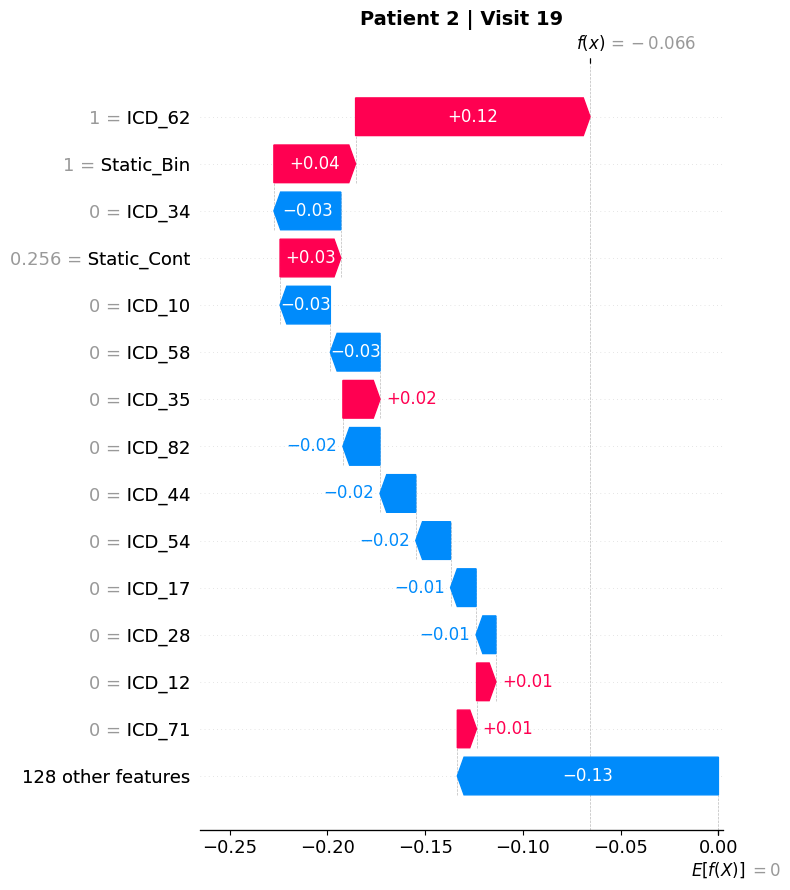

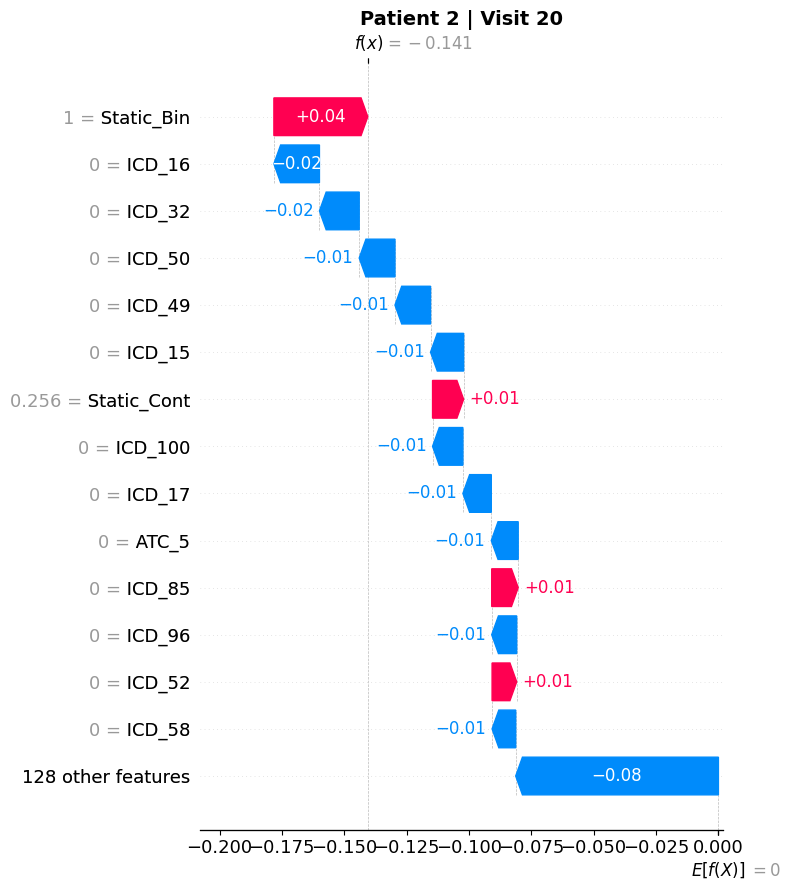

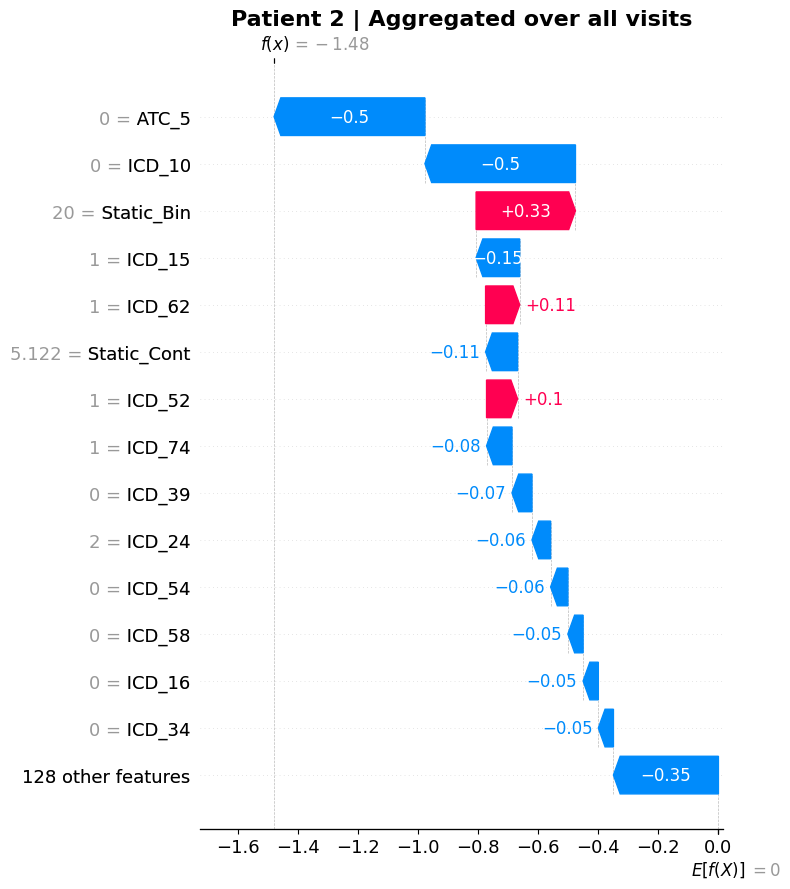

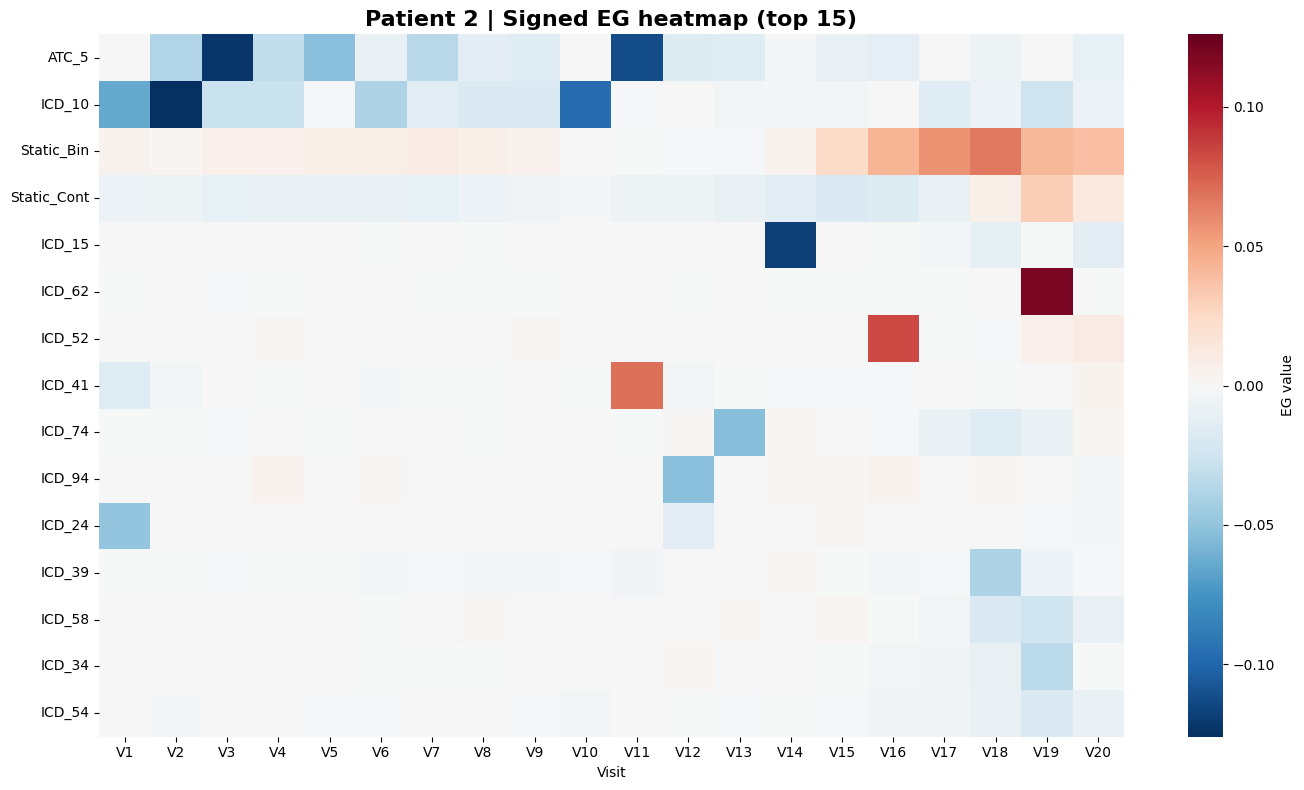

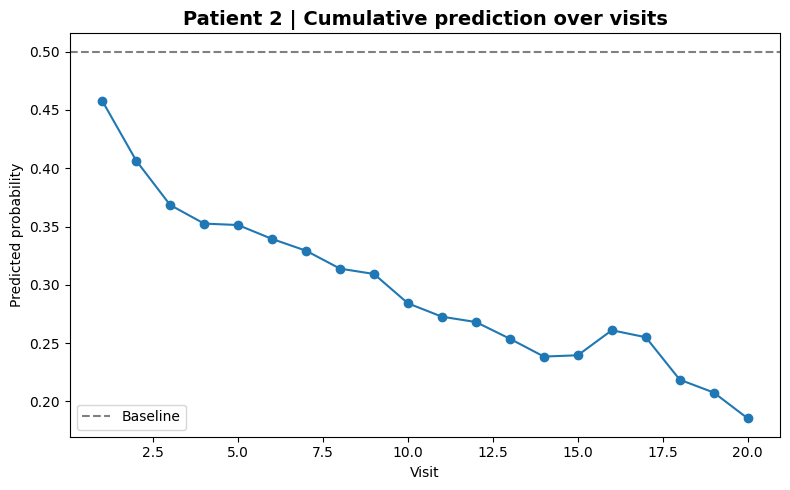

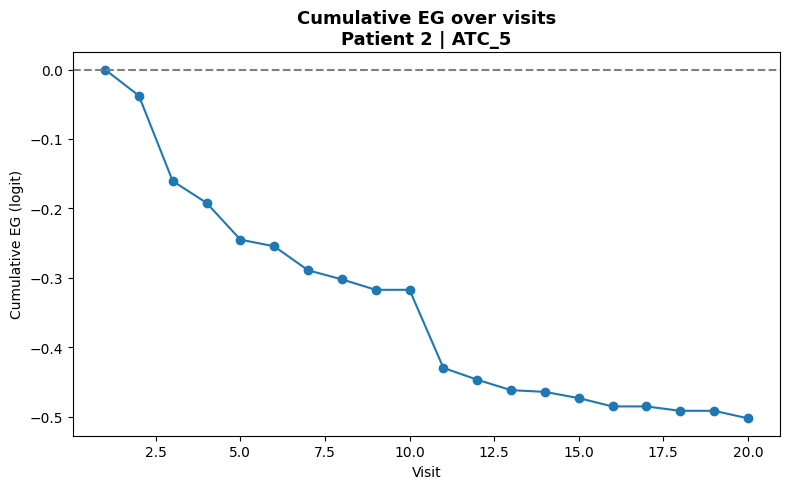


--- EG local plots | LSTM | patient 2 ---


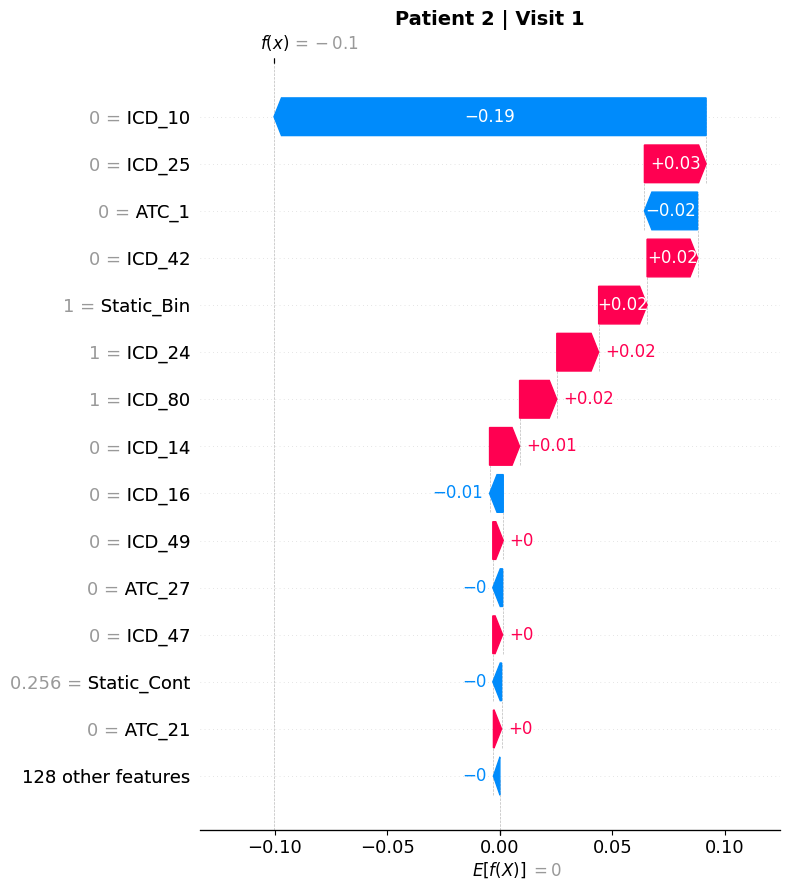

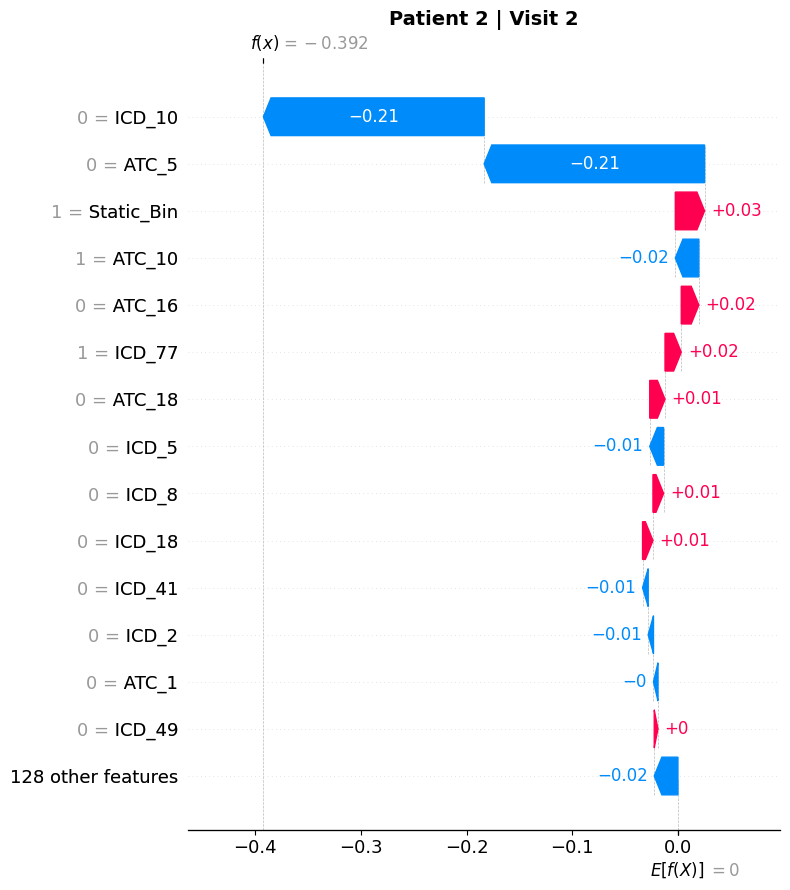

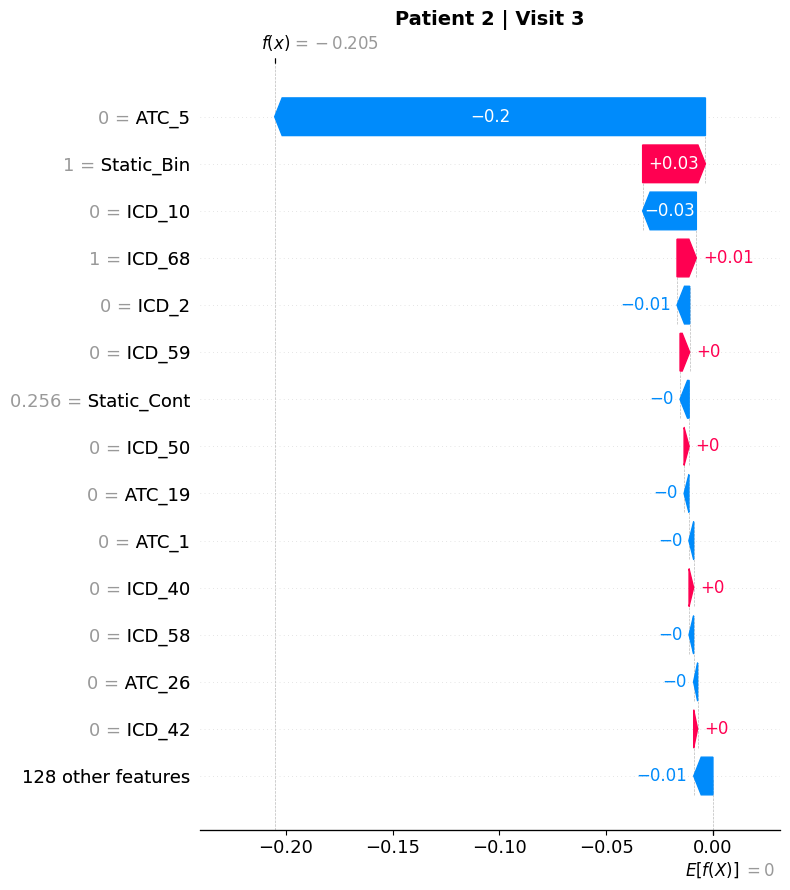

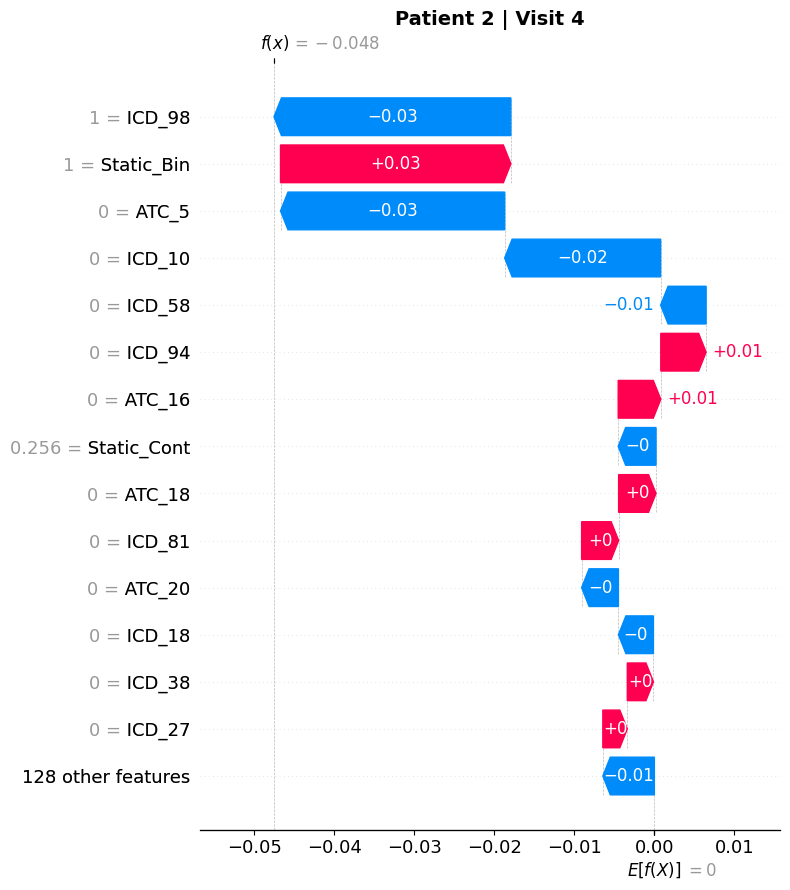

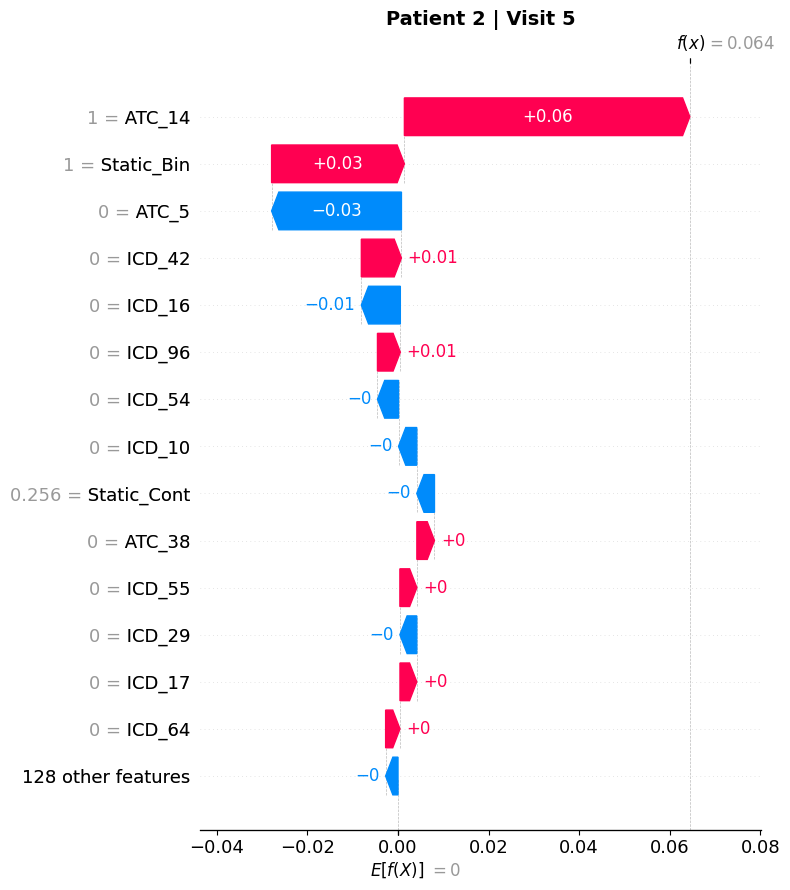

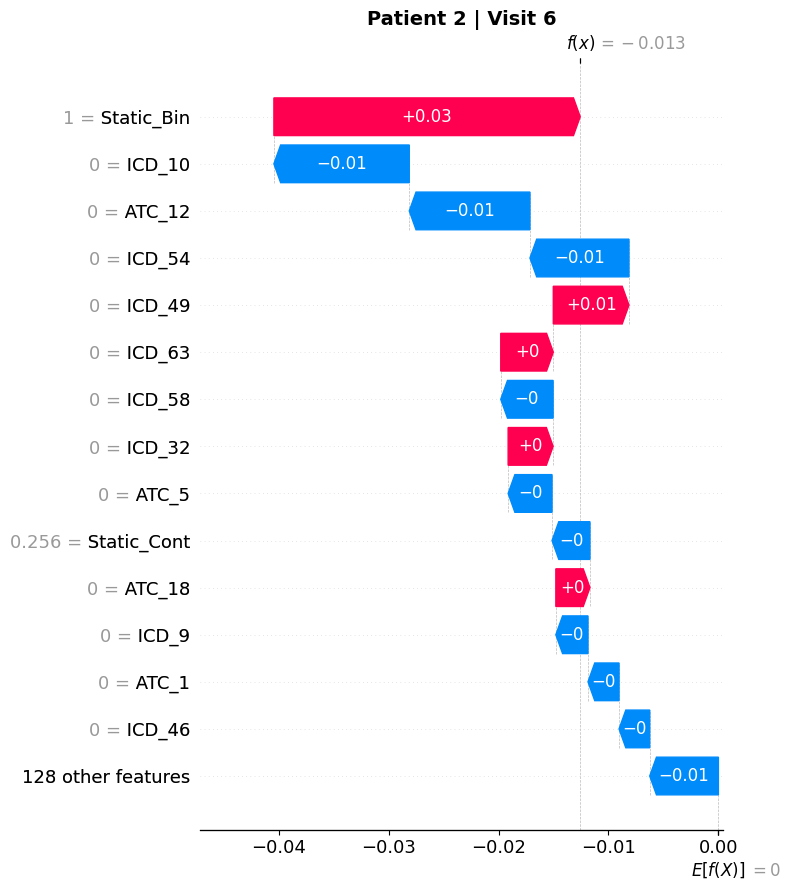

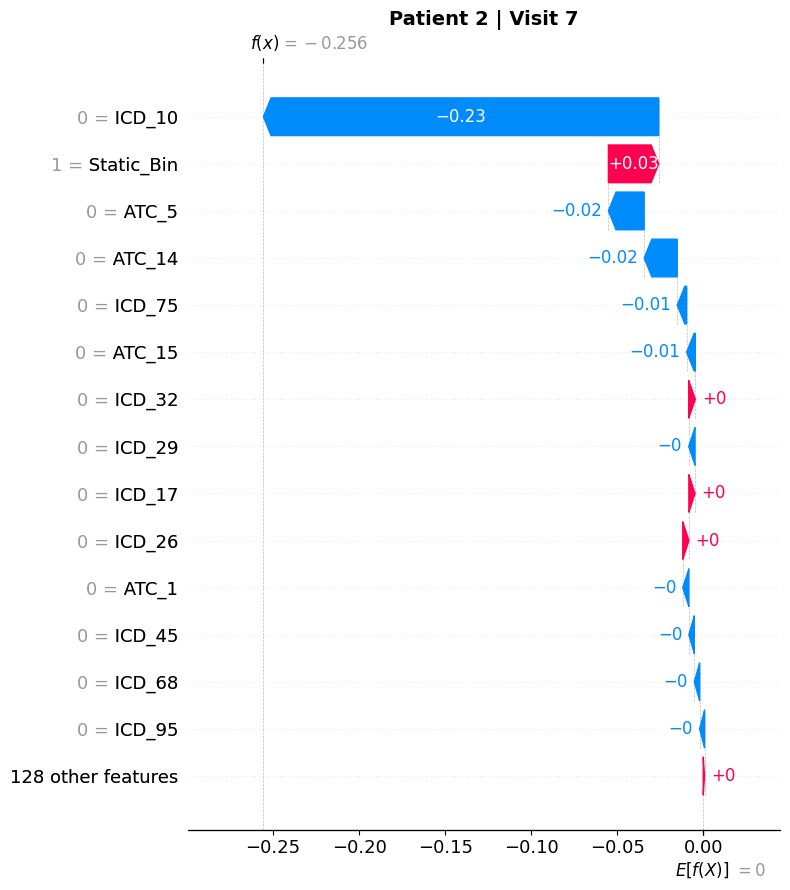

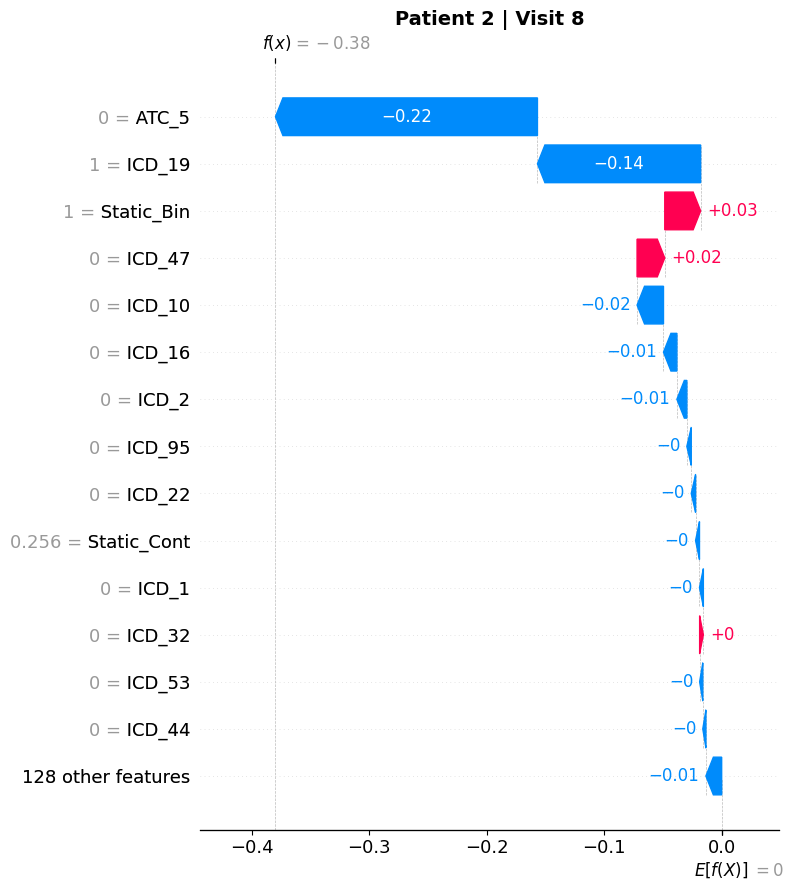

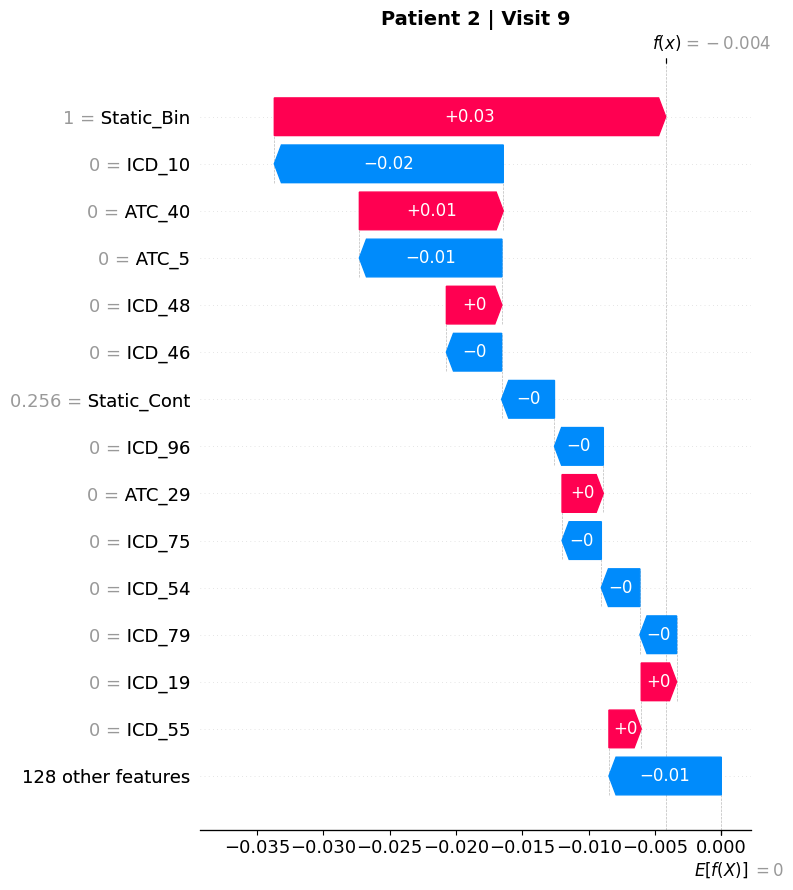

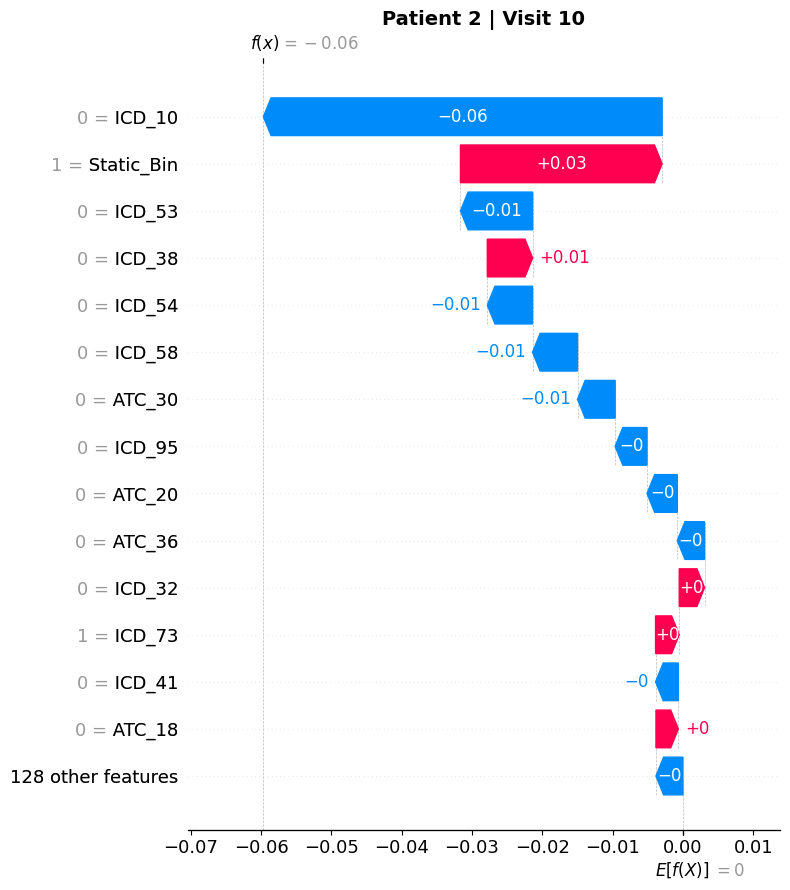

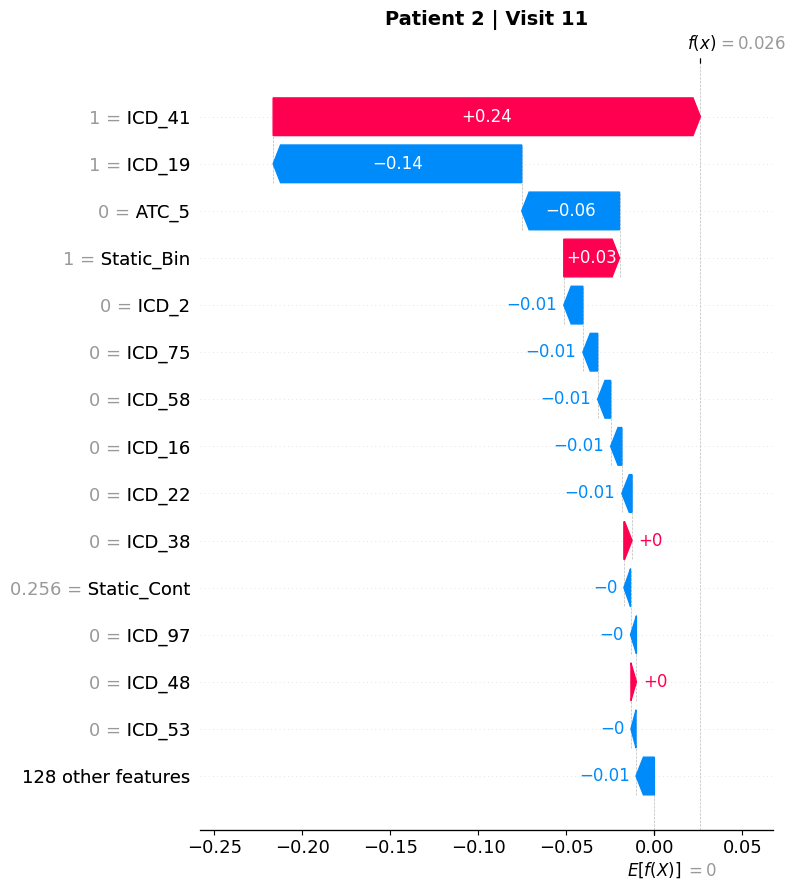

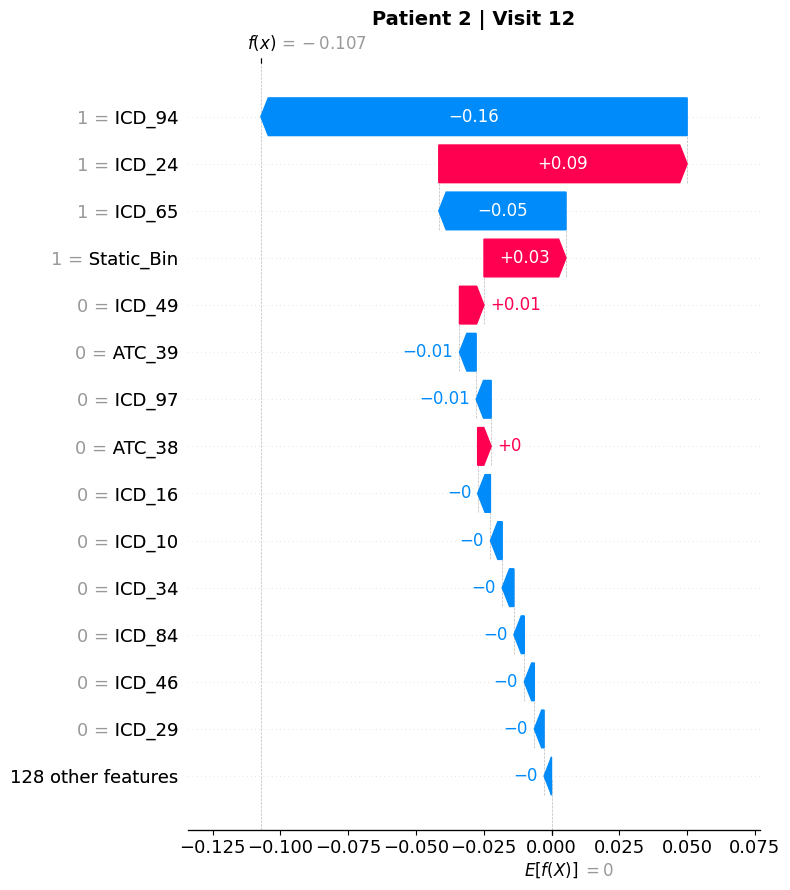

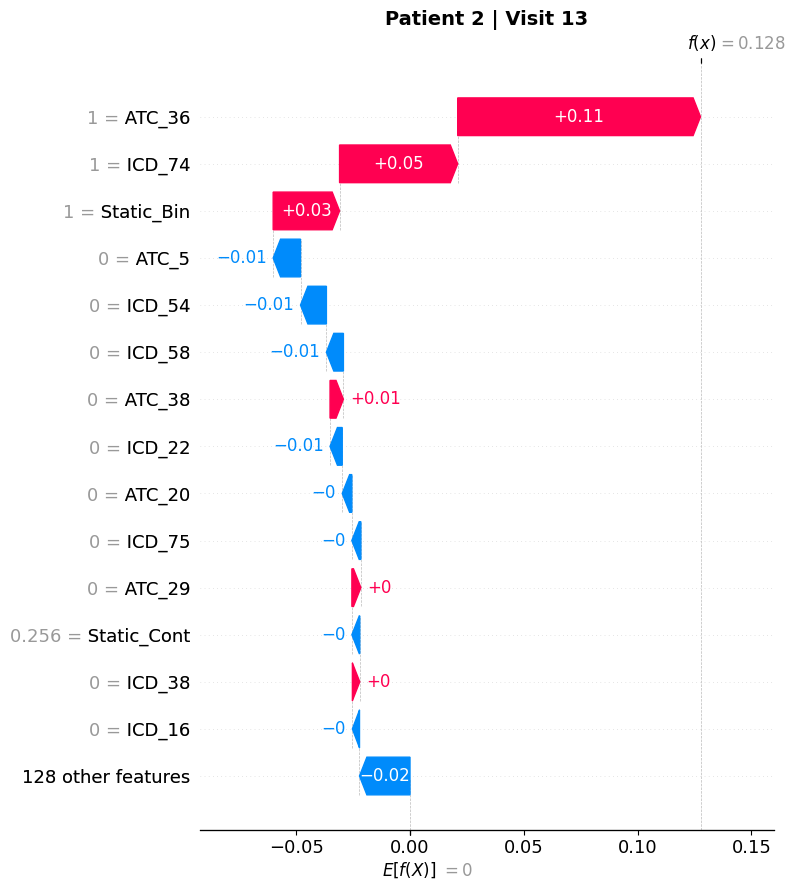

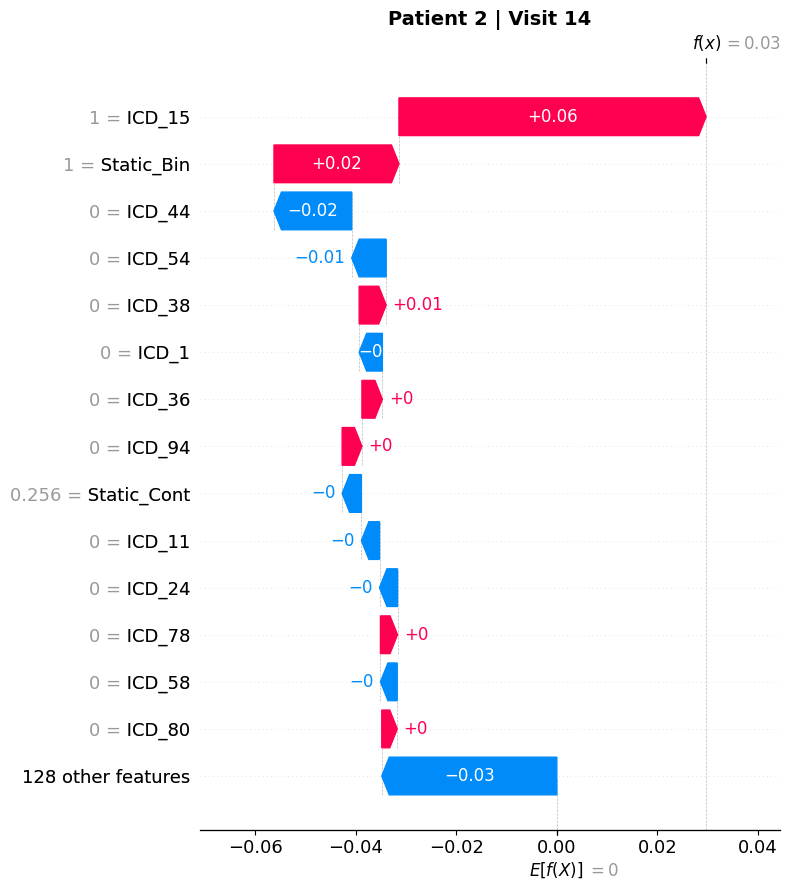

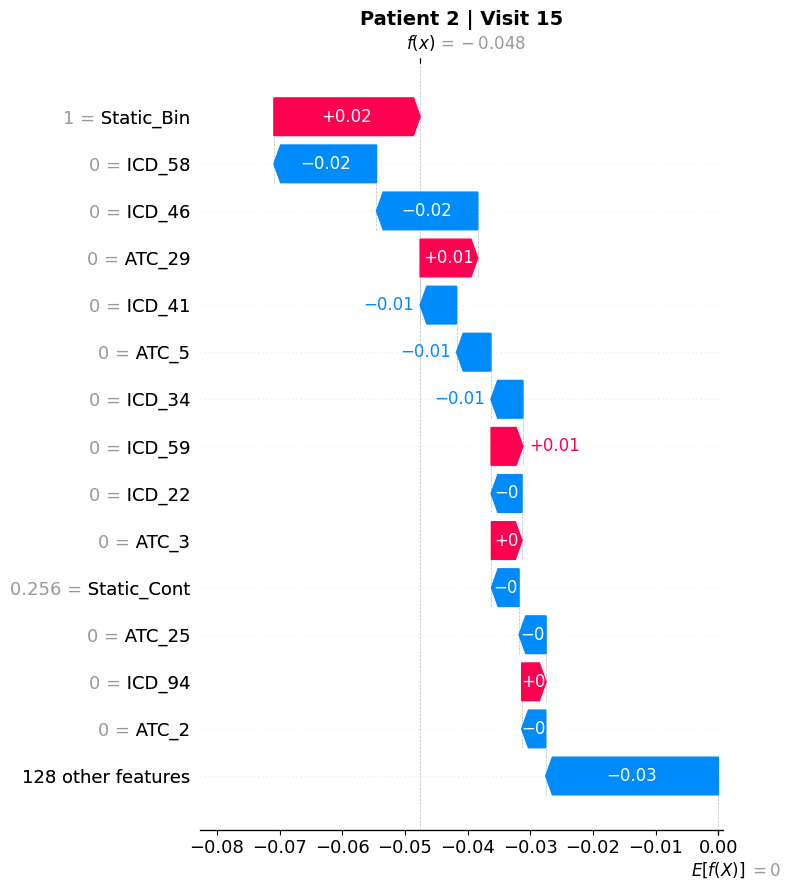

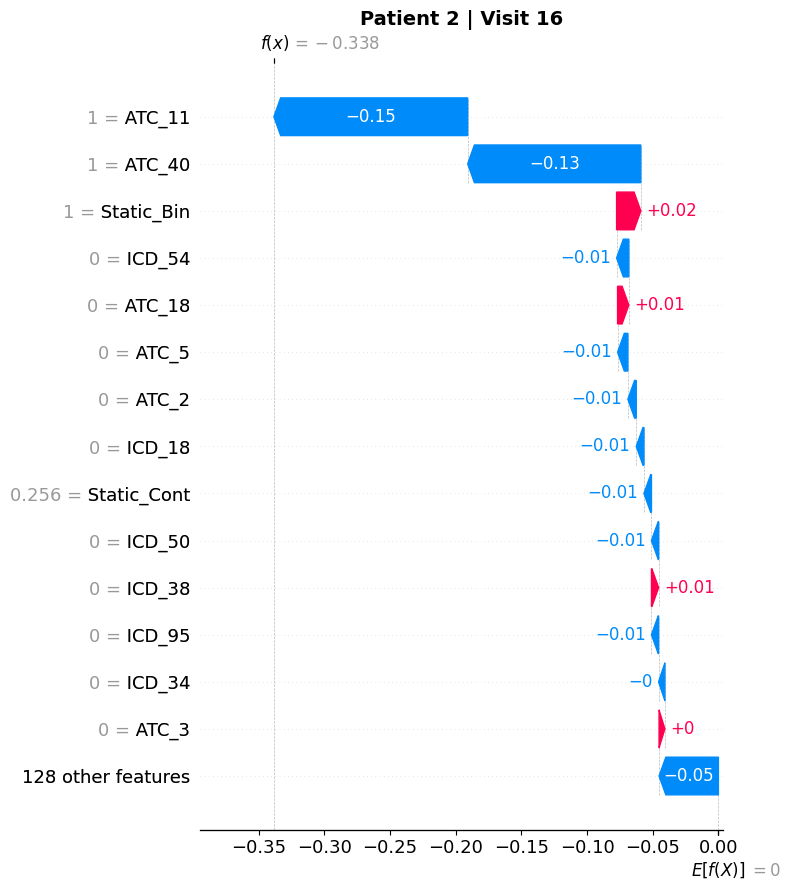

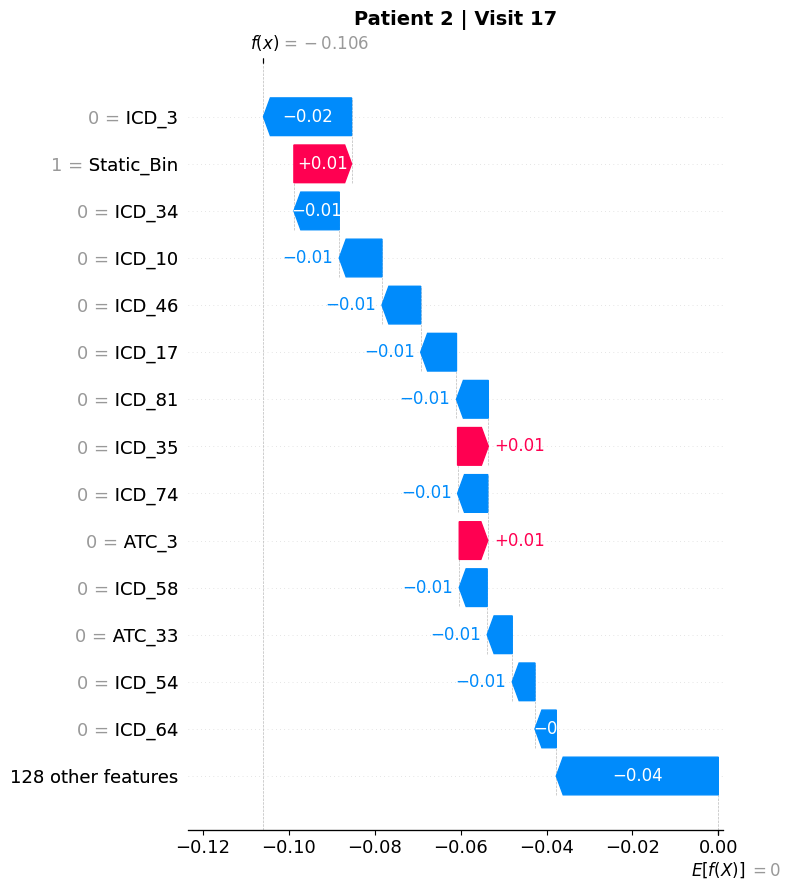

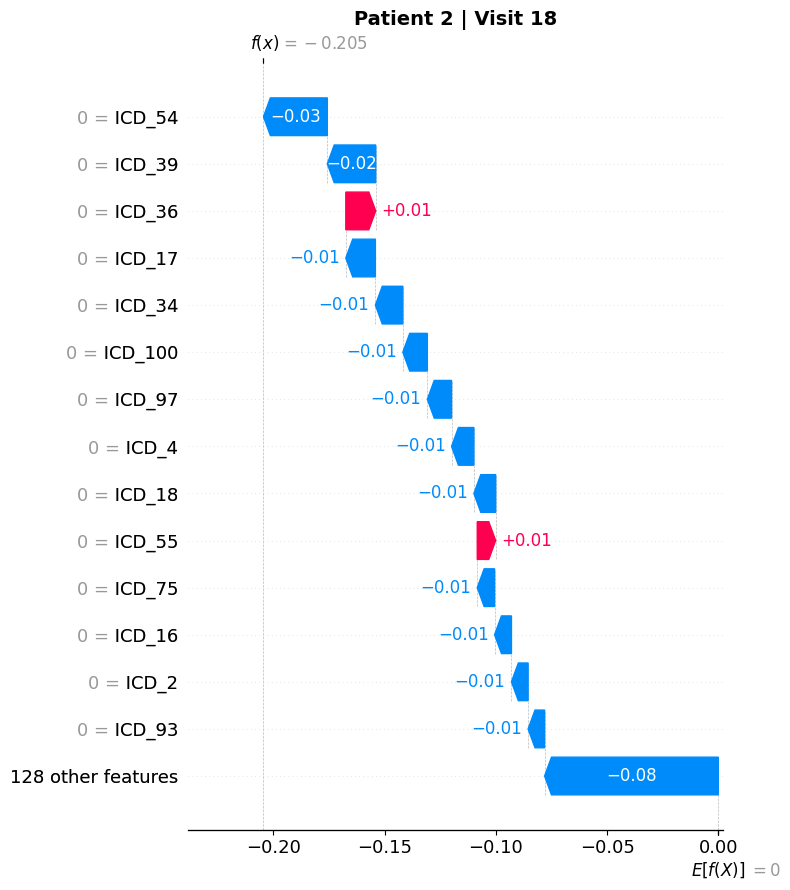

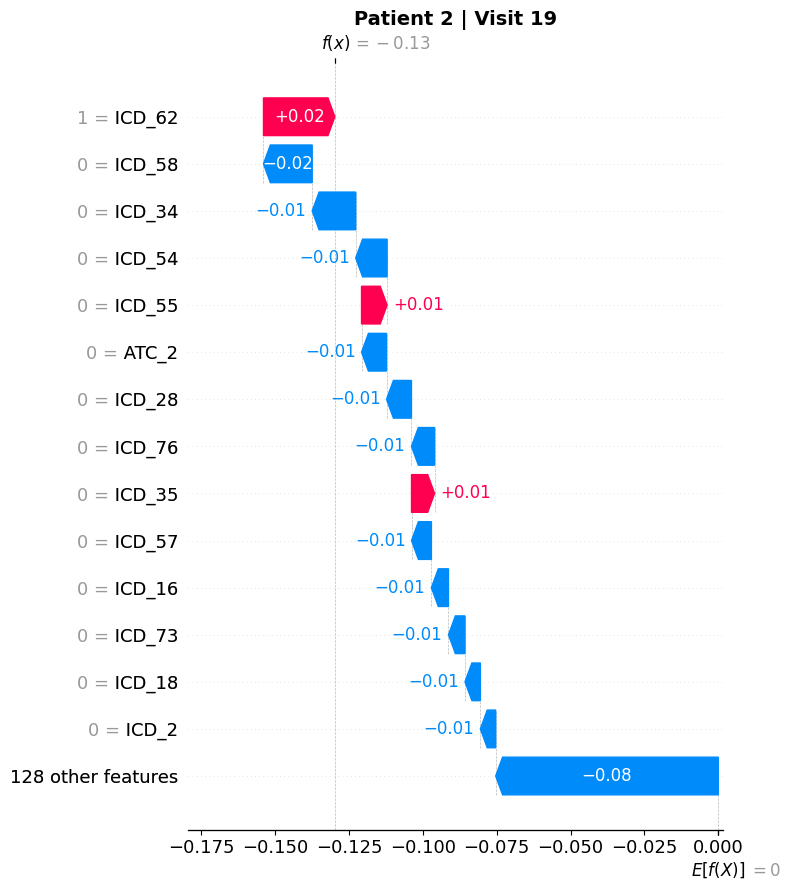

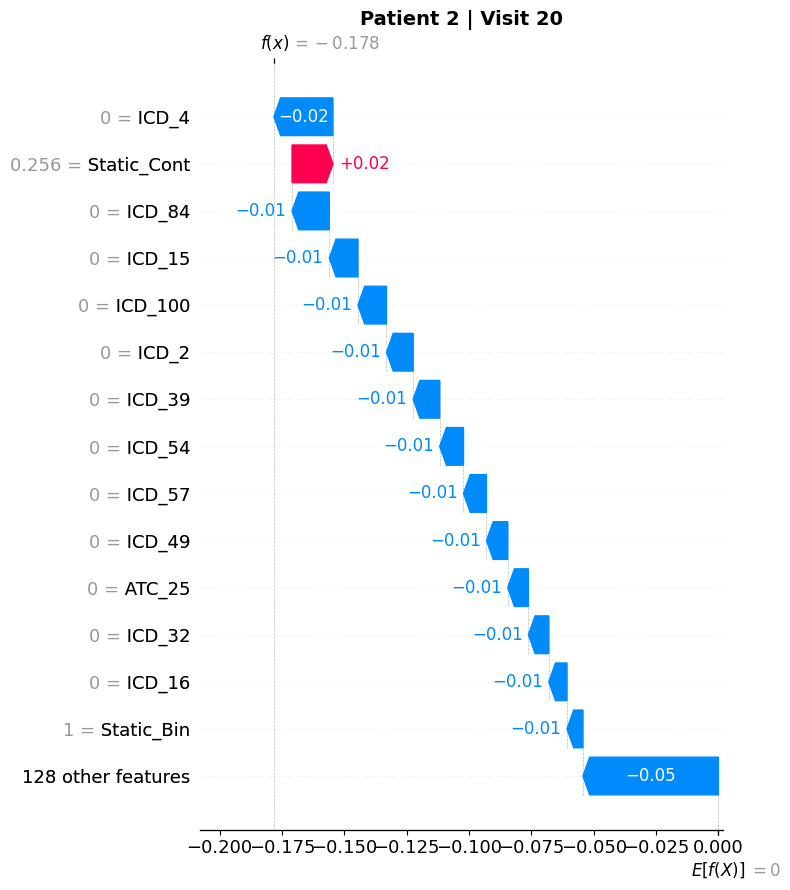

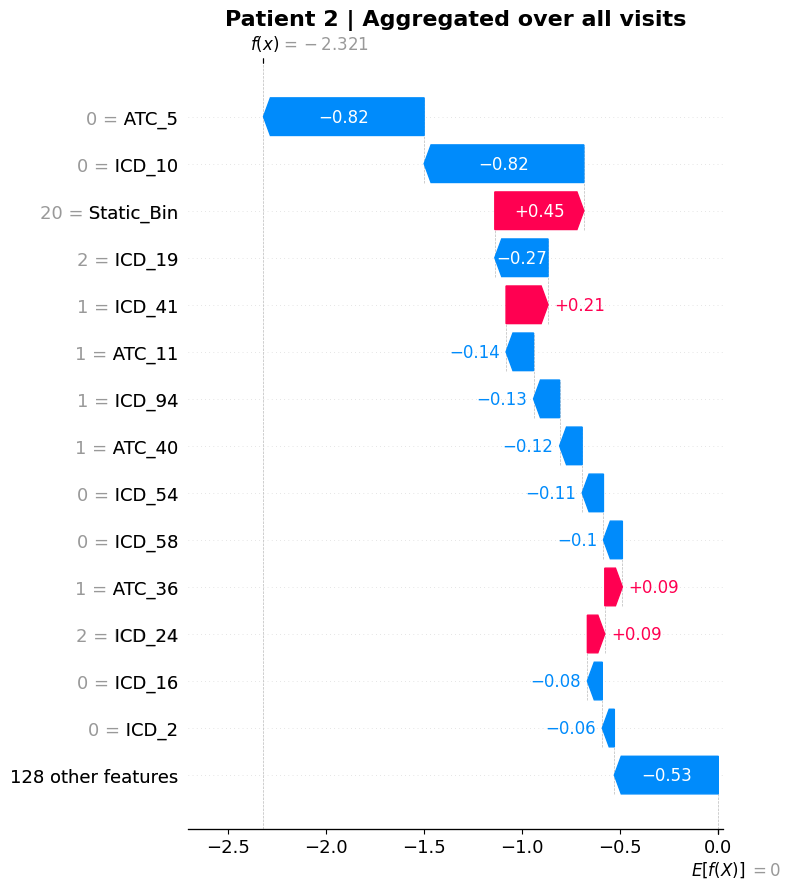

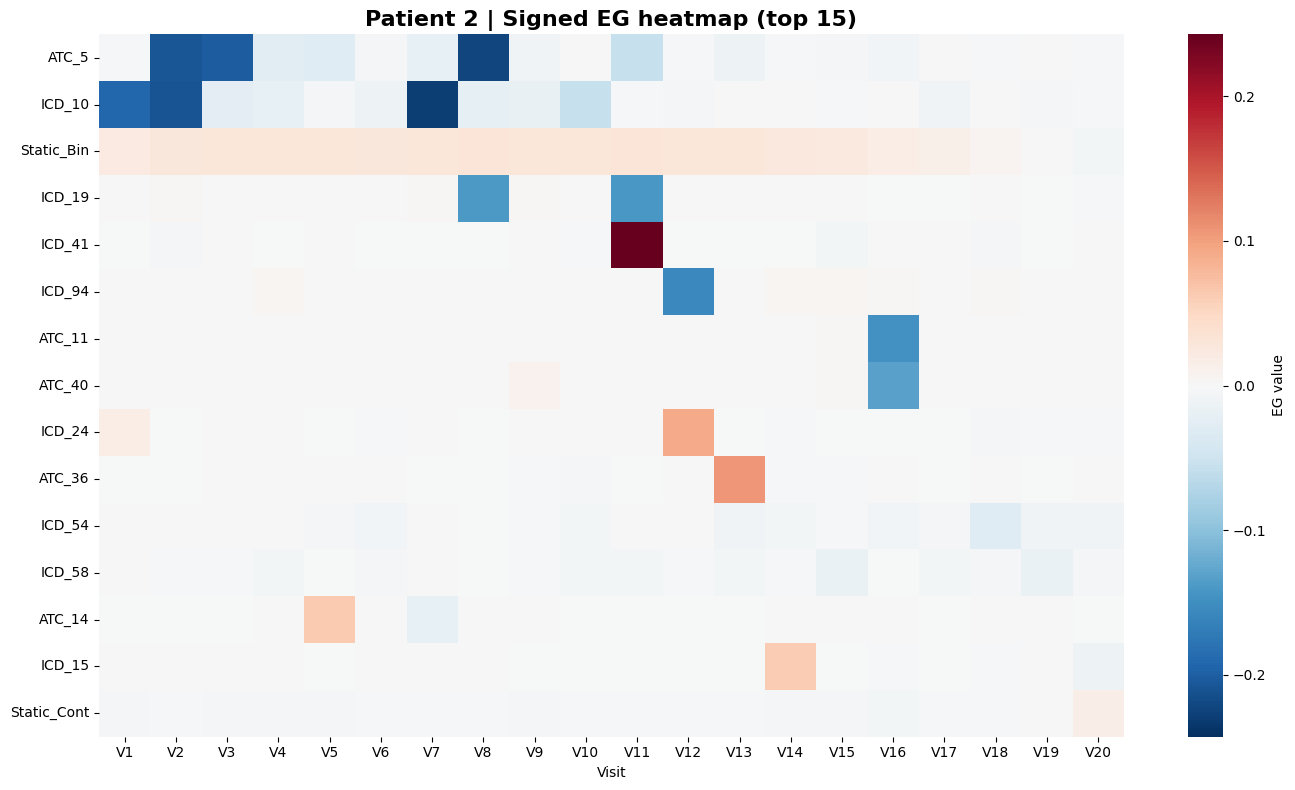

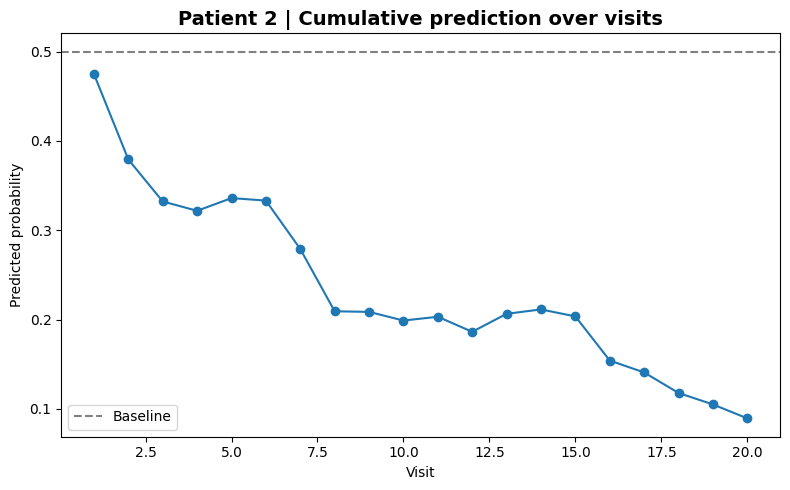

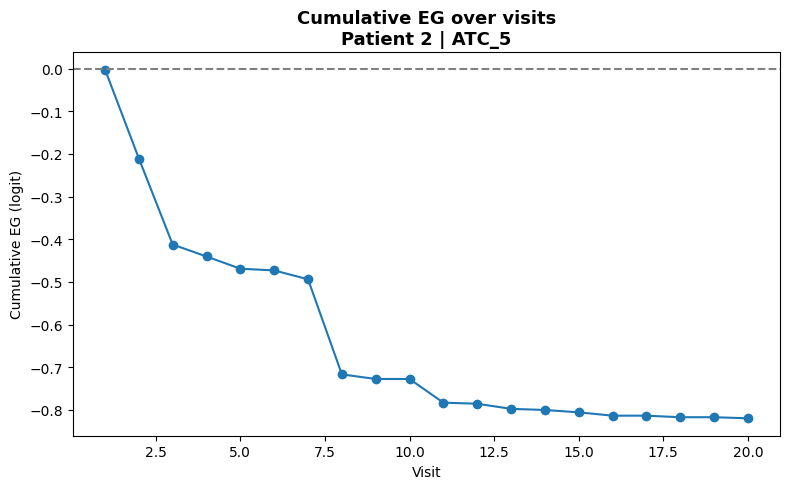

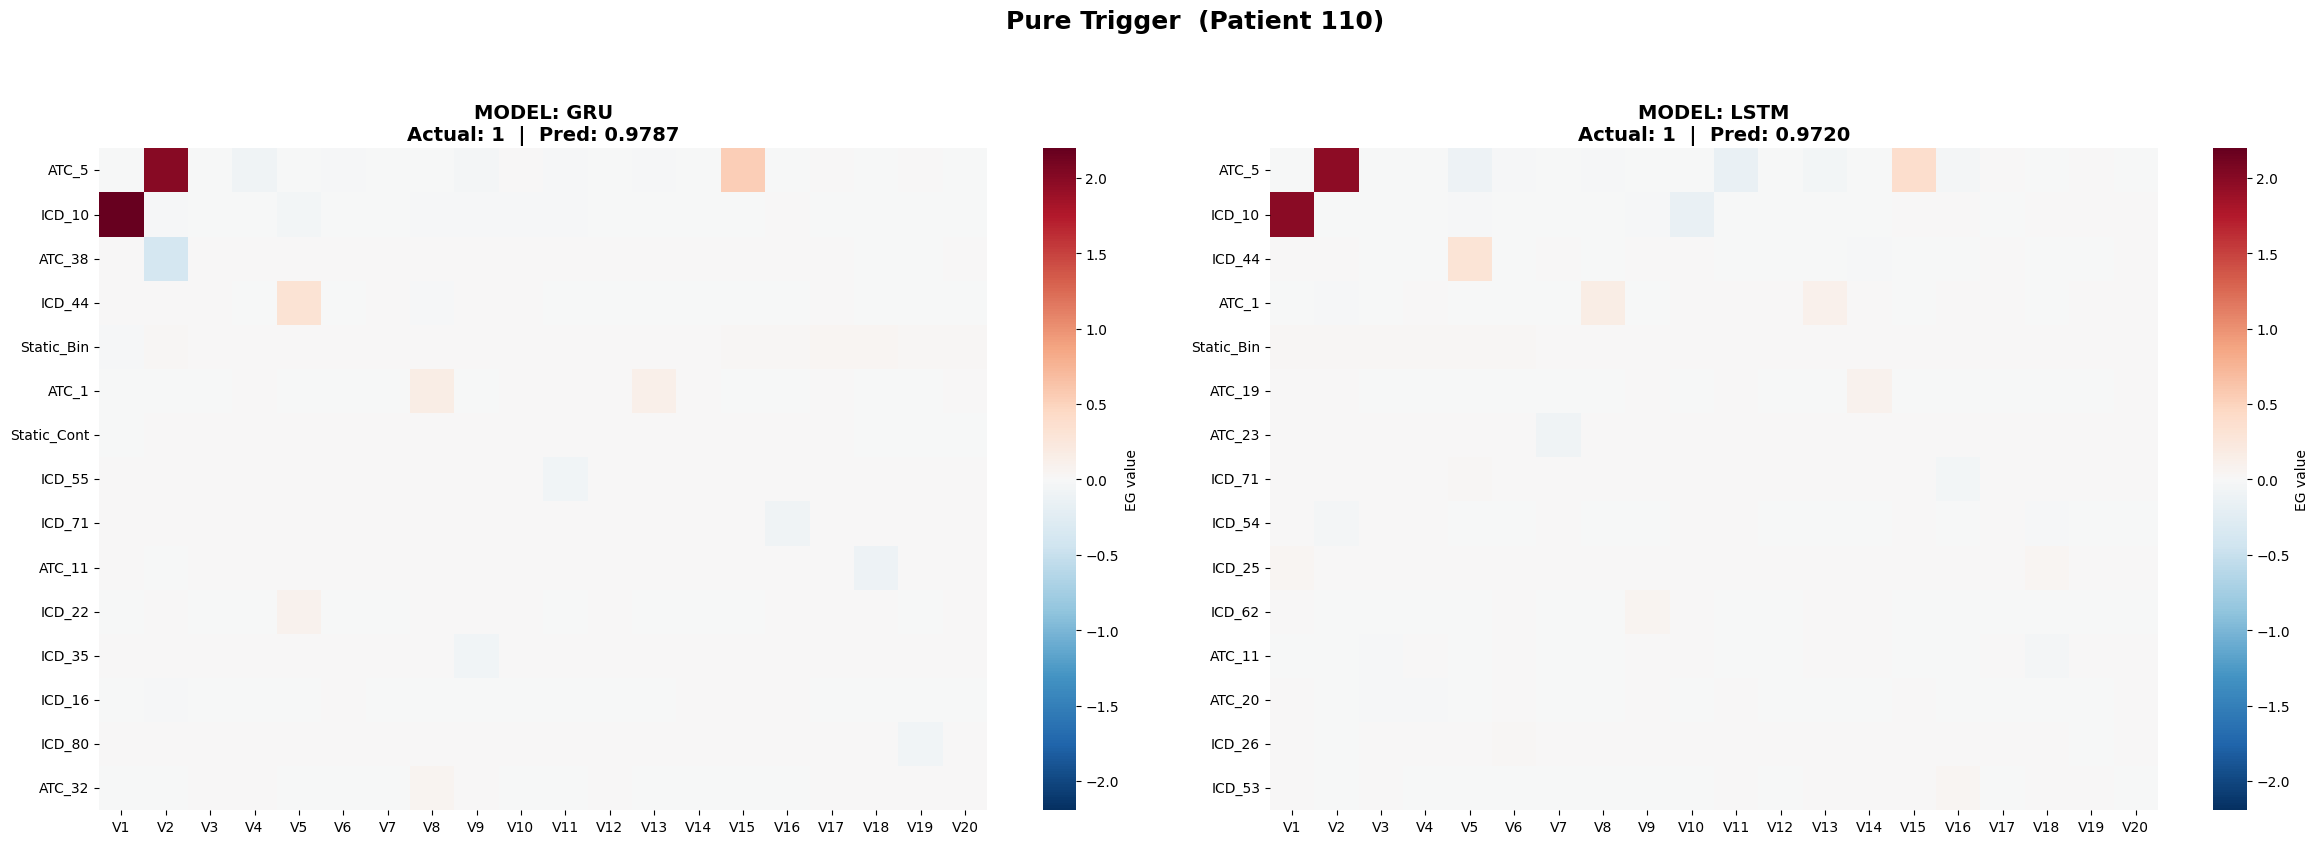

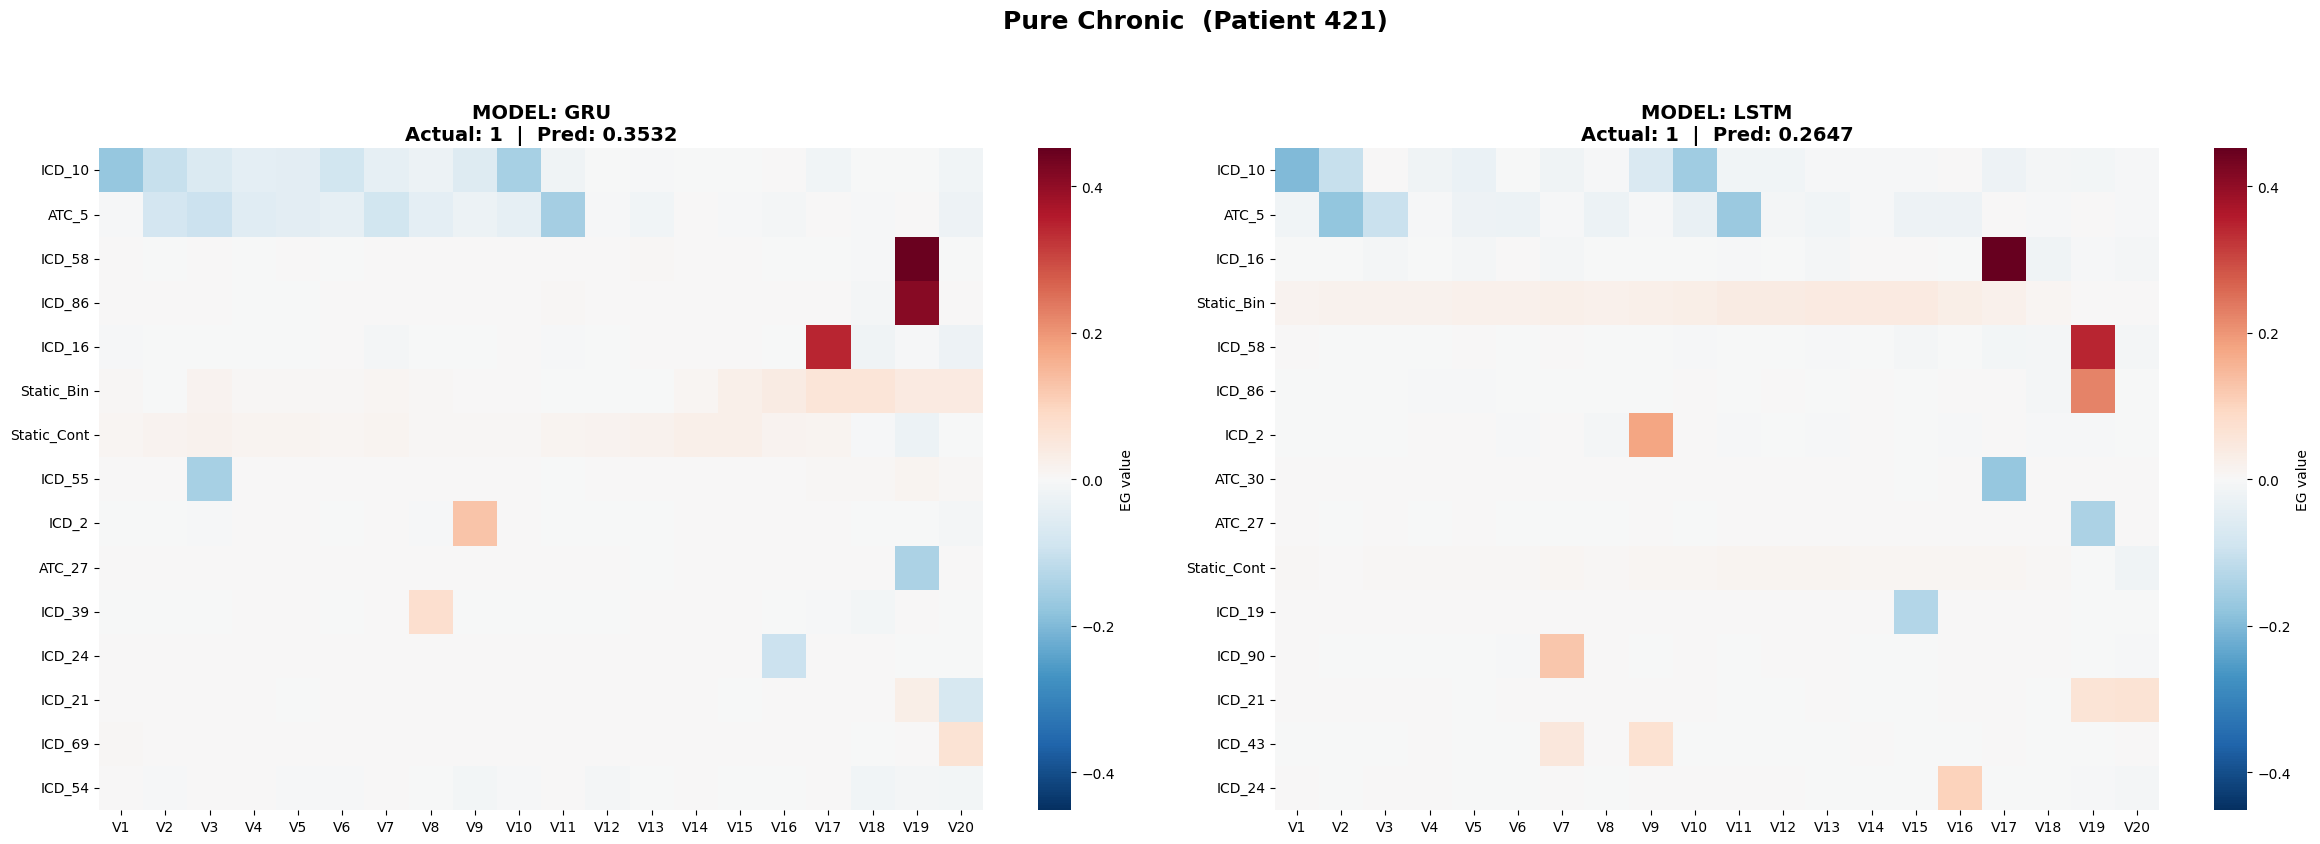

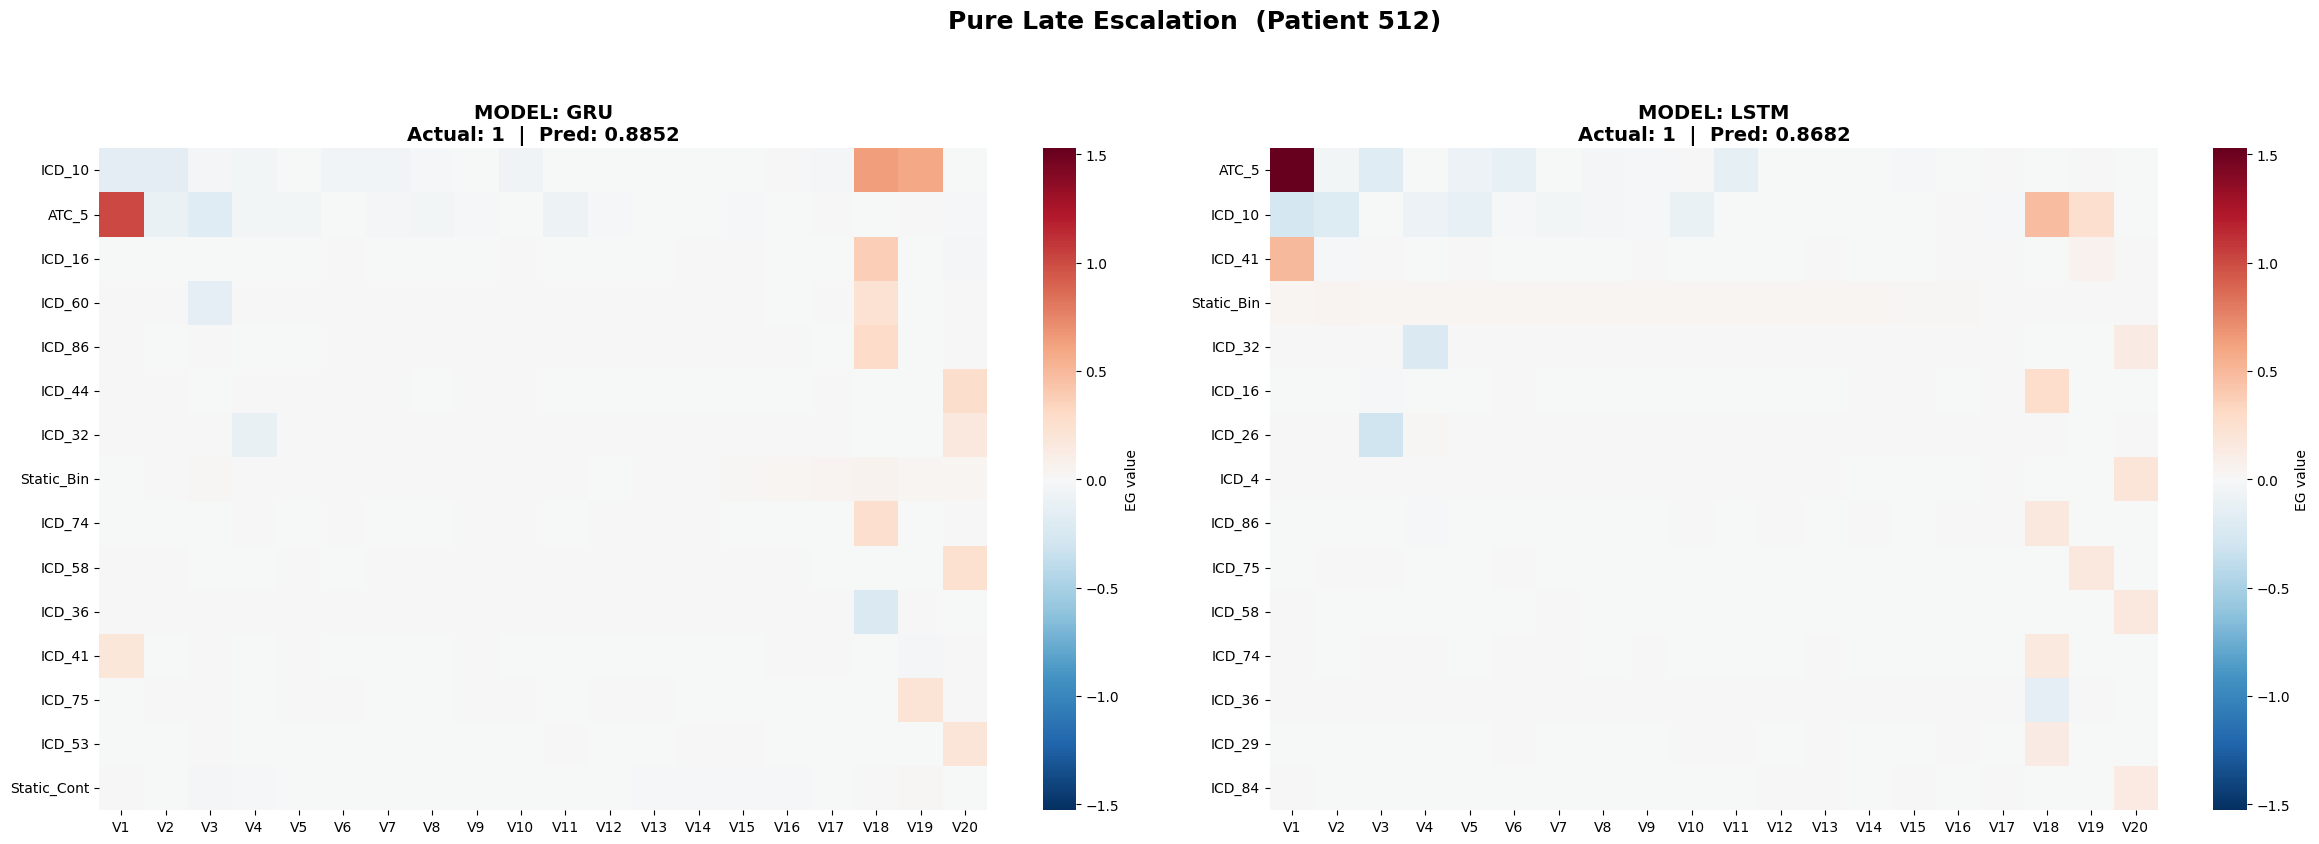

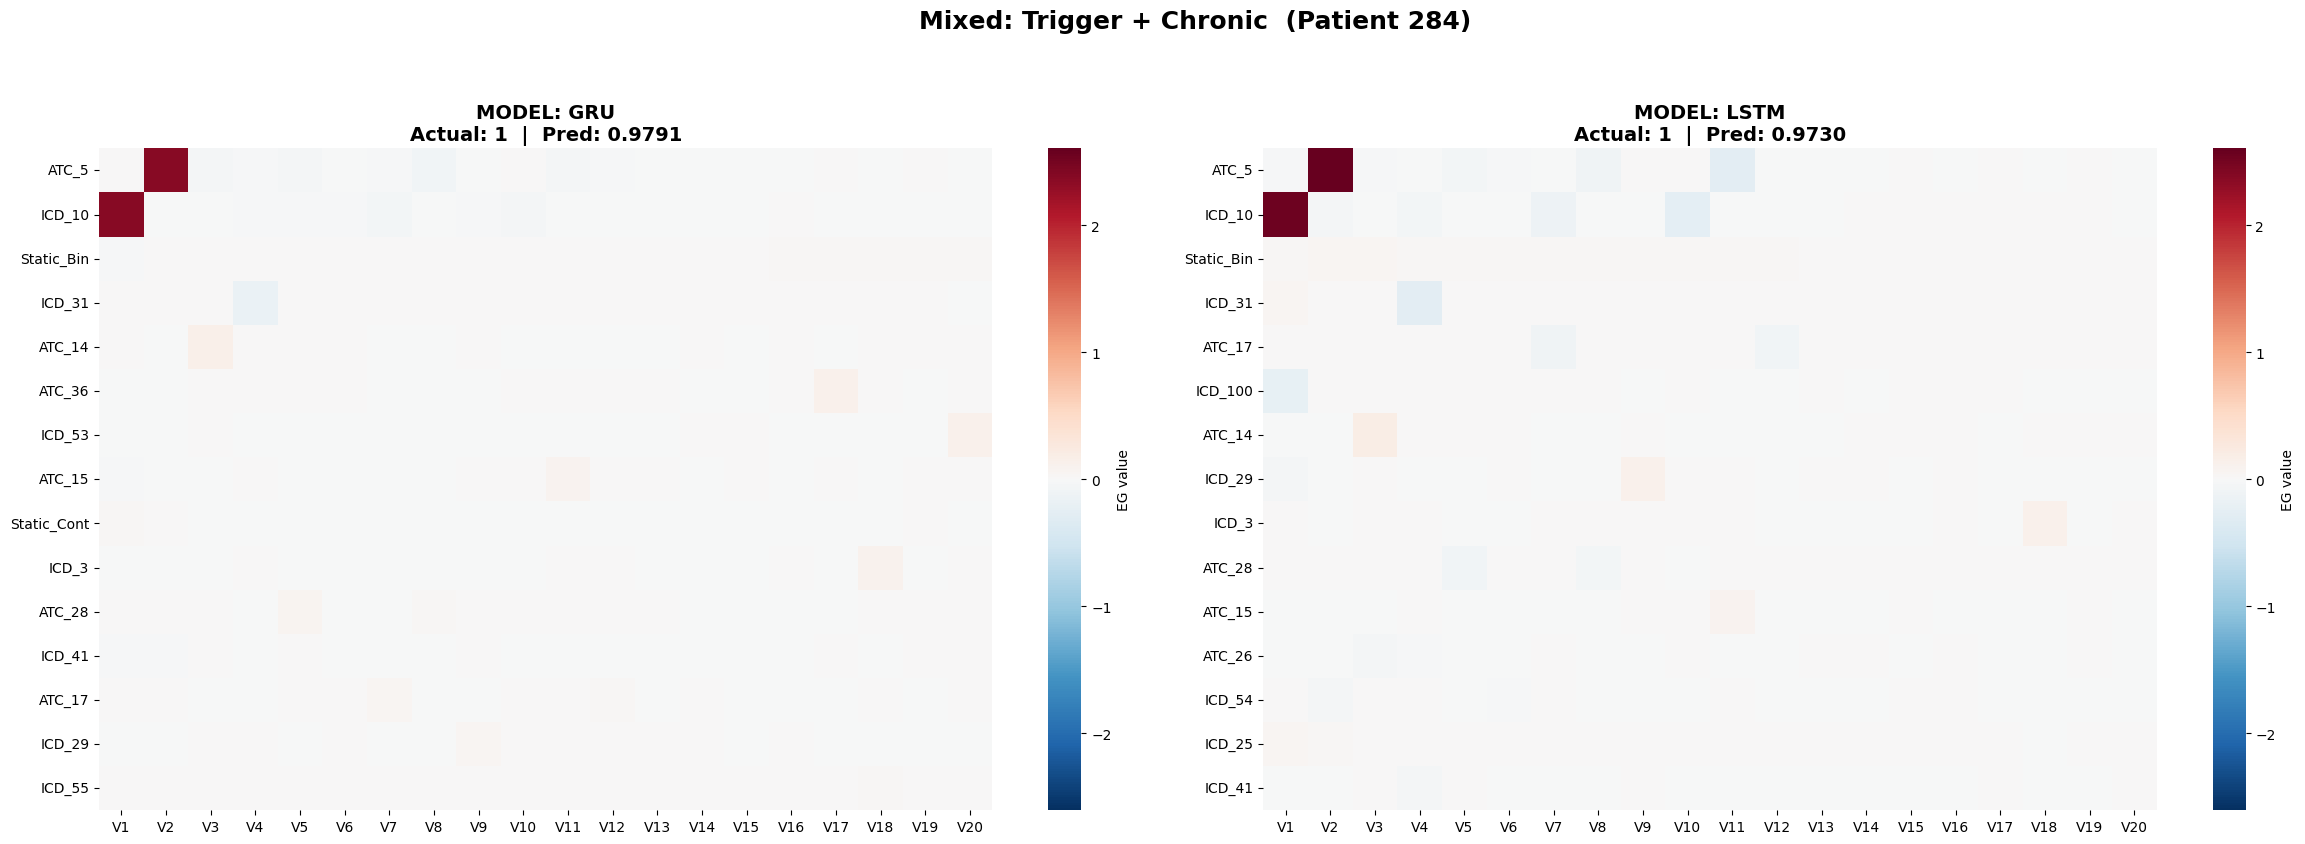

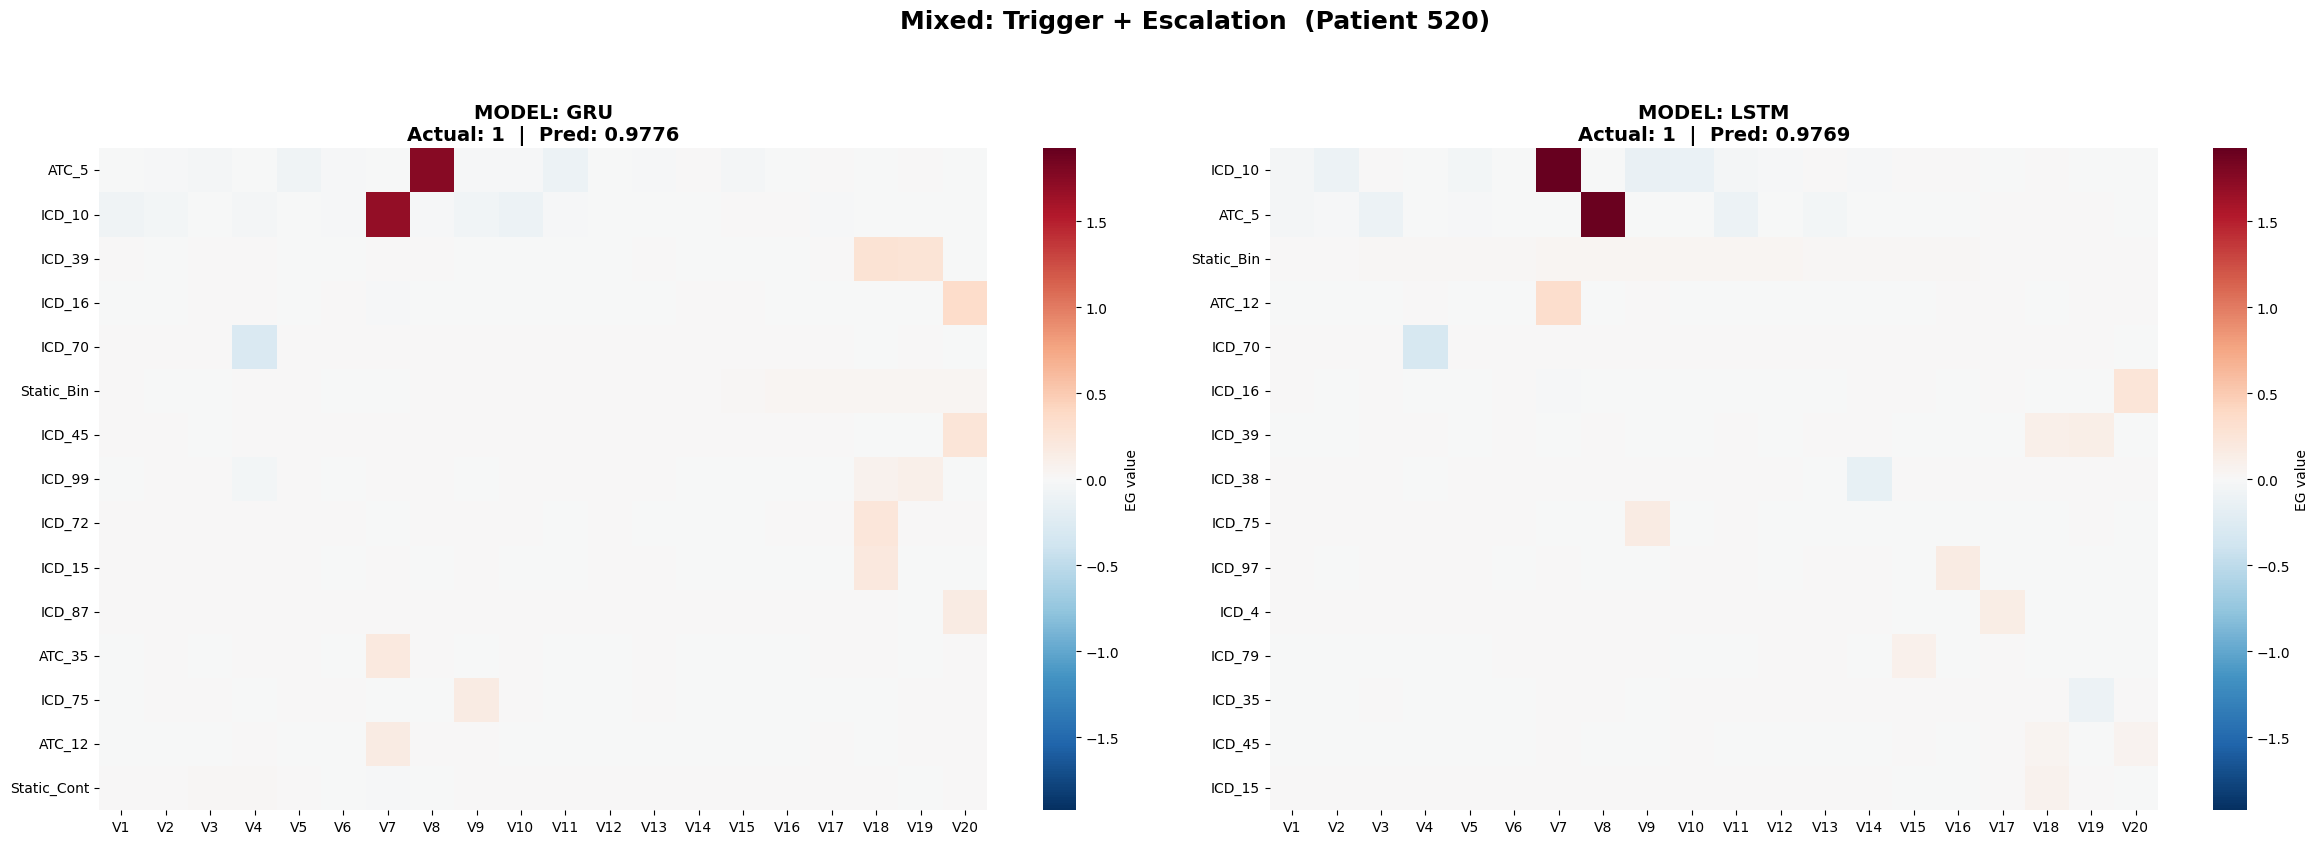

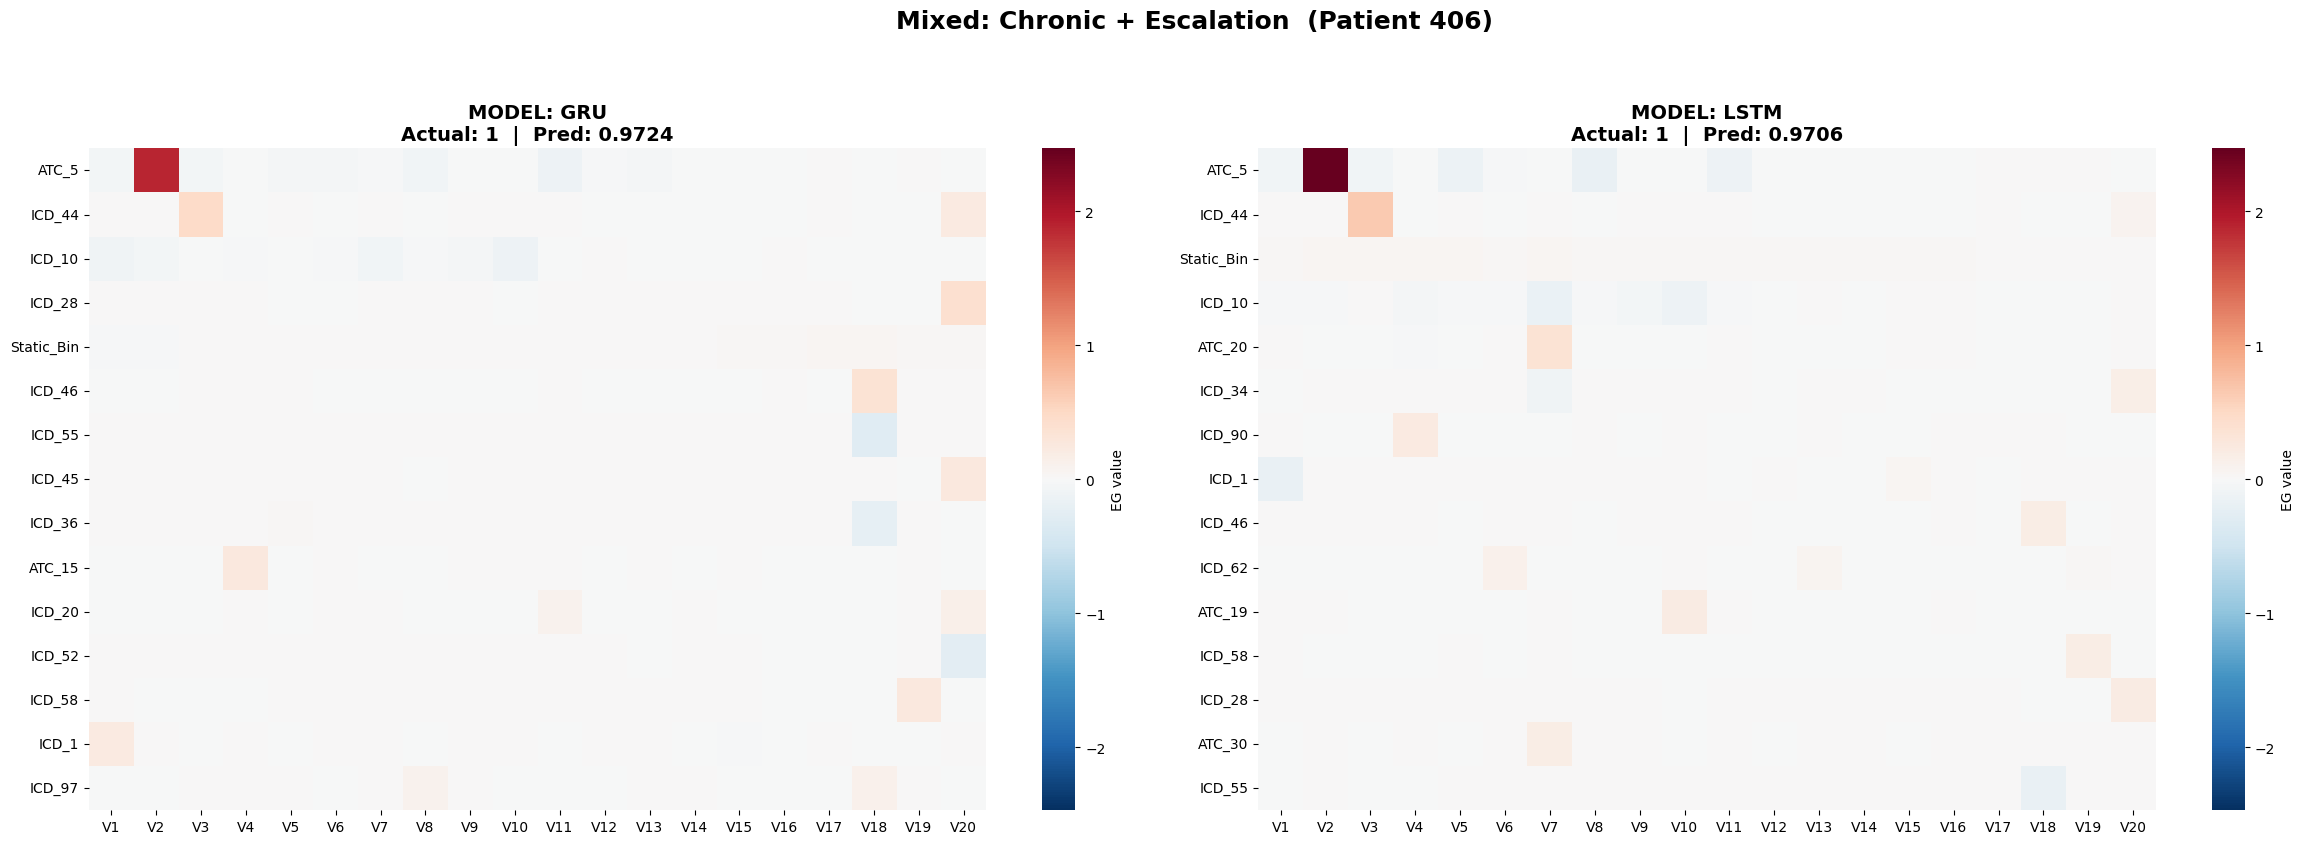

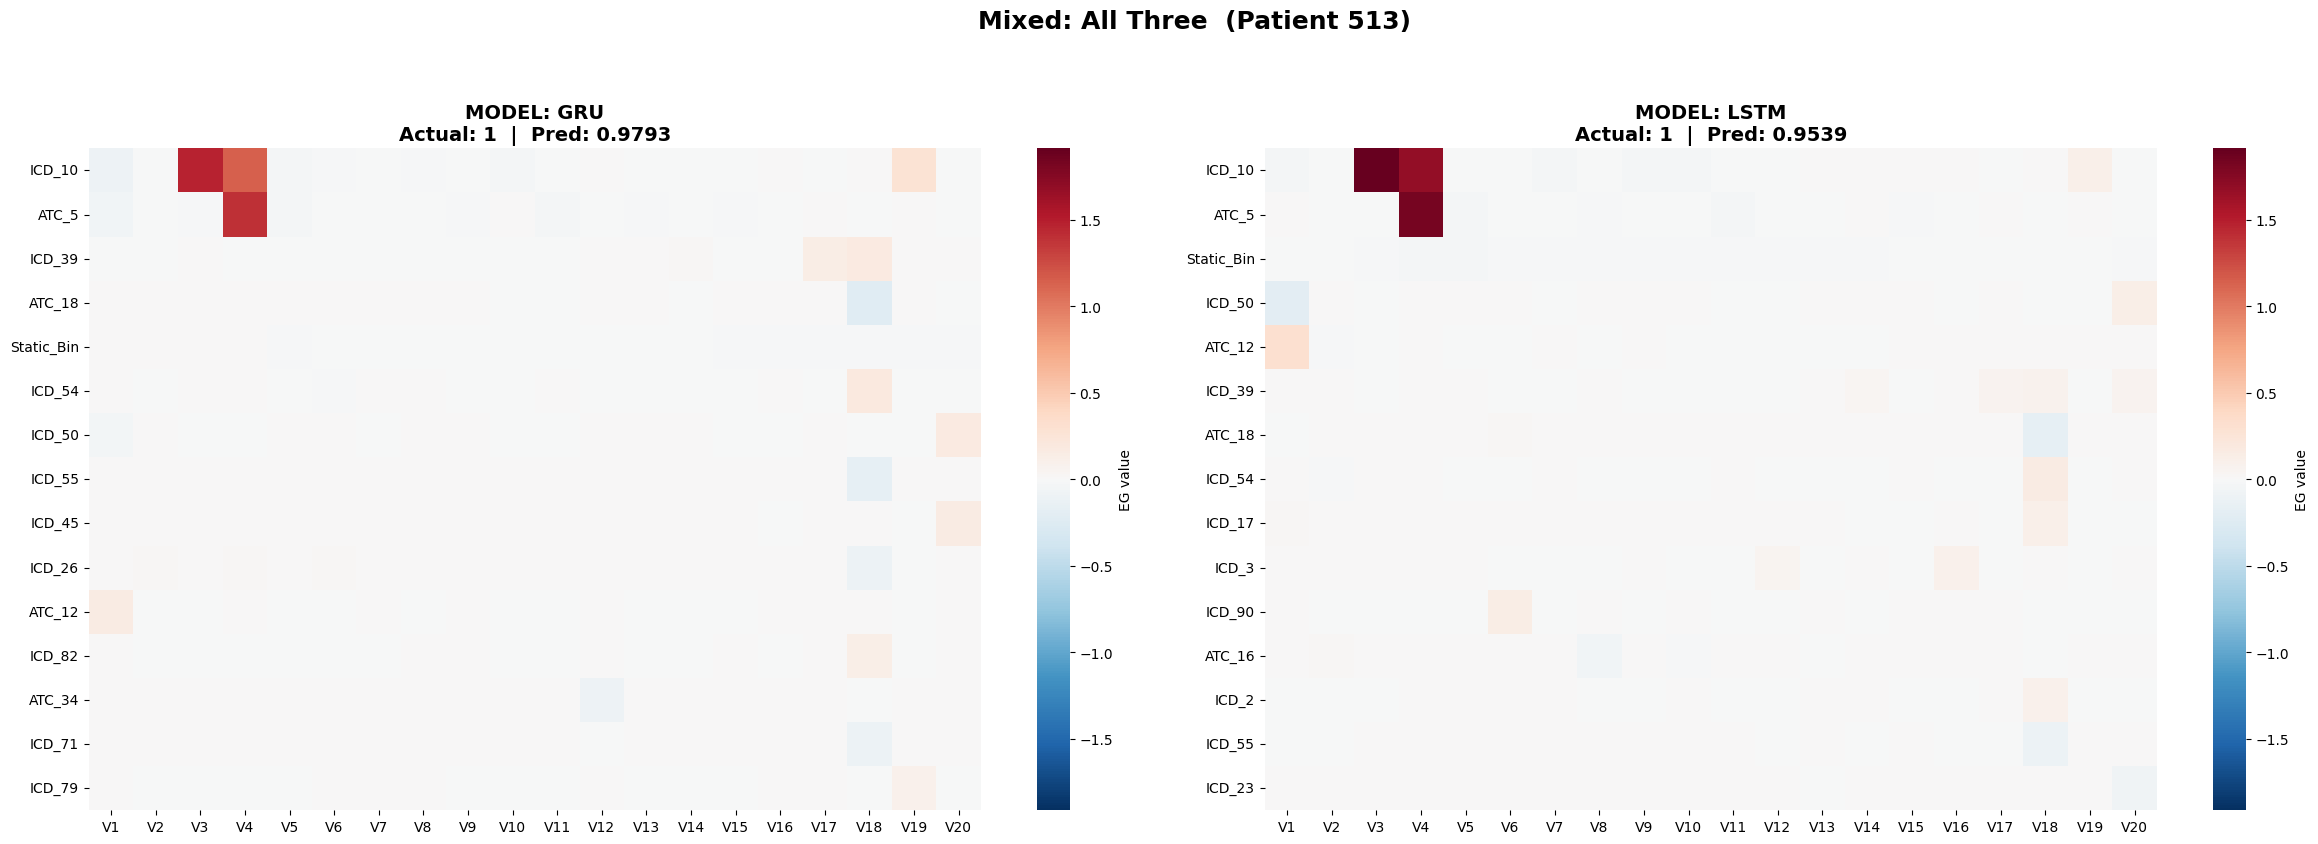

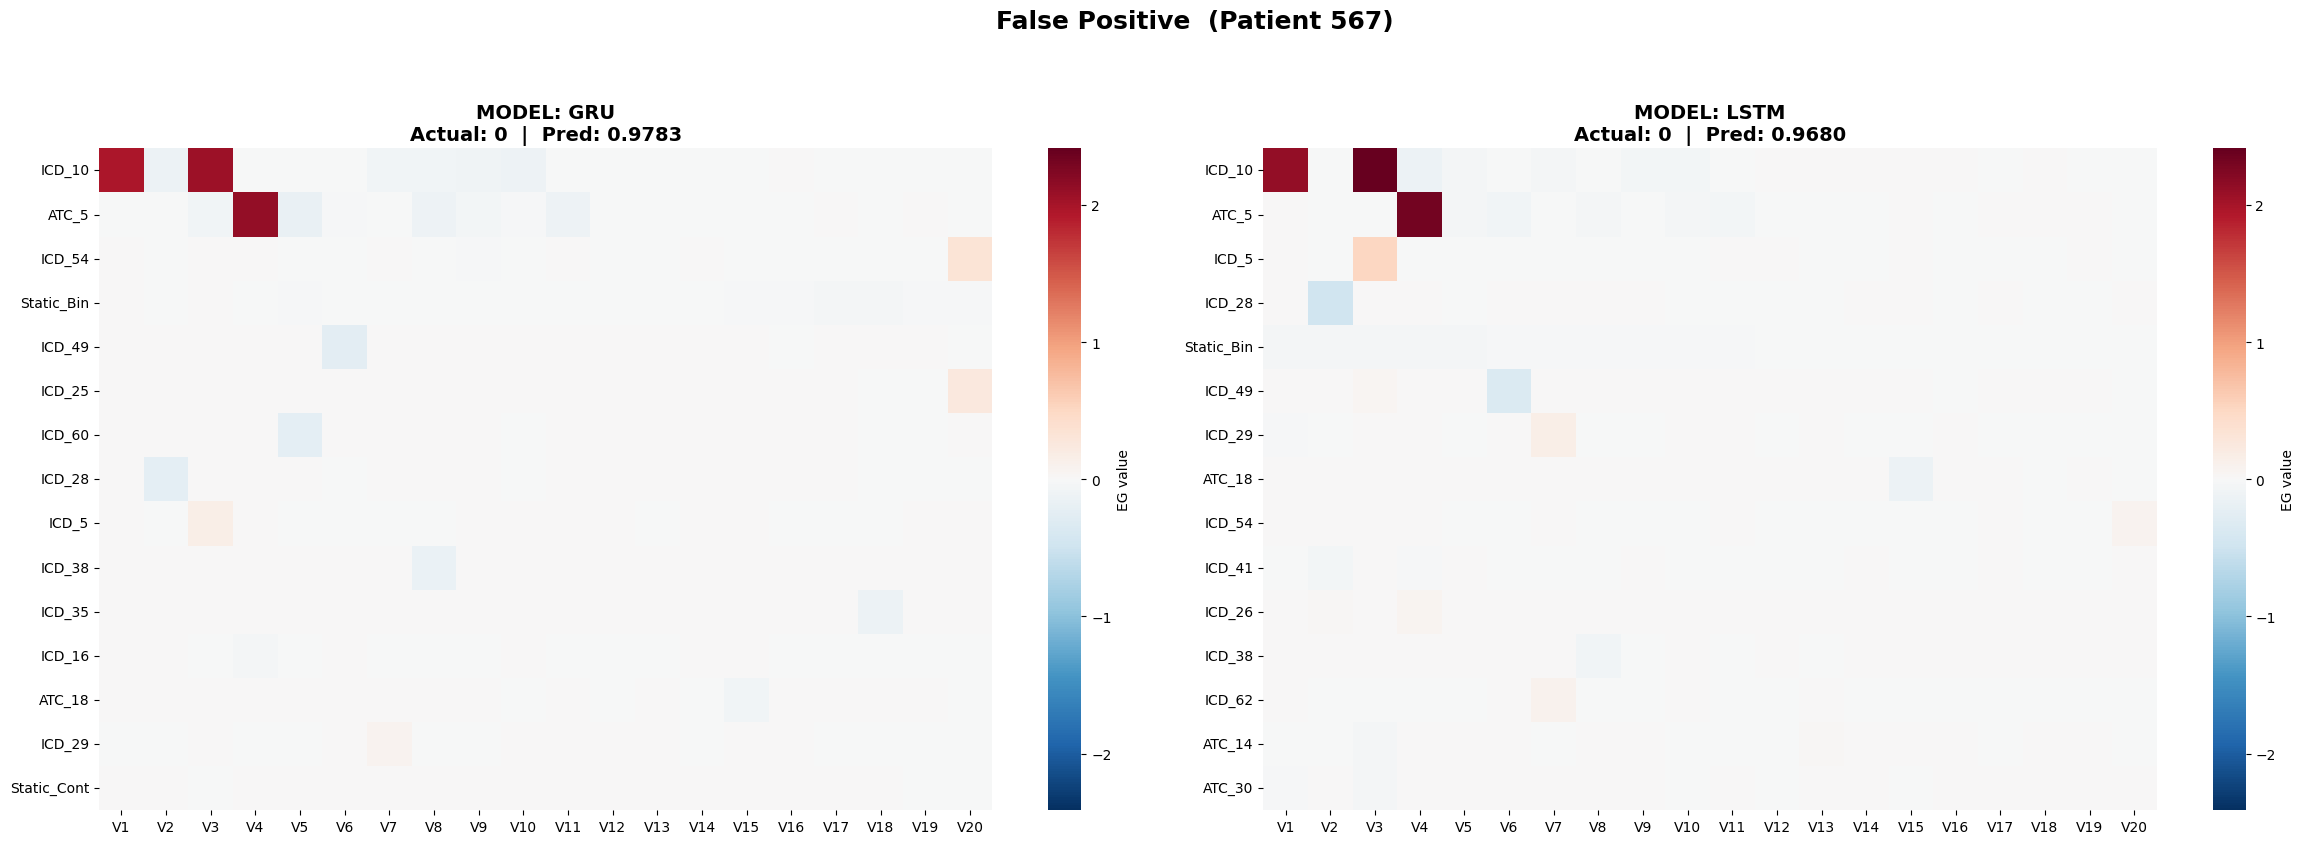


--- Counterfactuals (all timesteps) ---

Counterfactuals – GRU
                       Case  test_idx  patient_id  y_true  p_before  p_after    delta  crossed  n_edits    first_edit
             False Positive       567        1186       0  0.978279 0.122626 0.855653     True        2   ATC_5 @ t=3
           Mixed: All Three       513         113       1  0.979250 0.402399 0.576851     True        3  ICD_10 @ t=2
Mixed: Chronic + Escalation       406        1640       1  0.972439 0.419516 0.552923     True        3   ATC_5 @ t=1
   Mixed: Trigger + Chronic       284        1739       1  0.979053 0.340713 0.638340     True        1  ICD_10 @ t=0
Mixed: Trigger + Escalation       520        2519       1  0.977557 0.417021 0.560537     True        6   ATC_5 @ t=7
               Pure Chronic       421         428       1  0.353155 0.353155 0.000000     True        0          None
       Pure Late Escalation       512         448       1  0.885187 0.445320 0.439867     True        6 ICD_10

NameError: name 'ig_global_maps' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional: restrict to a subset during development
# run_scenarios = ["Baseline", "High Noise"]
run_scenarios = list(SCENARIOS.keys())   # default: all

# ══════════════════════════════════════════════════════════════════════════════
for scenario_name in run_scenarios:
    cfg = SCENARIOS[scenario_name]
    tag = cfg["tag"]

    print(f"\n{'='*70}")
    print(f"  SCENARIO: {scenario_name}  |  tag: {tag}")
    print(f"{'='*70}")

    # Per-scenario output directory
    sc_out = os.path.join(OUT_DIR, scenario_name.replace(" ", "_"))
    os.makedirs(sc_out, exist_ok=True)

    # ------------------------------------------------------------------
    # 2.1  Data loading & splitting
    # ------------------------------------------------------------------
    X, y, tokens, feature_names, labels = utils.load_data(
        SIM_DIR,
        n_patients=cfg["n_patients"],
        n_visits=cfg["n_visits"],
        scenario_tag=tag,
    )

    patient_ids = np.arange(1, cfg["n_patients"] + 1)

    (X_train, X_test,
     y_train, y_test,
     pid_train, pid_test,
     labels_test) = utils.split_data(X, y, labels, patient_ids)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    X_train_np    = np.array(X_train)
    X_test_np     = np.array(X_test)
    np.save(os.path.join(sc_out, 'X_test.npy'), X_test_np)
    utils.save_feature_names(feature_names, sc_out, scenario_tag=tag)

    # ------------------------------------------------------------------
    # 2.2  Classic models
    # ------------------------------------------------------------------
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat  = X_test.reshape(X_test.shape[0],  -1)

    lr_model = LogisticRegression(penalty="l2", C=1.0, max_iter=1000)
    lr_model.fit(X_train_flat, y_train)

    rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=3105)
    rf_model.fit(X_train_flat, y_train)

    # ------------------------------------------------------------------
    # 2.3  Deep learning models
    # ------------------------------------------------------------------
    trained_models = utils.train_all_models(
        MODEL_REGISTRY, X_train, y_train, X_test, y_test,
        train_config=TRAIN_CONFIG, out_dir=sc_out,
    )

    # ------------------------------------------------------------------
    # 2.4  Benchmark table
    # ------------------------------------------------------------------
    bench = utils.benchmark_table(
        trained_models, lr_model, rf_model,
        X_train, X_test, y_train, y_test,
    )
    bench.insert(0, "Scenario", scenario_name)
    bench.to_csv(os.path.join(sc_out, "benchmark.csv"), index=False)
    all_benchmarks[scenario_name] = bench
    print("\nBenchmark:")
    display(bench.drop(columns="Scenario"))

    # ------------------------------------------------------------------
    # 2.5  Case-study selection
    # ------------------------------------------------------------------
    ref_model = next(iter(trained_models.values()))
    with torch.no_grad():
        y_probs_ref = ref_model(X_test_tensor).numpy().ravel()

    case_studies = utils.select_case_studies(
        labels_test, y_test, y_probs_ref, PHENOTYPE_GROUPS
    )

    # ------------------------------------------------------------------
    # 2.6  XAI — Integrated Gradients (IG)
    # ------------------------------------------------------------------
    print("\n--- IG global ---")
    ig_global_maps = utils.run_ig_global(
        trained_models, X_test_tensor, y_test,
        feature_names, n_steps=IG_N_STEPS, out_dir=sc_out,
    )

    print("\n--- IG case studies ---")
    utils.run_ig_case_studies(
        trained_models, X_test_tensor, y_test,
        feature_names, case_studies,
        n_steps=IG_N_STEPS, out_dir=sc_out,
    )

    # ------------------------------------------------------------------
    # 2.7  XAI — Expected Gradients (EG)
    # ------------------------------------------------------------------
    print("\n--- EG (all models) ---")
    eg_by_model, base_by_model = utils.run_eg_all_models(
        trained_models, X_train_np, X_test_np,
        eg_config=EG_CONFIG, out_dir=sc_out,
    )

    utils.run_eg_global_plots(eg_by_model, X_test_np, feature_names, out_dir=sc_out)

    utils.run_eg_local_plots(
        eg_by_model, base_by_model, X_test_np,
        feature_names, patient_idx=2, out_dir=sc_out,
    )

    utils.run_eg_case_studies(
        eg_by_model, feature_names, case_studies,
        trained_models, X_test_tensor, y_test, out_dir=sc_out,
    )

    # ------------------------------------------------------------------
    # 2.8  Counterfactual explanations
    # ------------------------------------------------------------------
    print("\n--- Counterfactuals (all timesteps) ---")
    cf_results = utils.run_cf_all_models(
        trained_models, X_test, y_test, pid_test,
        feature_names, tokens, case_studies,
        cf_config=CF_CONFIG, out_dir=sc_out,
    )

    print("\n--- Counterfactuals (escalation window only) ---")
    T_cf = X_test.shape[1]
    cf_results_esc = utils.run_cf_all_models(
        trained_models, X_test, y_test, pid_test,
        feature_names, tokens, case_studies,
        cf_config={**CF_CONFIG, "allowed_timesteps": list(range(T_cf - 3, T_cf))},
        out_dir=sc_out,
    )

    # ── 2.9  XAI faithfulness evaluation ─────────────────────────────────
    print("\n--- Faithfulness evaluation ---")
    truth_ntf = utils.load_truth_arrays(
        SIM_DIR, tag,
        n_patients=cfg['n_patients'],
        n_visits=cfg['n_visits'],
        feature_names=feature_names,
    )
    # test_indices: position of each test patient in the full cohort (0-based)
    test_indices = np.array([int(p) - 1 for p in pid_test])
    faith_df = utils.run_faithfulness_evaluation(
        eg_by_model=eg_by_model,
        ig_global_maps=ig_global_maps,
        truth_ntf=truth_ntf,
        test_indices=test_indices,
        phenotype_labels=labels_test,
        n_visits=cfg['n_visits'],
        out_dir=sc_out,
    )
    all_faithfulness[scenario_name] = faith_df
    display(faith_df.pivot_table(
        index=['phenotype','metric'], columns='method', values='value'
    ).round(3))

    print(f"\n✓  Scenario '{scenario_name}' complete → {sc_out}")

print("\n" + "="*70)
print("ALL SCENARIOS COMPLETE")
print("="*70)

---
## 3. Cross-Scenario Comparison

Stacks all per-scenario benchmark tables into one view so you can compare how model performance changes across simulation conditions.

In [ ]:
# Stack all benchmark tables
comparison = pd.concat(all_benchmarks.values(), ignore_index=True)
comparison.to_csv(os.path.join(OUT_DIR, "benchmark_all_scenarios.csv"), index=False)

# Pivot: one row per scenario, columns = Model × metric
pivot = comparison.pivot_table(
    index="Scenario", columns="Model", values="Test AUC"
).round(4)
pivot.columns.name = None
pivot = pivot.reindex(list(SCENARIOS.keys()))   # preserve scenario order

print("Test AUC by scenario and model:")
display(pivot)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
pivot.plot(kind="bar", ax=ax, rot=30)
ax.set_ylabel("Test AUC")
ax.set_title("Model performance across simulation scenarios")
ax.legend(title="Model", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "benchmark_comparison.png"), dpi=150, bbox_inches="tight")
plt.show()